#  Object Detection in Low Light

### Objective

Our objective is to compare the mAP(mean Average Precision) of YOLOv3 obtained on COCO dataset to that of the mAP obtained on ExDark dataset and identify the efficiency of the algorithm in low light when compared to normal image dataset. This paper sums up the contrast-based image enhancement techniques applied to preprocess our dataset and compared the results with our benchmark obtained on original ExDark dataset. Also our insights on the comparison between training YOLOv3 model from the ground up to transfer learning techniques have been presented.

### Understanding the Terminlogies

####  YOLOv3 (You Only  Look Once)

YOLO is a fast real time multi object detection algorithm. To perform the detection , the image is divided intoa  grid of size SxS. Each of the cells predict N possible bounding boxes and the probability of each one of them. The YOLO algorithm deletes the boundng boxes below a certain threshod of minimum probability and among the remaining boxes duplicate bounding boxes are removed. This process is called as "non-max suppression"

YOLOv3 uses a feature extractpr named Draknet-53. This is a variant of the open source neural network framework called Darknet which has 53 convolutional layers and also has residuals or shortcut connections. The YOLOv3 architecture is represented as 

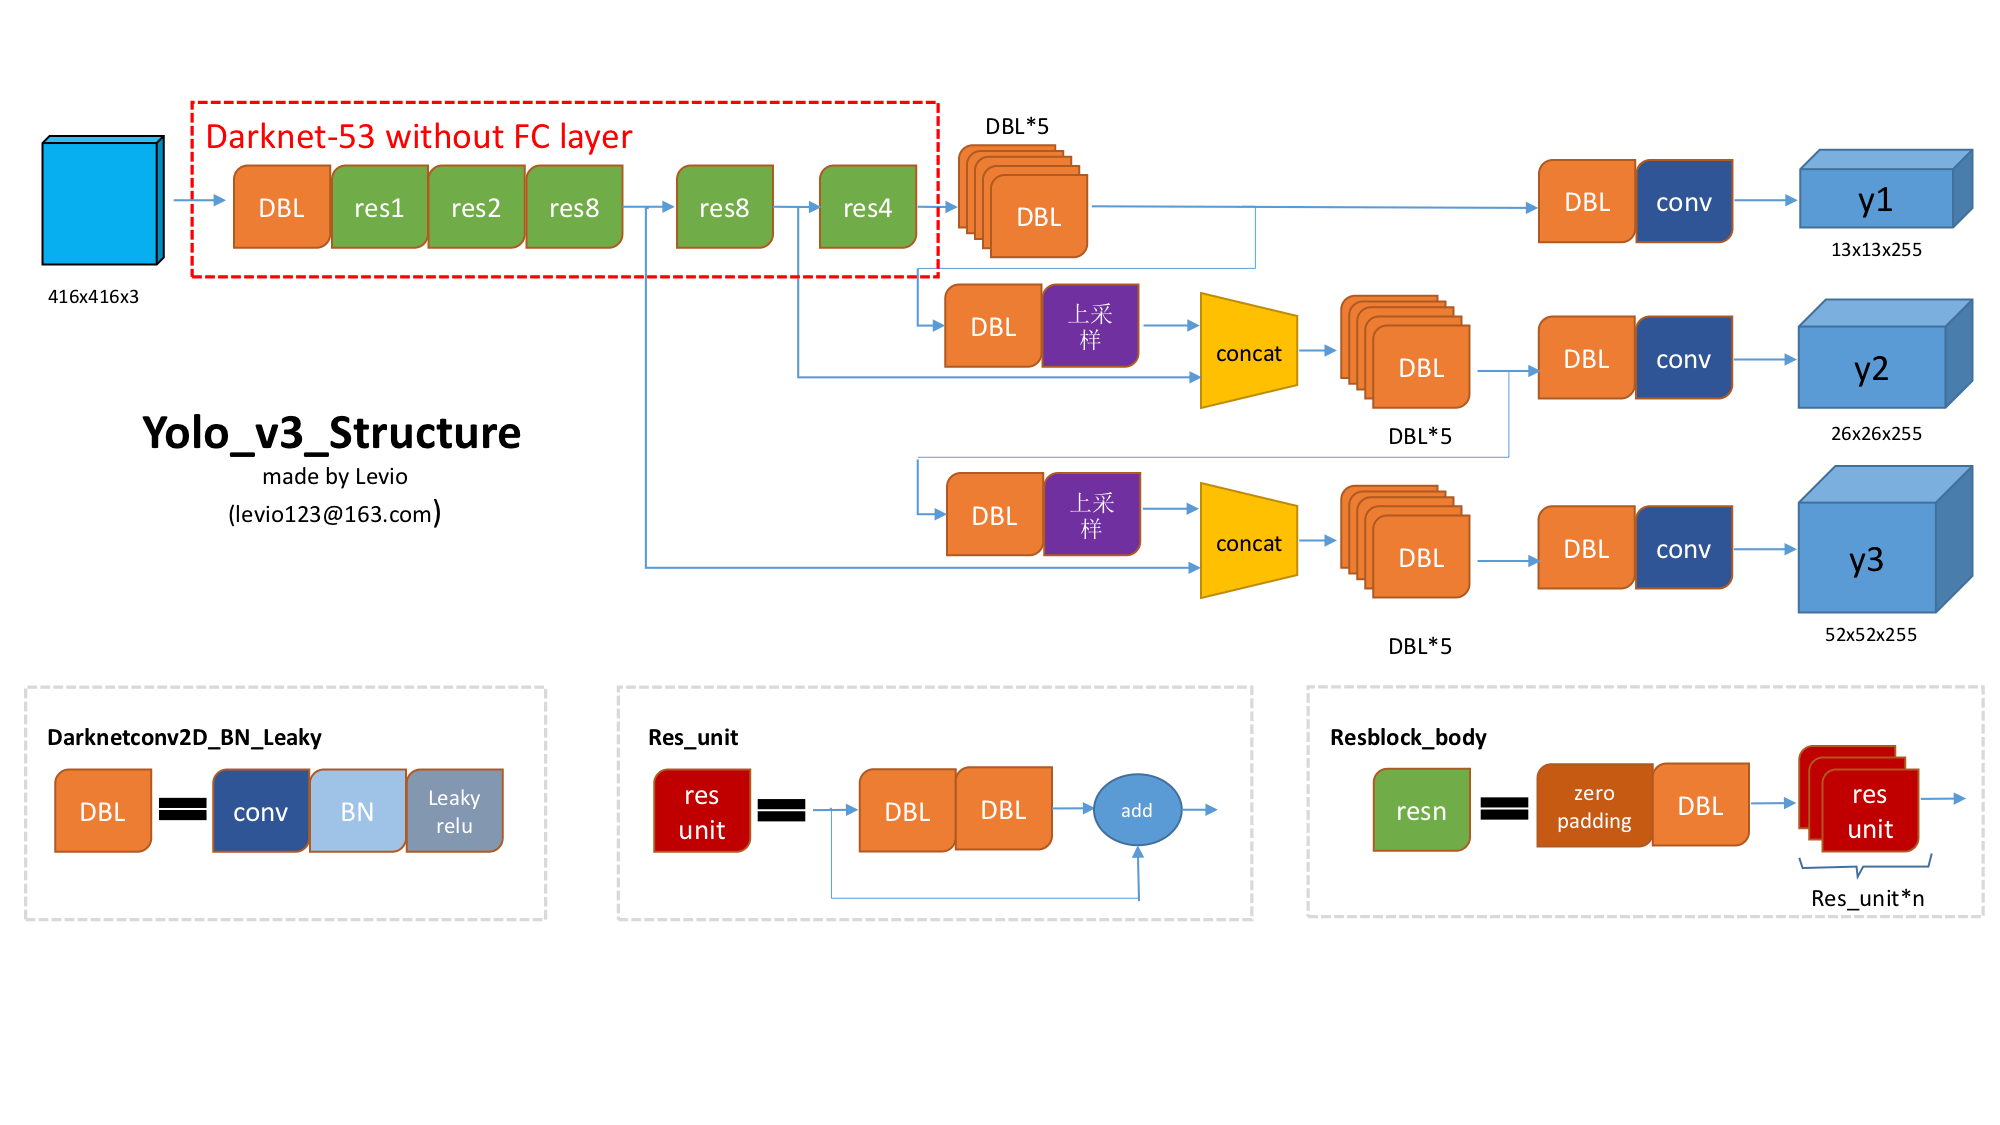

#### Exclusively Dark Dataset (ExDark)

The Exclusively Dark (ExDARK) dataset is a collection of 7,363 low-light images from very low-light environments to twilight (i.e 10 different conditions) with 12 object classes  annotated on both image class level and local object bounding boxes. This data set can be downloaded from https://github.com/cs-chan/Exclusively-DarkImageDataset/blob/master/Dataset . 

#### Evaluation Metrics

The accepted way to evaluate models in Object Detection is using the “mAP” Score (mean Average Precision).The metrics are always evaluated against the ground truth data. For an object detection model the ground truth data includes the image, the classes of the objects and the true bounding boxes of each of the object in the image.

YOLO then computes the sum-squared error between the predicted and ground truth to compute classification , localization , confidence losses.

#### IMAGE ENHANCEMENT

Low-light is a challenging environment for image processing and computer vision tasks, either in contrast
enhancement for better visibility and quality, or application oriented tasks such as detection. Hence, to improve the quality of images we are employing  image enhancement techniques namely

a)histogram equalization(he) :
Histogram Equalization is a computer image processing technique used to improve contrast in images. It accomplishes this by effectively spreading out the most frequent intensity values, i.e. stretching out the intensity range of the image. This method usually increases the global contrast of images when its usable data is represented by close contrast values. This allows for areas of lower local contrast to gain a higher contrast.



b)dynamic histogram equalization(dhe):
This dynamic histogram equalization (DHE) technique takes control over the effect of traditional HE so that it performs the enhancement of an image without making any loss of details in it. DHE partitions the image histogram based on local minima and assigns specific gray level ranges for each partition before equalizing them separately. 


### Code With Documentation:

#### Installations

In [5]:
##installations required
!pip install -r requirements.txt

#### Importing Libraries

In [5]:
## importing required libaries
import cv2
import os
import shutil
import numpy as np
import tensorflow as tf
import core.utils as utils
from core.config import cfg
from core.yolov3 import YOLOv3, decode
import time
from tqdm import tqdm
from core.dataset import Dataset
from core.yolov3 import YOLOv3, decode, compute_loss
from core.config import cfg
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
assert(tf.__version__=='2.0.0-beta1') ## to make sure if the right version of tensorflow is installed in the machine

#### YOLOv3 model loaded pre-trained weights

In [2]:
input_size   = 416
NUM_CLASS    = len(utils.read_class_names(cfg.YOLO.CLASSES))

input_layer  = tf.keras.layers.Input([input_size, input_size, 3])
feature_maps = YOLOv3(input_layer)

bbox_tensors = []
for i, fm in enumerate(feature_maps):
    bbox_tensor = decode(fm, i)
    bbox_tensors.append(tf.reshape(bbox_tensor, (-1, 5+NUM_CLASS)))

bbox_tensors = tf.concat(bbox_tensors, axis=0)
Yolov3_model = tf.keras.Model(input_layer, bbox_tensors)
utils.load_weights(Yolov3_model, "./yolov3.weights")
Yolov3_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu (TensorFl [(None, 416, 416, 32 0           batch_normalization[0][0]        
______________________________________________________________________________________________

batch_normalization_10 (BatchNo (None, 52, 52, 128)  512         conv2d_10[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu_10 (Tenso [(None, 52, 52, 128) 0           batch_normalization_10[0][0]     
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 52, 52, 256)  294912      tf_op_layer_LeakyRelu_10[0][0]   
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 52, 52, 256)  1024        conv2d_11[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu_11 (Tenso [(None, 52, 52, 256) 0           batch_normalization_11[0][0]     
__________________________________________________________________________________________________
tf_op_laye

__________________________________________________________________________________________________
tf_op_layer_LeakyRelu_21 (Tenso [(None, 52, 52, 256) 0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
tf_op_layer_add_8 (TensorFlowOp [(None, 52, 52, 256) 0           tf_op_layer_add_7[0][0]          
                                                                 tf_op_layer_LeakyRelu_21[0][0]   
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 52, 52, 128)  32768       tf_op_layer_add_8[0][0]          
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 52, 52, 128)  512         conv2d_22[0][0]                  
__________________________________________________________________________________________________
tf_op_laye

batch_normalization_32 (BatchNo (None, 26, 26, 512)  2048        conv2d_32[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu_32 (Tenso [(None, 26, 26, 512) 0           batch_normalization_32[0][0]     
__________________________________________________________________________________________________
tf_op_layer_add_13 (TensorFlowO [(None, 26, 26, 512) 0           tf_op_layer_add_12[0][0]         
                                                                 tf_op_layer_LeakyRelu_32[0][0]   
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 26, 26, 256)  131072      tf_op_layer_add_13[0][0]         
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 26, 26, 256)  1024        conv2d_33[0][0]                  
__________

zero_padding2d_4 (ZeroPadding2D (None, 27, 27, 512)  0           tf_op_layer_add_18[0][0]         
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 13, 13, 1024) 4718592     zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, 13, 13, 1024) 4096        conv2d_43[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu_43 (Tenso [(None, 13, 13, 1024 0           batch_normalization_43[0][0]     
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 13, 13, 512)  524288      tf_op_layer_LeakyRelu_43[0][0]   
__________________________________________________________________________________________________
batch_norm

batch_normalization_54 (BatchNo (None, 13, 13, 512)  2048        conv2d_54[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu_54 (Tenso [(None, 13, 13, 512) 0           batch_normalization_54[0][0]     
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 13, 13, 1024) 4718592     tf_op_layer_LeakyRelu_54[0][0]   
__________________________________________________________________________________________________
batch_normalization_55 (BatchNo (None, 13, 13, 1024) 4096        conv2d_55[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu_55 (Tenso [(None, 13, 13, 1024 0           batch_normalization_55[0][0]     
__________________________________________________________________________________________________
conv2d_56 

batch_normalization_68 (BatchNo (None, 52, 52, 128)  512         conv2d_70[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu_68 (Tenso [(None, 52, 52, 128) 0           batch_normalization_68[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 52, 52, 256)  294912      tf_op_layer_LeakyRelu_68[0][0]   
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 52, 52, 256)  1024        conv2d_71[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu_69 (Tenso [(None, 52, 52, 256) 0           batch_normalization_69[0][0]     
__________________________________________________________________________________________________
conv2d_72 

tf_op_layer_Tile_7/multiples (T [(2,)]               0           tf_op_layer_strided_slice_23[0][0
__________________________________________________________________________________________________
tf_op_layer_strided_slice_28 (T [None]               0           tf_op_layer_range_4[0][0]        
__________________________________________________________________________________________________
tf_op_layer_Tile_6/multiples (T [(2,)]               0           tf_op_layer_strided_slice_23[0][0
__________________________________________________________________________________________________
tf_op_layer_Tile_1 (TensorFlowO [(None, None)]       0           tf_op_layer_strided_slice_7[0][0]
                                                                 tf_op_layer_Tile_1/multiples[0][0
__________________________________________________________________________________________________
tf_op_layer_Tile (TensorFlowOpL [(None, None)]       0           tf_op_layer_strided_slice_6[0][0]
          

tf_op_layer_Tile_8/multiples (T [(5,)]               0           tf_op_layer_strided_slice_22[0][0
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [None]               0           tf_op_layer_Reshape[0][0]        
__________________________________________________________________________________________________
tf_op_layer_Tile_2 (TensorFlowO [(None, None, None,  0           tf_op_layer_strided_slice_10[0][0
                                                                 tf_op_layer_Tile_2/multiples[0][0
__________________________________________________________________________________________________
tf_op_layer_strided_slice_3 (Te [None]               0           tf_op_layer_Reshape[0][0]        
__________________________________________________________________________________________________
tf_op_layer_strided_slice_13 (T [None]               0           tf_op_layer_Reshape_2[0][0]      
__________

__________________________________________________________________________________________________
tf_op_layer_Sigmoid_1 (TensorFl [None]               0           tf_op_layer_strided_slice_4[0][0]
__________________________________________________________________________________________________
tf_op_layer_Sigmoid_2 (TensorFl [None]               0           tf_op_layer_strided_slice_5[0][0]
__________________________________________________________________________________________________
tf_op_layer_concat_6 (TensorFlo [None]               0           tf_op_layer_mul_3[0][0]          
                                                                 tf_op_layer_mul_5[0][0]          
__________________________________________________________________________________________________
tf_op_layer_Sigmoid_4 (TensorFl [None]               0           tf_op_layer_strided_slice_15[0][0
__________________________________________________________________________________________________
tf_op_laye

####    This function takes the path of the image as an input and returns object detection results of pre-trained YOLOv3 
 

In [3]:
def yolov3_prediction(image_path):
    image_path   = image_path
    original_image      = cv2.imread(image_path)
    original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image_size = original_image.shape[:2]

    image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
    image_data = image_data[np.newaxis, ...].astype(np.float32)
    try:
        pred_bbox = Yolov3_model.predict(image_data)
    except:
        print('Model not found')
    bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.3)
    bboxes = utils.nms(bboxes, 0.45, method='nms')

    img = utils.draw_bbox(original_image, bboxes)
    image = Image.fromarray(img)
    image.show()
    image.save('predictions/detection_'+image_path.split("/")[-1])


#### Give location of your image to get predictions

In [4]:
yolov3_prediction("data/dataset/ExDark/Dog/2015_05218.jpg") ##pass the path of your image you want to detect objects

#### Obtaining Benchmark for Ex_dark data using pre-trained model

In [1]:
## code for genearating predictions to calculate mAP for the test sets
'''Ex_dark dataset has a subset of below mentioned 12 classes where pre-trained model of yolo can predict 80 classes in COCO dataset'''   
''' We are storing the only results for the classes that exdark data is labelled'''

INPUT_SIZE   = 416
NUM_CLASS    = len(utils.read_class_names(cfg.YOLO.CLASSES))
CLASSES      = utils.read_class_names(cfg.YOLO.CLASSES)


predicted_dir_path = '../mAP/predicted'
ground_truth_dir_path = '../mAP/ground-truth'
if os.path.exists(predicted_dir_path): shutil.rmtree(predicted_dir_path)
if os.path.exists(ground_truth_dir_path): shutil.rmtree(ground_truth_dir_path)
if os.path.exists(cfg.TEST.DECTECTED_IMAGE_PATH): shutil.rmtree(cfg.TEST.DECTECTED_IMAGE_PATH)

os.mkdir(predicted_dir_path)
os.mkdir(ground_truth_dir_path)
os.mkdir(cfg.TEST.DECTECTED_IMAGE_PATH)

# Build Model
input_layer  = tf.keras.layers.Input([INPUT_SIZE, INPUT_SIZE, 3])
feature_maps = YOLOv3(input_layer)

bbox_tensors = []
for i, fm in enumerate(feature_maps):
    bbox_tensor = decode(fm, i)
    bbox_tensors.append(tf.reshape(bbox_tensor, (-1, 5+NUM_CLASS)))

bbox_tensors = tf.concat(bbox_tensors, axis=0)
model = tf.keras.Model(input_layer, bbox_tensors)

#model.summary()
utils.load_weights(model, "./yolov3.weights")

with open(cfg.TEST.ANNOT_PATH, 'r') as annotation_file:
    for num, line in enumerate(annotation_file):
        annotation = line.strip().split()
        image_path = annotation[0]
        image_name = image_path.split('/')[-1]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        bbox_data_gt = np.array([list(map(int, box.split(','))) for box in annotation[1:]])

        if len(bbox_data_gt) == 0:
            bboxes_gt=[]
            classes_gt=[]
        else:
            bboxes_gt, classes_gt = bbox_data_gt[:, :4], bbox_data_gt[:, 4]
        ground_truth_path = os.path.join(ground_truth_dir_path, str(num) + '.txt')

        print('=> ground truth of %s:' % image_name)
        num_bbox_gt = len(bboxes_gt)
        with open(ground_truth_path, 'w') as f:
            for i in range(num_bbox_gt):
                class_name = CLASSES[classes_gt[i]]
                xmin, ymin, xmax, ymax = list(map(str, bboxes_gt[i]))
                bbox_mess = ' '.join([class_name, xmin, ymin, xmax, ymax]) + '\n'
                f.write(bbox_mess)
                print('\t' + str(bbox_mess).strip())
        print('=> predict result of %s:' % image_name)
        predict_result_path = os.path.join(predicted_dir_path, str(num) + '.txt')
        # Predict Process
        image_size = image.shape[:2]
        image_data = utils.image_preporcess(np.copy(image), [INPUT_SIZE, INPUT_SIZE])
        image_data = image_data[np.newaxis, ...].astype(np.float32)

        pred_bbox = model.predict(image_data)
        #bboxes = utils.postprocess_boxes(pred_bbox, image_size, INPUT_SIZE, cfg.TEST.SCORE_THRESHOLD)
        #bboxes = utils.nms(bboxes, cfg.TEST.IOU_THRESHOLD, method='nms')
        bboxes = utils.postprocess_boxes(pred_bbox, image_size, INPUT_SIZE, cfg.TEST.SCORE_THRESHOLD)
        bboxes = utils.nms(bboxes, cfg.TEST.IOU_THRESHOLD, method='nms')


        if cfg.TEST.DECTECTED_IMAGE_PATH is not None:
            image = utils.draw_bbox(image, bboxes)
            cv2.imwrite(cfg.TEST.DECTECTED_IMAGE_PATH+image_name, image)

## listing out the classes that we want calculate Average Precisions 
        required_classes = ['person','bicycle','car','diningtable','boat','motorbike','chair','dog','cup','bottle','bus','cat']

        with open(predict_result_path, 'w') as f:
            for bbox in bboxes:
                coor = np.array(bbox[:4], dtype=np.int32)
                score = bbox[4]
                class_ind = int(bbox[5])
                class_name = CLASSES[class_ind]
                if class_name in required_classes: ##this line will make sure to store only required predictions
                    score = '%.4f' % score
                    xmin, ymin, xmax, ymax = list(map(str, coor))
                    bbox_mess = ' '.join([class_name, score, xmin, ymin, xmax, ymax]) + '\n'
                    f.write(bbox_mess)
                    print('\t' + str(bbox_mess).strip())

C:\Users\navee\Anaconda3\envs\tensorflow2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\navee\Anaconda3\envs\tensorflow2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\navee\Anaconda3\envs\tensorflow2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\navee\Anaconda3\envs\tensorflow2.0\lib\s

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00001.png:
	bicycle 204 28 475 221
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00001.png:
	bicycle 0.9811 207 51 468 223
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00002.png:
	bicycle 136 190 215 299
	bicycle 219 172 282 303
	bicycle 277 188 353 312
	bicycle 348 183 405 264
	car 316 171 349 197
	car 395 175 429 199
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00002.png:
	bicycle 0.9958 336 183 403 260
	bicycle 0.9839 277 197 350 303
	bicycl

	bicycle 0.9915 21 243 231 413
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00018.jpg:
	bicycle 57 249 307 403
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00018.jpg:
	boat 0.3386 162 211 198 229
	person 0.2701 118 227 126 250
	bicycle 0.9992 43 247 307 392
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00019.jpg:
	bicycle 251 173 497 305
	person 134 142 197 235
	person 93 140 132 207
	person 17 139 73 321
	person 62 150 117 314
	person 220 141 293 226
	person 305 140 354 218
	person 382 135 439 203
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-O

	bicycle 0.9694 203 182 451 451
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00032.jpg:
	bicycle 67 231 332 390
	person 127 128 262 380
	person 457 117 536 379
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00032.jpg:
	person 0.9989 128 135 258 368
	person 0.9606 465 123 530 343
	bicycle 0.9980 75 238 329 377
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00033.jpg:
	bicycle 27 76 291 315
	person 321 116 354 225
	chair 383 179 420 240
	person 351 110 388 221
	person 382 114 408 186
	person 474 103 506 246
	person 30 147 81 225
	person 1 95 44 241
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object

	bicycle 0.9963 234 224 330 397
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00046.jpg:
	bicycle 94 291 333 489
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00046.jpg:
	person 0.7098 191 224 199 251
	bicycle 0.9915 103 314 343 477
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00047.jpg:
	bicycle 236 180 397 362
	person 260 89 344 334
	car 472 114 596 202
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00047.jpg:
	person 0.9984 267 94 344 319
	bicycle 0.9972 244 202 392 357
=> ground truth of

	bicycle 0.2940 236 244 265 288
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00060.jpg:
	bicycle 174 34 371 359
	car 466 53 541 97
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00060.jpg:
	bicycle 0.9976 156 58 357 358
	car 0.6992 462 48 532 99
	car 0.2622 439 46 458 61
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00061.jpg:
	bicycle 7 75 319 368
	bicycle 469 116 536 219
	car 580 92 630 124
	person 476 61 532 187
	person 275 2 482 417
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00061.jpg

	person 0.9291 228 263 334 437
	person 0.8141 407 258 494 393
	person 0.5603 222 277 357 534
	bicycle 0.9475 490 263 739 607
	bicycle 0.2560 173 328 246 444
	dog 0.9634 216 332 362 536
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00075.jpg:
	bicycle 72 123 628 499
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00075.jpg:
	bicycle 0.9947 60 133 610 492
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00076.jpg:
	bicycle 340 290 464 380
	bicycle 526 286 621 338
	bicycle 195 283 253 323
	bicycle 2 289 126 351
	person 356 262 429 354
	person 555 257 588 319
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_O

	bicycle 0.9961 31 519 262 763
	bicycle 0.8477 275 424 402 641
	bicycle 0.3626 580 428 646 546
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00089.jpg:
	bicycle 2 9 275 422
	bicycle 566 256 633 303
	bicycle 505 260 574 299
	bicycle 457 262 506 296
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00089.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00090.jpg:
	bicycle 259 264 341 401
	bicycle 214 235 233 278
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00090.jpg:
	person 0.8810 250 220 267 

	person 0.4830 314 416 347 492
	bicycle 0.9956 140 516 300 667
	car 0.3774 621 430 667 470
	dog 0.6960 731 506 797 568
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00105.jpg:
	bicycle 197 520 593 798
	dog 136 474 193 556
	person 122 387 180 519
	person 231 372 248 424
	person 346 363 375 430
	person 431 364 456 414
	person 550 361 597 458
	person 321 368 342 408
	car 76 375 125 417
	car 3 381 88 433
	car 115 364 192 426
	car 184 370 214 402
	car 244 376 281 411
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00105.jpg:
	person 0.9954 122 383 179 513
	person 0.9570 350 365 366 421
	person 0.9413 427 365 439 410
	person 0.9176 438 370 449 409
	person 0.8945 557 367 584 454
	person 0.6737 330 373 339 402
	person 0.6168 305 380 314 404
	person

	car 0.9881 143 230 199 260
	car 0.9880 268 227 319 261
	car 0.8012 244 226 276 251
	car 0.7740 98 228 149 252
	bicycle 0.8130 138 294 210 423
	bicycle 0.4783 180 295 250 473
	bicycle 0.3281 290 334 334 501
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00119.jpg:
	bicycle 452 264 513 392
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00119.jpg:
	bicycle 0.6214 458 270 499 386
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00120.jpg:
	bicycle 74 150 429 391
	car 74 91 183 156
	car 389 83 508 165
	car 306 92 352 120
	person 163 42 327 371
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_

	person 0.9921 323 207 343 281
	person 0.9792 182 166 253 377
	person 0.9686 345 213 362 280
	bicycle 0.9854 179 262 267 387
	car 0.9849 122 230 168 259
	car 0.5293 9 213 96 281
	bus 0.2617 101 199 161 239
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00134.jpg:
	bicycle 173 159 449 492
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00134.jpg:
	bicycle 0.9580 183 150 436 472
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00135.jpg:
	bicycle 512 541 799 727
	bicycle 271 580 404 742
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3

	bicycle 0.9948 70 270 378 479
	bicycle 0.9929 423 299 578 418
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00151.jpg:
	bicycle 329 253 726 493
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00151.jpg:
	bicycle 0.9974 300 243 734 484
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00152.jpg:
	bicycle 288 160 465 464
	bicycle 3 88 263 284
	person 283 2 450 344
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00152.jpg:
	person 0.9999 286 17 439 329
	bicycle 0.9934 327 183 451 470
	bicycle 0.9617 7

	person 0.9997 634 312 764 522
	bicycle 0.9963 571 405 822 555
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00167.jpg:
	bicycle 57 343 137 511
	bicycle 154 377 248 525
	bicycle 383 423 481 552
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00167.jpg:
	bicycle 0.9870 158 379 239 519
	bicycle 0.9036 387 462 474 550
	bicycle 0.8987 54 346 120 508
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00168.jpg:
	bicycle 130 317 324 477
	person 150 236 289 470
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\201

	person 0.9993 207 141 276 271
	person 0.9993 121 117 197 268
	person 0.9646 98 155 128 249
	bicycle 0.9934 200 208 286 301
	bicycle 0.9925 110 204 206 310
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00182.jpg:
	bicycle 191 171 269 332
	person 190 95 272 281
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00182.jpg:
	person 0.9980 187 107 268 265
	bicycle 0.9118 200 159 256 302
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00183.jpg:
	bicycle 87 123 302 384
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_ben

	bicycle 0.9926 387 116 971 467
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00197.png:
	bicycle 197 44 441 194
	person 226 10 425 165
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00197.png:
	person 0.9719 225 9 416 153
	bicycle 0.9033 217 39 418 182
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00198.jpg:
	bicycle 5 4 441 778
	bicycle 514 255 667 527
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00198.jpg:
	bicycle 0.9132 0 0 676 703
=> ground truth of C:\Users\navee\Desktop\MS_Data_Scien

	person 0.9925 315 372 352 469
	person 0.9112 509 367 526 413
	person 0.8959 566 362 602 450
	person 0.5628 602 355 638 435
	person 0.3188 624 358 637 430
	person 0.3077 599 359 620 427
	person 0.2794 483 373 494 396
	bicycle 0.5581 329 418 348 469
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00212.jpg:
	bicycle 86 297 436 531
	person 146 108 347 526
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00212.jpg:
	person 0.9939 152 101 328 510
	bicycle 0.9997 94 322 431 522
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00213.jpg:
	bicycle 9 265 109 344
	bicycle 266 251 330 314
=> predict result of C:\Users\navee\Desktop\M

	person 0.3870 94 131 101 151
	bicycle 0.9815 260 120 439 310
	bicycle 0.3102 251 115 366 217
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00228.jpg:
	bicycle 351 123 496 254
	car 23 67 328 268
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00228.jpg:
	bicycle 0.3106 389 154 488 250
	car 0.8631 26 76 340 264
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00229.jpg:
	bicycle 27 468 289 829
	person 617 608 700 743
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00229.jpg:
	person 0.8823 622 617 6

	bicycle 0.9853 87 84 417 278
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00240.jpg:
	bicycle 178 137 350 283
	person 207 86 227 137
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00240.jpg:
	person 0.9884 209 88 225 135
	person 0.8451 258 97 272 132
	person 0.2517 403 98 424 133
	bicycle 0.9995 181 148 324 267
	car 0.8359 252 92 412 156
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00241.jpg:
	bicycle 248 172 628 456
	diningtable 141 534 458 676
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\201

	person 0.9987 314 128 347 220
	person 0.9951 365 123 404 240
	person 0.9941 182 112 255 269
	bicycle 0.8904 179 184 252 304
	car 0.6948 10 129 121 205
	car 0.3859 258 135 303 168
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00254.jpg:
	bicycle 111 174 428 673
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00254.jpg:
	bicycle 0.9070 139 200 399 660
	car 0.8862 430 315 461 336
	car 0.5063 452 307 467 321
	car 0.4081 415 306 429 322
	car 0.2569 435 307 454 320
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00255.jpg:
	bicycle 104 374 181 436
	bicycle 5 368 105 450
	person 138 356 152 390
	person 166 359 179 385
	person

	person 0.8098 26 377 56 469
	person 0.5011 7 377 36 465
	person 0.4896 50 381 69 418
	bicycle 0.8671 115 425 168 505
	bicycle 0.7896 164 422 213 513
	bicycle 0.7147 238 412 307 531
	bicycle 0.5025 185 421 230 514
	bicycle 0.4964 268 436 312 535
	bicycle 0.4516 44 420 82 487
	bicycle 0.4445 61 416 103 491
	bicycle 0.3981 208 426 252 518
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00269.jpg:
	bicycle 11 547 231 759
	person 502 416 613 645
	person 715 409 781 621
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00269.jpg:
	person 0.9969 524 420 609 634
	person 0.9196 712 403 772 612
	bicycle 0.9678 4 565 220 751
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\

	person 0.9898 135 110 197 290
	person 0.9826 257 125 316 241
	person 0.9801 197 122 237 223
	person 0.9738 374 110 425 275
	bicycle 0.9409 192 166 243 233
	bicycle 0.9368 134 203 205 303
	bicycle 0.9132 11 182 101 245
	bicycle 0.8496 377 174 427 291
	bicycle 0.7712 257 178 321 286
	bicycle 0.5832 295 179 323 239
	bicycle 0.5301 447 162 459 204
	bicycle 0.3510 257 190 289 279
	car 0.2757 95 138 167 172
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00281.jpg:
	bicycle 140 295 226 356
	person 172 275 216 346
	person 74 264 93 317
	person 33 262 61 316
	person 283 262 307 324
	person 268 266 290 327
	person 306 268 333 324
	person 353 271 373 319
	person 381 268 398 313
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00281.jpg:
	person 0.9869 

	person 0.9673 323 185 390 248
	bicycle 0.9973 128 238 309 360
	car 0.3075 580 248 608 262
	bus 0.9999 141 66 571 389
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00293.jpg:
	bicycle 6 334 223 474
	bicycle 646 319 860 470
	bicycle 285 273 333 301
	car 57 258 115 294
	car 101 260 163 312
	car 390 259 522 306
	car 595 252 751 312
	car 697 244 814 289
	car 794 244 896 295
	car 775 268 898 340
	person 251 247 284 295
	person 291 245 310 283
	person 539 245 556 289
	person 402 312 498 439
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00293.jpg:
	person 0.9058 539 252 551 288
	person 0.7025 403 320 528 438
	person 0.4287 257 257 276 293
	car 0.9861 388 262 525 303
	car 0.9816 104 263 160 305
	car 0.9687 593 256 748 308
	car 0.9642 773 259 899 

	bicycle 0.9997 74 129 296 276
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00307.jpg:
	bicycle 110 287 300 412
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00307.jpg:
	bicycle 0.9977 124 293 286 399
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00308.jpg:
	bicycle 68 425 603 764
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00308.jpg:
	bicycle 0.9986 65 452 586 746
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Dete

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00323.jpg:
	bicycle 813 335 1622 876
	bicycle 15 322 801 941
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00323.jpg:
	bicycle 0.9996 822 380 1570 853
	bicycle 0.9922 18 297 807 961
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00324.jpg:
	bicycle 65 315 269 505
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00324.jpg:
	bicycle 0.9991 74 317 257 503
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow

	bus 0.2546 166 274 274 324
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00338.jpg:
	bicycle 363 238 467 426
	person 332 180 407 416
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00338.jpg:
	person 0.9924 343 175 408 417
	bicycle 0.9636 370 268 443 402
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00339.jpg:
	bicycle 188 92 424 350
	bicycle 1 94 159 333
	motorbike 145 130 360 269
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00339.jpg:
	person 0.4749 463 137 476 280
	bicycle 0.9861 0 91 171

	bicycle 0.9607 511 76 634 254
	bicycle 0.8888 236 34 321 290
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00353.jpg:
	bicycle 236 191 569 399
	bicycle 36 206 91 253
	car 174 187 246 237
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00353.jpg:
	boat 0.3878 222 226 273 255
	bicycle 0.9994 233 205 549 395
	bicycle 0.6472 30 215 83 246
	bicycle 0.3582 63 213 123 242
	bicycle 0.2596 3 216 59 248
	car 0.7435 185 189 239 223
	car 0.5962 239 199 270 216
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00354.jpg:
	bicycle 6 235 882 678
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\

	person 0.9008 179 276 191 312
	person 0.8953 165 276 176 312
	person 0.7427 138 274 147 301
	person 0.7161 197 276 207 313
	person 0.5978 283 276 300 311
	person 0.5874 102 268 110 292
	person 0.3878 228 274 234 297
	person 0.3117 221 275 227 298
	person 0.2946 185 274 196 312
	bicycle 0.9964 207 304 298 381
	bicycle 0.9398 149 323 194 467
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00370.jpg:
	bicycle 470 321 582 407
	person 58 249 93 311
	person 17 235 46 318
	person 164 237 184 276
	person 188 233 214 278
	person 211 227 233 279
	person 228 228 252 278
	person 262 230 281 297
	person 286 250 316 334
	person 314 224 337 265
	person 340 228 361 282
	person 317 253 341 332
	person 347 254 372 331
	person 367 218 394 257
	person 284 210 308 247
	person 244 206 267 247
	person 137 205 158 242
	person 177 206 217 245
	person 381 237 405 295
	person 405 230 427 26

	person 0.9987 284 85 364 354
	person 0.3767 324 210 442 387
	car 0.9989 40 89 302 281
	motorbike 0.4842 434 244 567 370
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00380.jpg:
	bicycle 225 442 329 639
	car 187 369 262 430
	car 86 395 250 505
	car 2 471 182 636
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00380.jpg:
	bicycle 0.9881 235 434 328 637
	car 0.9992 95 384 243 515
	car 0.9802 183 368 256 438
	car 0.8325 5 480 171 631
	car 0.2810 248 368 266 387
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00381.jpg:
	bicycle 213 42 272 90
	person 221 26 258 77
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\

	person 0.9104 240 265 293 377
	person 0.8598 69 245 87 304
	person 0.3200 85 252 95 276
	person 0.2650 66 246 79 300
	bicycle 0.8222 246 312 289 402
	car 0.9981 72 277 185 369
	car 0.9927 315 264 405 329
	car 0.9825 502 275 614 349
	car 0.9745 585 284 639 381
	car 0.9723 414 269 481 332
	car 0.9297 461 258 563 343
	car 0.8060 87 258 149 287
	car 0.7957 308 249 363 292
	car 0.4303 369 256 413 284
	car 0.4132 311 255 357 318
	car 0.3956 146 254 159 269
	car 0.3618 304 263 319 291
	car 0.3099 398 272 423 322
	bus 0.9955 161 177 301 321
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00394.jpg:
	bicycle 154 199 292 288
	bicycle 14 278 278 425
	bicycle 460 213 579 310
	bicycle 311 123 429 192
	car 182 152 354 273
	car 389 168 519 283
	person 27 140 77 200
	person 65 150 112 203
	person 144 139 194 216
	person 184 148 255 255
	person 48 144 202 416
	person 332 145 384 2

	person 0.9959 435 221 477 316
	person 0.9850 379 209 414 309
	person 0.6188 291 209 310 257
	person 0.4915 307 215 319 245
	person 0.4142 375 210 396 258
	person 0.2856 304 211 320 253
	person 0.2595 285 211 294 227
	person 0.2571 294 218 306 243
	car 0.9980 473 222 615 273
	bicycle 0.8777 277 230 329 260
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00406.jpg:
	bicycle 345 307 401 409
	bicycle 451 288 480 322
	car 111 265 211 319
	car 162 263 343 334
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00406.jpg:
	person 0.3371 439 269 450 288
	bicycle 0.7474 346 311 400 406
	bicycle 0.3213 456 293 474 315
	car 0.9980 160 266 338 330
	car 0.9759 104 267 211 316
	dog 0.3507 339 320 392 410
=> ground truth of C:\Users\navee\Desktop\MS_Data_Scien

	bicycle 0.8325 8 397 79 460
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00417.jpg:
	bicycle 216 460 287 513
	car 315 441 433 502
	car 10 442 86 483
	person 29 439 64 513
	person 71 436 102 512
	person 399 445 439 515
	person 446 451 467 491
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00417.jpg:
	person 0.9326 32 436 56 513
	person 0.9313 72 431 99 508
	person 0.7192 448 450 462 478
	person 0.5852 396 442 433 514
	person 0.4525 465 451 476 475
	car 0.9619 322 446 435 505
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00418.jpg:
	bicycle 114 232 376 458
	person 476 188 506 240
	person 499 151 536 301
	person 252 1

	boat 0.4654 0 91 220 170
	boat 0.3712 0 6 219 177
	bicycle 0.9950 166 204 318 393
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00430.jpg:
	bicycle 594 1169 1525 2695
	person 663 372 1532 2401
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00430.jpg:
	person 0.9999 732 492 1537 2345
	bicycle 0.9506 896 1310 1392 2593
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00431.jpg:
	bicycle 7 417 474 764
	bicycle 493 419 1019 763
	person 746 224 970 739
	person 124 89 454 761
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\datase

	person 0.9953 197 192 277 393
	person 0.8426 280 165 291 203
	person 0.7253 271 166 284 203
	person 0.6468 236 163 250 194
	person 0.5611 257 166 263 183
	person 0.4278 338 165 358 193
	person 0.4095 302 165 318 193
	person 0.2596 309 168 321 188
	bicycle 0.6866 333 288 372 384
	bicycle 0.6761 309 212 363 269
	bicycle 0.3766 308 193 365 249
	bicycle 0.2657 352 231 374 278
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00442.JPEG:
	bicycle 60 381 227 498
	person 29 208 48 264
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00442.JPEG:
	person 0.8632 29 214 47 270
	person 0.6756 0 223 13 265
	person 0.3332 18 216 24 232
	person 0.3014 61 210 71 255
	person 0.2924 50 212 63 259
	bicycle 0.4013 56 385 240 492
=> ground truth of C:\Users\navee\D

	car 0.8889 199 658 1961 1245
	car 0.4472 1702 738 2445 1130
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00456.JPG:
	bicycle 1405 655 1929 1570
	person 457 438 574 721
	person 150 483 249 795
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00456.JPG:
	person 0.3956 143 495 217 760
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00457.JPG:
	bicycle 938 745 1702 1501
	motorbike 854 613 997 746
	car 995 579 1286 745
	cat 1189 579 1519 761
	cat 98 1340 311 1592
	person 407 1091 776 1785
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLO

	person 0.9963 11 129 141 378
	person 0.9470 354 143 416 315
	person 0.7678 241 153 308 297
	person 0.7225 503 119 574 339
	bicycle 0.9537 429 260 572 421
	bicycle 0.9308 44 245 111 424
	bicycle 0.7157 235 211 307 340
	bicycle 0.4985 345 211 420 336
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00471.jpg:
	bicycle 293 296 403 429
	bicycle 197 276 263 363
	bicycle 246 277 284 338
	person 254 247 281 304
	person 213 234 254 330
	person 300 233 389 376
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00471.jpg:
	person 0.9890 302 234 377 376
	person 0.9855 209 240 258 346
	person 0.6811 250 251 282 334
	bicycle 0.9841 301 294 392 423
	bicycle 0.9791 215 287 258 360
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_

	bicycle 0.9966 32 391 309 547
	car 0.3839 201 327 234 346
	car 0.2773 193 324 239 354
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00486.jpg:
	bicycle 33 259 247 537
	bicycle 838 259 1021 558
	bicycle 581 235 655 324
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00486.jpg:
	person 0.2813 602 231 650 319
	bicycle 0.9927 850 276 1020 553
	bicycle 0.9756 79 283 218 536
	bicycle 0.4277 586 259 665 323
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00487.jpg:
	bicycle 42 67 297 280
	chair 275 148 421 381
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-O

	bicycle 0.9366 295 247 473 398
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00503.png:
	bicycle 151 86 343 545
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00503.png:
	bicycle 0.9976 160 90 326 559
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00504.png:
	bicycle 131 104 361 558
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00504.png:
	bicycle 0.9681 167 149 334 480
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Det

	bicycle 0.9994 275 214 569 387
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00522.jpg:
	bicycle 133 173 495 382
	car 9 53 186 133
	person 228 16 408 385
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00522.jpg:
	person 0.5753 225 35 396 286
	bicycle 0.9361 127 193 469 385
	bicycle 0.5760 150 228 365 379
	car 0.6700 36 61 170 120
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00523.jpg:
	bicycle 142 171 766 564
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00523.jpg:
	bicycle 0.9986 115 162 7

	bicycle 0.4858 81 372 235 519
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00538.jpg:
	bicycle 602 3 856 426
	bicycle 542 148 676 410
	car 241 262 315 362
	car 50 229 262 394
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00538.jpg:
	bicycle 0.9986 557 15 860 406
	car 0.9657 51 238 263 391
	car 0.6258 243 268 305 356
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00539.jpg:
	bicycle 550 104 896 402
	bicycle 6 268 76 420
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00539.jpg:
	person 0.5379 

	bicycle 0.9769 661 478 937 721
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00554.jpg:
	bicycle 146 1019 826 2137
	bicycle 1163 1005 1734 2076
	bicycle 1910 994 2856 2031
	person 761 768 992 1800
	person 589 602 813 1165
	person 71 316 889 2048
	person 969 354 1570 2093
	person 1935 681 2287 1150
	person 1528 650 2156 1961
	person 2135 581 2729 1930
	person 2667 385 3219 2066
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00554.jpg:
	person 0.9974 989 364 1623 2107
	person 0.9969 1541 691 2138 1836
	person 0.9946 2694 359 3208 2004
	person 0.9457 207 280 851 2075
	person 0.9451 2156 515 2669 2018
	person 0.7922 750 836 955 1723
	person 0.3005 2003 633 2765 1571
	person 0.2910 529 513 824 1991
	bicycle 0.9224 1363 1216 1715 2036
	bicycle 

	person 0.9999 138 22 319 334
	person 0.6974 52 35 84 91
	bicycle 0.9866 155 170 338 431
	car 0.9323 292 66 395 109
	car 0.6525 91 50 138 75
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00568.jpg:
	bicycle 269 579 432 829
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00568.jpg:
	bicycle 0.9964 275 597 428 822
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00569.jpg:
	bicycle 156 468 339 613
	chair 526 352 673 573
	chair 848 417 962 491
	person 659 397 741 634
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_b

	person 0.9738 567 257 684 647
	bicycle 0.9992 100 380 575 691
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00584.jpg:
	bicycle 527 148 821 478
	bicycle 79 194 279 392
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00584.jpg:
	bicycle 0.8557 119 217 264 355
	bicycle 0.3769 580 169 824 438
	motorbike 0.7973 516 153 816 473
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00585.jpg:
	bicycle 14 104 173 247
	person 90 13 169 236
	person 343 57 368 102
	bicycle 342 89 366 119
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\data

	bicycle 0.8002 65 32 768 515
	car 0.9503 929 383 1108 482
	car 0.9083 801 391 957 495
	car 0.7743 1061 378 1185 486
	motorbike 0.6663 74 113 773 524
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00599.jpg:
	bicycle 93 25 350 271
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00599.jpg:
	person 0.3822 175 41 353 256
	bicycle 0.9842 89 73 364 270
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00600.jpg:
	bicycle 381 43 800 530
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00600.jpg:
	bicycle 0.

	bicycle 0.9941 39 118 687 524
	bicycle 0.9929 434 195 1014 626
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00614.jpg:
	bicycle 269 73 510 465
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00614.jpg:
	bicycle 0.9966 272 110 502 402
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00615.jpg:
	bicycle 210 604 702 947
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00615.jpg:
	bicycle 0.9135 292 658 595 890
	bicycle 0.7302 416 614 657 860
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\D

	bicycle 0.9989 354 244 727 517
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00632.jpg:
	bicycle 419 106 718 315
	person 546 29 686 256
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00632.jpg:
	person 0.9133 543 31 670 230
	bicycle 0.9637 436 119 694 280
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00633.jpg:
	bicycle 293 362 562 667
	car 436 248 505 303
	car 610 259 697 321
	car 701 273 761 332
	car 738 280 803 337
	car 778 271 906 344
	car 882 264 1006 360
	car 983 278 1089 373
	person 260 220 463 648
	person 428 241 595 623
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Resear

	person 0.6108 1059 211 1088 272
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00646.png:
	bicycle 1004 191 1045 273
	bicycle 1066 208 1109 284
	person 1008 172 1047 244
	person 1072 182 1107 268
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00646.png:
	person 0.9550 1070 181 1102 263
	person 0.8061 1009 176 1049 269
	person 0.2600 1012 176 1042 225
	car 0.4333 709 149 935 317
	car 0.2713 872 69 1028 206
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00647.png:
	bicycle 826 361 981 478
	bicycle 1042 177 1123 278
	bicycle 1107 284 1177 397
	person 864 299 952 454
	person 1049 108 1133 253
	person 1115 202 1190 353
=> 

	boat 0.2817 290 138 438 503
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00662.jpg:
	boat 425 479 595 599
	boat 517 420 604 485
	person 131 528 313 627
	person 244 478 390 566
	person 332 453 445 512
	person 426 427 515 469
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00662.jpg:
	person 0.6930 195 498 229 558
	person 0.6754 265 537 310 608
	person 0.4683 219 563 276 626
	person 0.4382 275 503 309 553
	person 0.4007 264 490 285 525
	person 0.3756 148 550 204 638
	person 0.3665 286 477 307 509
	person 0.3489 328 521 363 565
	person 0.3268 532 498 553 523
	person 0.3190 246 515 275 567
	person 0.2806 382 491 403 525
	person 0.2735 401 491 419 524
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\Tens

	boat 0.9182 288 197 408 243
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00679.jpg:
	boat 259 72 460 296
	boat 208 66 292 290
	boat 581 103 638 259
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00679.jpg:
	boat 0.3533 226 237 281 275
	boat 0.3018 226 256 279 278
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00680.jpg:
	boat 234 34 480 269
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00680.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorF

	boat 0.8862 120 318 201 378
	boat 0.5861 230 267 271 288
	boat 0.5828 171 300 253 358
	boat 0.5653 204 283 248 306
	boat 0.5563 457 291 517 322
	boat 0.5229 399 261 426 279
	boat 0.4777 504 323 560 360
	boat 0.2720 425 271 470 294
	boat 0.2620 545 337 626 394
	bicycle 0.3887 552 275 594 315
	bicycle 0.2892 0 325 17 381
	car 0.8729 53 287 108 349
	car 0.7874 12 297 78 366
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00695.jpg:
	boat 128 318 210 389
	boat 175 296 230 329
	boat 196 273 231 300
	boat 213 245 259 285
	boat 246 229 263 248
	boat 538 272 623 314
	boat 405 216 443 249
	boat 361 215 396 235
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00695.jpg:
	boat 0.9760 123 316 204 402
	boat 0.8172 178 279 225 329
	boat 0.6371 442 222 563 

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00710.jpg:
	boat 195 286 252 337
	boat 243 268 282 297
	boat 300 255 331 280
	boat 321 269 355 295
	boat 345 281 378 311
	boat 368 283 498 381
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00710.jpg:
	boat 0.9642 204 287 254 325
	boat 0.6942 243 278 265 294
	boat 0.6439 380 296 489 388
	boat 0.4566 257 266 276 282
	boat 0.3671 255 270 273 289
	person 0.3581 422 272 434 296
	car 0.4736 306 262 328 280
	car 0.4426 323 273 353 291
	car 0.4234 383 292 485 376
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00711.jpg:
	boat 9 83 80 215
	boat 84 209 136 245
	boat 137 235 198 285

	car 0.5926 108 257 116 263
	car 0.5320 295 271 307 279
	car 0.5221 103 256 112 264
	car 0.3303 306 270 319 278
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00723.jpg:
	boat 122 25 520 372
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00723.jpg:
	boat 0.8568 130 267 430 356
	boat 0.5668 402 304 514 350
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00724.jpg:
	boat 193 258 355 316
	boat 123 323 333 423
	boat 324 196 353 215
	boat 117 200 173 224
	boat 427 190 483 216
	boat 492 195 527 213
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detect

	boat 0.3571 260 216 357 260
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00739.jpg:
	boat 356 383 534 516
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00739.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00740.jpg:
	boat 545 321 594 363
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00740.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00741.jpg:
	boat 107 213

	person 0.6154 329 243 355 276
	person 0.3797 228 211 250 272
	boat 0.5996 208 128 364 301
	boat 0.5457 223 249 376 294
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00757.jpg:
	boat 307 261 560 397
	boat 234 181 313 213
	boat 318 181 397 202
	boat 439 189 589 293
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00757.jpg:
	boat 0.9683 315 187 626 398
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00758.jpg:
	boat 285 266 410 308
	boat 192 236 228 249
	boat 533 235 571 248
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\data

	boat 0.8658 66 220 185 245
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00774.jpg:
	boat 105 249 175 324
	boat 373 272 425 308
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00774.jpg:
	boat 0.9679 376 274 420 303
	boat 0.7329 109 253 169 312
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00775.jpg:
	boat 281 388 476 546
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00775.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Ob

	person 0.7902 8 214 16 226
	boat 0.9094 0 222 72 244
	boat 0.6992 246 223 288 241
	boat 0.2618 279 236 329 246
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00791.jpg:
	boat 9 84 108 180
	diningtable 3 253 142 371
	chair 52 266 355 373
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00791.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00792.jpg:
	boat 32 90 477 246
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00792.jpg:
	person 0.2514 198 43 214 60
	boat 0.9868 42 106 459 241
=> ground t

	person 0.8690 181 36 199 98
	person 0.8585 154 42 173 90
	person 0.8141 498 82 529 158
	person 0.3732 145 42 163 89
	chair 0.3043 491 145 524 226
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00806.jpg:
	boat 140 396 215 463
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00806.jpg:
	boat 0.3933 155 401 198 440
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00807.jpg:
	boat 50 177 671 516
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00807.jpg:
	boat 0.8547 41 336 695 495
=> ground truth of C:

	boat 0.8104 369 372 436 394
	boat 0.6097 204 372 257 395
	boat 0.5228 251 385 324 408
	boat 0.4948 416 358 474 375
	boat 0.4864 499 348 552 369
	boat 0.4507 187 345 240 365
	boat 0.4491 278 358 347 379
	boat 0.4120 565 369 635 391
	boat 0.2598 445 340 474 352
	boat 0.2508 179 377 184 383
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00825.jpg:
	boat 73 69 563 374
	car 21 183 98 226
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00825.jpg:
	boat 0.9722 81 167 578 352
	car 0.9735 26 184 89 221
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00826.jpg:
	boat 429 314 497 349
=> predict result of C:\Users\navee\Desktop\MS_

	boat 0.9885 46 219 377 290
	boat 0.3856 0 211 29 231
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00841.jpg:
	boat 220 267 362 405
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00841.jpg:
	person 0.2529 323 373 329 381
	boat 0.8585 238 263 339 394
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00842.jpg:
	boat 117 251 238 289
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00842.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Example

	boat 0.3531 161 255 208 271
	boat 0.2937 214 255 275 269
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00858.jpg:
	boat 106 373 155 423
	person 113 356 135 393
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00858.jpg:
	person 0.6275 114 357 127 391
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00859.jpg:
	boat 180 100 338 250
	boat 368 159 423 212
	boat 21 3 182 225
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00859.jpg:
	boat 0.9415 172 117 340 216
=> ground truth of C:\Users\navee\Desktop

	boat 0.8742 39 325 142 389
	boat 0.8605 0 357 80 430
	boat 0.2643 161 262 218 302
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00876.jpg:
	boat 202 230 279 316
	boat 267 196 334 261
	boat 309 183 364 219
	boat 443 184 515 243
	boat 539 254 636 367
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00876.jpg:
	boat 0.9635 316 187 355 216
	boat 0.9265 267 200 329 245
	boat 0.9086 203 243 276 308
	boat 0.8420 450 193 501 236
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00877.jpg:
	boat 262 224 577 298
	person 308 225 340 271
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\Tensor

	boat 0.7407 5 315 112 377
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00893.jpg:
	boat 34 192 192 348
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00893.jpg:
	boat 0.3737 51 198 181 332
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00894.jpg:
	boat 103 227 239 299
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00894.jpg:
	boat 0.8466 94 238 233 286
	boat 0.6070 7 235 45 248
	person 0.4407 96 223 234 293
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Resear

	boat 0.8922 214 282 257 304
	boat 0.3914 493 282 531 306
	boat 0.3214 524 293 573 315
	boat 0.2604 137 296 214 325
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00911.jpg:
	boat 324 223 397 281
	boat 387 222 432 251
	boat 412 205 457 234
	person 211 197 242 274
	person 231 216 253 253
	person 169 208 214 279
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00911.jpg:
	person 0.5246 171 211 191 301
	person 0.3929 191 208 212 282
	person 0.3544 215 202 246 292
	person 0.2812 230 213 253 279
	person 0.2509 211 199 236 240
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00912.jpg:
	boat 237 332 347 493
	boat 6 532 122 634
=

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00927.jpg:
	boat 340 226 373 247
	boat 355 233 391 257
	boat 375 246 413 269
	boat 383 258 430 276
	boat 348 287 424 344
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00927.jpg:
	boat 0.8030 352 282 414 359
	boat 0.4139 350 224 373 242
	boat 0.3753 349 287 417 325
	boat 0.3630 385 263 420 296
	boat 0.3122 379 240 420 270
	boat 0.2629 352 232 372 249
	boat 0.2541 344 225 360 238
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00928.jpg:
	boat 15 226 243 331
	boat 405 227 637 359
	person 254 144 276 182
	person 314 135 340 174
	person 461 136 477 176
	person 474 135 496 176


	person 0.5055 274 182 279 189
	person 0.3107 298 180 306 188
	person 0.2905 287 181 293 189
	boat 0.8608 254 173 315 199
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00944.jpg:
	boat 139 392 546 585
	boat 560 407 876 703
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00944.jpg:
	boat 0.8457 566 432 822 658
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00945.jpg:
	boat 108 236 240 360
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00945.jpg:
	boat 0.7652 109 259 225 344
=> ground truth of C:\

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00961.jpg:
	boat 401 224 518 321
	boat 215 133 269 190
	boat 6 231 108 280
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00961.jpg:
	boat 0.9922 411 225 503 316
	boat 0.6722 218 158 262 180
	boat 0.5320 218 146 260 174
	boat 0.4311 457 165 479 175
	boat 0.3749 548 204 627 283
	boat 0.2972 465 166 487 176
	boat 0.2570 271 120 292 131
	person 0.2696 50 249 59 264
	person 0.2629 447 257 459 275
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00962.jpg:
	boat 244 284 333 364
	boat 352 273 469 349
	boat 393 196 463 266
=> predict result of C:\Users\navee\Desktop\MS_Data_Science

	boat 0.8355 217 298 314 344
	boat 0.8303 307 319 463 381
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00978.jpg:
	boat 142 297 236 373
	person 313 219 334 261
	person 477 241 495 291
	person 495 248 513 296
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00978.jpg:
	person 0.6379 481 242 492 268
	person 0.3664 496 249 507 269
	person 0.3091 494 246 508 293
	boat 0.7783 131 298 226 368
	car 0.3407 601 251 639 286
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00979.jpg:
	boat 196 248 232 270
	boat 171 265 226 294
	boat 116 283 194 334
	boat 456 250 539 308
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Da

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00994.jpg:
	boat 83 379 158 419
	boat 147 380 201 442
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00994.jpg:
	boat 0.7995 140 394 195 428
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00995.jpg:
	boat 189 100 802 605
	boat 802 237 1017 477
	boat 12 277 186 536
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_00995.jpg:
	boat 0.9753 227 85 789 582
	boat 0.4339 786 282 1023 534
	boat 0.2754 2 38 185 520
=> ground truth of C:\Users\navee\Desktop\MS_D

	boat 0.9118 394 262 444 279
	boat 0.5306 312 249 358 267
	boat 0.5071 458 249 506 263
	boat 0.4456 448 272 559 315
	boat 0.4372 592 257 634 279
	boat 0.3505 139 282 223 303
	boat 0.2826 191 217 219 224
	boat 0.2536 330 216 346 225
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01011.jpg:
	boat 97 194 397 313
	person 128 204 195 273
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01011.jpg:
	person 0.6474 140 208 189 269
	boat 0.9856 102 221 373 303
	boat 0.5976 12 0 400 129
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01012.jpg:
	boat 391 438 619 588
	boat 186 429 449 566
	boat 56 422 284 538
	boat 244 373 272 396
	b

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01025.JPEG:
	boat 43 247 162 371
	boat 172 91 259 305
	boat 271 200 363 287
	boat 361 192 494 285
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01025.JPEG:
	boat 0.9716 277 219 358 278
	boat 0.7475 359 201 493 278
	boat 0.7278 11 252 164 358
	boat 0.6286 1 251 65 328
	boat 0.2967 343 206 379 235
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01026.JPEG:
	boat 90 21 404 241
	car 348 140 482 185
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01026.JP

	boat 0.8722 502 398 784 551
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01043.jpg:
	boat 293 283 823 561
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01043.jpg:
	boat 0.9795 273 330 860 513
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01044.jpg:
	boat 324 344 530 503
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01044.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\

	boat 0.9897 5 329 502 725
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01062.jpg:
	boat 344 417 455 508
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01062.jpg:
	boat 0.9588 353 440 446 493
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01063.jpg:
	boat 277 2 429 235
	boat 467 201 544 230
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01063.jpg:
	boat 0.4438 474 210 532 222
	boat 0.3755 532 207 590 230
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\T

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01081.jpg:
	boat 201 154 391 274
	boat 256 266 368 350
	boat 333 296 564 371
	boat 351 367 511 484
	boat 385 396 582 518
	boat 458 455 644 620
	boat 175 106 231 152
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01081.jpg:
	boat 0.7673 272 278 363 340
	boat 0.6171 225 210 376 272
	boat 0.3832 263 224 370 267
	boat 0.2938 209 165 297 211
	boat 0.2637 237 205 338 243
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01082.jpg:
	boat 147 726 704 879
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detectio

	boat 0.8231 328 372 501 456
	boat 0.4075 293 325 483 463
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01098.jpg:
	boat 73 7 858 496
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01098.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01099.jpg:
	boat 326 321 681 486
	boat 593 298 706 356
	boat 396 291 478 323
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01099.jpg:
	boat 0.9191 310 316 664 490
	boat 0.8862 601 313 699 345
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Obje

	person 0.6735 209 116 222 130
	person 0.5434 181 114 190 132
	person 0.4339 193 115 204 136
	person 0.2709 128 101 137 120
	person 0.2627 129 109 136 120
	boat 0.2505 22 87 273 128
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01116.jpg:
	boat 11 94 98 126
	boat 76 80 274 165
	person 22 98 37 114
	person 99 83 120 130
	person 141 101 178 131
	person 177 110 199 133
	person 198 110 218 135
	person 218 112 239 136
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01116.jpg:
	person 0.9829 100 82 121 131
	person 0.9136 23 98 34 113
	person 0.8787 141 103 158 132
	person 0.8712 59 98 73 112
	person 0.8707 199 110 216 131
	person 0.7763 156 107 166 125
	person 0.7145 177 110 196 129
	person 0.5559 165 111 177 129
	person 0.3402 236 118 254 136
	b

	person 0.5828 311 555 328 574
	boat 0.9410 209 503 455 594
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01134.jpg:
	boat 47 356 248 466
	person 145 375 208 423
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01134.jpg:
	person 0.9858 147 375 204 424
	boat 0.9815 54 412 253 457
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01135.jpg:
	boat 114 232 172 269
	boat 277 61 467 242
	person 146 236 166 253
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01135.jpg:
	person 0.4525 146 234 165 253
	boat 

	boat 0.5873 136 183 465 287
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01152.JPEG:
	boat 131 270 331 496
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01152.JPEG:
	boat 0.9212 138 267 330 493
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01153.JPEG:
	boat 14 15 481 374
	person 49 13 185 188
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01153.JPEG:
	person 0.9921 52 18 190 187
	boat 0.4994 16 63 417 373
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Resear

	boat 0.8392 230 205 262 235
	person 0.9977 88 278 105 327
	person 0.9559 43 301 55 322
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01170.JPEG:
	boat 202 213 297 276
	boat 339 238 438 275
	boat 64 253 88 270
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01170.JPEG:
	boat 0.9878 208 215 285 265
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01171.JPEG:
	boat 216 104 377 222
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01171.JPEG:
	boat 0.3530 226 185 371 214
=> ground truth of C:\Users\nave

	boat 0.3135 111 74 328 259
	boat 0.2680 177 93 311 220
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01187.JPEG:
	boat 101 149 160 182
	boat 157 97 337 222
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01187.JPEG:
	boat 0.9903 172 124 325 207
	boat 0.4485 408 171 425 175
	boat 0.2608 167 166 325 214
	person 0.3701 186 180 190 188
	person 0.3241 194 180 199 188
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01188.JPEG:
	boat 102 230 220 300
	boat 370 269 452 305
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test

	person 0.9982 570 289 683 612
	person 0.9971 1006 320 1133 604
	boat 0.8598 462 528 1277 674
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01204.jpg:
	boat 286 252 391 349
	boat 177 300 319 406
	boat 532 250 655 356
	person 61 159 123 293
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01204.jpg:
	person 0.4834 64 158 113 220
	boat 0.2840 190 312 310 379
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01205.jpg:
	boat 203 214 384 504
	boat 408 220 678 437
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmar

	person 0.9485 257 357 282 416
	person 0.4641 490 199 504 217
	person 0.4362 311 395 336 420
	person 0.3438 507 202 519 218
	person 0.3430 457 201 469 215
	person 0.3252 556 205 571 222
	person 0.2541 435 200 446 212
	boat 0.7585 225 397 438 436
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01221.jpg:
	boat 242 113 444 389
	boat 554 281 643 332
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01221.jpg:
	boat 0.9814 254 124 446 389
	boat 0.3113 561 294 633 319
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01222.jpg:
	boat 5 6 375 485
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Rese

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01238.jpg:
	boat 315 467 929 651
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01238.jpg:
	boat 0.9957 279 479 938 646
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01239.jpg:
	boat 61 661 442 997
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01239.jpg:
	boat 0.9974 64 673 442 975
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\20

	person 0.7807 475 445 493 459
	person 0.4584 466 447 480 460
	person 0.3227 445 446 462 458
	boat 0.8418 434 429 529 519
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01257.jpg:
	boat 46 13 480 459
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01257.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01258.jpg:
	boat 209 405 652 637
	boat 350 167 924 544
	person 651 179 726 273
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01258.jpg:
	boat 0.9851 226 220 943 638
=> ground truth of C:\Users\n

	boat 0.8131 731 226 851 359
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01276.jpg:
	boat 243 226 559 517
	boat 86 199 203 424
	boat 6 343 115 404
	car 526 392 595 419
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01276.jpg:
	boat 0.3008 241 351 567 440
	boat 0.2800 156 386 199 409
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01277.jpg:
	boat 51 305 603 490
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01277.jpg:
	boat 0.9989 66 308 581 454
=> ground truth of C:\Users\navee\Desktop\MS_Dat

	person 0.9703 310 433 330 464
	person 0.9179 347 437 370 469
	person 0.8665 472 434 503 485
	person 0.8260 441 438 470 483
	person 0.7889 376 440 402 470
	person 0.7722 189 285 202 300
	person 0.7611 528 452 553 480
	person 0.7530 177 286 187 303
	person 0.6648 143 285 159 298
	person 0.6601 572 313 584 329
	person 0.6175 544 313 556 329
	person 0.6094 426 445 446 480
	person 0.5948 331 249 347 261
	person 0.4606 312 251 328 264
	person 0.4580 402 439 436 482
	person 0.4141 302 253 312 263
	person 0.4124 605 314 616 328
	person 0.2897 399 440 421 469
	person 0.2873 553 315 567 329
	person 0.2604 154 286 168 298
	boat 0.9914 280 454 602 507
	boat 0.9794 491 316 676 344
	boat 0.9084 125 290 235 307
	boat 0.5553 292 251 368 267
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01294.jpg:
	boat 46 393 229 573
	person 765 241 787 268
	person 814 247 835 271
	person 596 2

	boat 0.4288 70 502 178 573
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01310.jpg:
	boat 226 328 320 426
	boat 519 379 771 579
	boat 360 309 428 348
	person 493 301 528 338
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01310.jpg:
	person 0.4422 612 324 636 384
	person 0.3657 507 309 517 339
	boat 0.4785 245 341 311 438
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01311.png:
	boat 8 24 835 527
	person 509 199 729 690
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01311.png:
	person 0.9981 5

	person 0.7804 673 97 789 262
	person 0.5830 159 203 260 362
	person 0.4851 527 119 617 264
	person 0.4251 621 234 778 373
	person 0.3047 847 153 947 328
	boat 0.6268 2 209 324 487
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01327.png:
	boat 203 138 410 330
	person 276 155 348 259
	person 236 78 323 225
	person 38 82 153 391
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01327.png:
	person 0.6868 284 159 344 256
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01328.jpg:
	boat 124 284 198 334
	boat 398 282 508 337
	boat 466 306 615 392
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_R

	person 0.3359 178 1 314 103
	bottle 0.9973 117 33 182 256
	bottle 0.9794 149 85 263 492
	cup 0.2693 291 419 332 499
	diningtable 0.6385 30 311 201 499
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01339.jpg:
	bottle 29 282 62 388
	cup 39 319 70 396
	person 153 111 259 464
	diningtable 3 340 140 499
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01339.jpg:
	person 0.9997 159 101 254 466
	bottle 0.7722 33 294 58 377
	cup 0.3364 88 322 104 363
	cup 0.2676 10 328 31 369
	diningtable 0.7809 0 334 134 482
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01340.jpg:
	bottle 110 83 151 152
	cat 22 118 453 262
=> predict result 

	diningtable 0.9213 53 382 611 476
	bottle 0.9997 428 89 523 418
	bottle 0.9974 53 70 159 422
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01351.jpg:
	bottle 153 78 270 308
	cup 286 184 387 333
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01351.jpg:
	diningtable 0.5801 0 297 639 417
	bottle 0.9978 168 57 256 295
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01352.jpg:
	bottle 261 198 307 313
	diningtable 7 215 477 358
	person 365 5 439 123
	person 191 46 435 315
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\t

	bottle 0.2848 227 197 599 294
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01366.jpg:
	bottle 137 515 259 878
	bottle 297 537 432 907
	bottle 475 524 614 948
	bottle 108 174 213 465
	bottle 219 151 333 451
	bottle 323 84 469 455
	bottle 462 47 598 467
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01366.jpg:
	bottle 0.9964 319 542 415 905
	bottle 0.9953 484 546 583 928
	bottle 0.9911 479 63 579 432
	bottle 0.9841 347 92 447 438
	bottle 0.9544 221 138 311 433
	bottle 0.8728 150 561 238 875
	bottle 0.6083 116 152 214 451
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01367.jpg:
	bottle 60 181 113 294
	bottle 112 185 1

	person 0.9745 470 99 636 423
	person 0.8910 330 97 434 349
	bottle 0.9862 229 139 295 416
	bottle 0.9374 395 154 467 399
	cup 0.9761 38 247 123 405
	cup 0.9377 158 202 229 397
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01379.jpg:
	bottle 275 67 353 342
	cup 378 164 473 360
	person 525 61 636 279
	diningtable 221 263 638 419
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01379.jpg:
	person 0.5809 481 66 637 261
	cup 0.9952 381 166 479 351
	cup 0.8067 471 242 502 304
	diningtable 0.3556 213 216 639 416
	bottle 0.9928 277 64 346 334
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01380.jpg:
	bottle 12 103 74 257
	bott

	diningtable 0.3472 0 416 639 479
	bottle 0.9952 117 238 186 462
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01395.jpg:
	bottle 421 170 480 370
	cup 341 246 399 368
	cup 481 308 546 379
	cup 542 260 598 389
	cup 281 223 331 334
	cup 207 261 265 330
	diningtable 131 218 632 404
	person 3 41 244 401
	person 413 47 543 230
	person 487 59 634 310
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01395.jpg:
	person 0.9977 0 49 238 396
	person 0.9948 479 60 637 338
	person 0.9697 419 49 533 237
	bottle 0.9897 426 169 472 359
	cup 0.9611 485 303 539 374
	cup 0.9161 208 261 260 321
	cup 0.6106 212 194 240 249
	cup 0.3157 470 279 496 341
	diningtable 0.6357 145 200 610 405
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detecti

	person 0.9979 187 112 316 236
	person 0.9884 0 99 84 368
	person 0.9618 365 125 495 303
	diningtable 0.3063 0 244 444 360
	bottle 0.9735 208 203 243 298
	bottle 0.8623 266 186 286 277
	bottle 0.3105 241 221 265 292
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01406.jpg:
	bottle 366 260 414 350
	bottle 321 299 365 374
	bottle 223 270 253 324
	cup 276 313 317 372
	cup 457 278 485 311
	cup 376 253 401 292
	diningtable 215 272 497 370
	person 381 216 497 289
	person 328 136 409 276
	person 5 267 66 373
	person 101 305 215 371
	person 131 256 229 357
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01406.jpg:
	person 0.9081 337 148 461 285
	person 0.7184 101 311 209 373
	person 0.6858 125 264 241 362
	person 0.2770 375 217 496 302
	bottle 0.543

	person 0.9910 161 125 247 296
	person 0.9908 257 131 342 233
	person 0.9886 334 111 416 236
	person 0.9637 72 128 163 255
	person 0.9359 395 139 473 258
	person 0.8887 389 34 448 136
	person 0.8705 414 152 499 359
	person 0.3003 343 124 459 247
	bottle 0.9976 383 246 409 341
	bottle 0.7461 157 238 176 298
	cup 0.8244 284 238 302 263
	cup 0.3437 352 256 371 285
	cup 0.3340 255 234 271 247
	cup 0.3034 357 245 380 276
	cup 0.2759 269 230 284 246
	diningtable 0.6677 83 242 279 367
	diningtable 0.6366 278 241 428 365
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01419.jpg:
	bottle 9 112 41 219
	bottle 181 161 201 222
	bottle 161 163 178 226
	bottle 135 163 157 223
	bottle 113 159 135 224
	bottle 90 159 117 224
	bottle 67 157 90 222
	bottle 38 156 58 220
	cup 441 95 501 132
	cup 429 24 499 65
	person 218 15 498 371
=> predict result of C:\Users\navee\Desktop\MS_Data_S

	person 0.9872 54 117 239 333
	person 0.9621 294 81 445 335
	car 0.7361 212 184 293 235
	bottle 0.8859 269 245 313 335
	bottle 0.6519 209 262 241 333
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01431.jpg:
	bottle 133 148 197 341
	person 8 2 437 362
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01431.jpg:
	person 0.9996 14 0 429 366
	diningtable 0.5944 12 313 495 374
	bottle 0.9817 136 151 186 308
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01432.jpg:
	bottle 78 402 110 486
	person 103 188 212 375
	person 186 47 329 418
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\Ten

	bottle 0.7343 42 293 80 434
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01445.jpg:
	bottle 518 25 688 465
	bottle 7 10 304 630
	person 280 21 863 492
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01445.jpg:
	person 0.3217 372 16 819 462
	bottle 0.9907 542 25 666 460
	bottle 0.4344 5 36 276 615
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01446.jpg:
	bottle 884 299 1022 711
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01446.jpg:
	cat 0.2886 161 256 543 708
	bottle 0.9301 896 276 1017 688

	person 0.5964 345 0 470 336
	person 0.5360 0 0 146 277
	diningtable 0.8588 1 453 470 639
	bottle 0.9998 264 225 399 585
	bottle 0.8434 161 0 182 55
	bottle 0.8129 256 1 275 52
	bottle 0.6557 237 2 253 54
	bottle 0.6319 219 5 237 56
	bottle 0.6266 278 2 294 50
	bottle 0.6204 308 1 328 43
	bottle 0.5986 199 2 217 55
	bottle 0.5424 184 2 202 54
	bottle 0.5091 295 0 311 44
	bottle 0.4114 144 3 163 57
	bottle 0.3191 234 72 248 116
	bottle 0.2989 132 2 149 57
	bottle 0.2813 125 4 142 57
	bottle 0.2668 315 1 334 42
	bottle 0.2554 181 75 198 116
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01461.jpg:
	bottle 175 26 221 178
	bottle 231 26 286 173
	bottle 302 24 346 173
	bottle 361 24 402 169
	bottle 409 26 460 168
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_

	diningtable 0.5155 40 174 986 705
	bottle 0.9992 770 73 976 678
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01474.jpg:
	bottle 213 40 403 455
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01474.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01475.jpg:
	bottle 135 7 364 631
	bottle 324 283 386 469
	cup 108 336 163 440
	person 41 206 185 427
	person 3 350 38 417
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01475.jpg:
	person 0.6525 0 349 42 456
	person 0.4034 71 208 179 409
	bottle 0.5

	person 0.9997 8 56 195 340
	person 0.9993 253 92 410 319
	person 0.9838 504 75 639 421
	bottle 0.9931 393 289 425 398
	bottle 0.9917 179 256 207 363
	bottle 0.9871 535 357 573 456
	bottle 0.9870 492 340 526 442
	bottle 0.9767 212 364 250 478
	bottle 0.9629 82 292 109 396
	bottle 0.8145 0 309 34 443
	bottle 0.7048 450 85 489 186
	bottle 0.6529 352 434 380 479
	bottle 0.5376 260 109 276 165
	bottle 0.4678 243 414 270 478
	bottle 0.2722 144 430 171 479
	bottle 0.2575 268 134 288 187
	cup 0.9852 286 284 311 331
	diningtable 0.9925 0 292 636 463
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01488.jpg:
	bottle 185 172 453 1010
	bottle 397 384 675 1020
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01488.jpg:
	bottle 0.9216 167 180 460 979
=> gr

	bottle 0.9902 194 90 412 374
	bottle 0.7678 404 162 547 340
	bottle 0.2908 386 337 533 449
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01502.jpg:
	bottle 298 252 350 366
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01502.jpg:
	person 0.8849 0 8 148 472
	bottle 0.9450 306 248 342 352
	bottle 0.4384 230 285 278 368
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01503.jpg:
	bottle 115 432 421 889
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01503.jpg:
=> ground truth of C:\Users\navee\Deskt

	person 0.9886 104 60 463 392
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01516.jpg:
	bottle 138 3 266 352
	bottle 308 4 485 381
	bottle 448 7 632 336
	cup 3 93 125 258
	cup 176 288 378 471
	cup 445 76 546 210
	diningtable 10 97 640 477
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01516.jpg:
	person 0.4520 226 5 431 112
	bottle 0.9994 159 3 260 344
	bottle 0.9972 457 11 636 346
	bottle 0.9957 326 0 473 363
	cup 0.9931 3 92 116 253
	cup 0.7270 443 95 535 197
	diningtable 0.8940 28 96 628 469
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01517.jpg:
	bottle 202 56 286 295
=> predict result of C:\Users\navee\Desktop\

	person 0.6630 15 90 83 475
	bottle 0.9994 65 11 215 524
	bottle 0.5478 17 121 78 481
	diningtable 0.2535 22 425 465 632
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01531.jpg:
	bottle 139 28 239 264
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01531.jpg:
	bottle 0.8864 155 42 226 260
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01532.jpg:
	bottle 289 83 397 403
	cup 130 236 213 364
	cup 2 310 86 408
	cup 265 220 318 370
	person 113 120 211 219
	person 3 122 114 313
	person 116 51 330 353
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Det

	cup 0.7494 196 742 454 932
	bottle 0.9985 96 258 278 875
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01548.jpg:
	bottle 438 32 571 350
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01548.jpg:
	bottle 0.9934 443 41 550 321
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01549.jpg:
	bottle 9 15 200 575
	cup 195 173 425 577
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01549.jpg:
	diningtable 0.8662 12 493 470 633
	bottle 0.9994 26 21 199 536
=> ground truth of C:\Users\navee\Desktop\MS_Data_S

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01565.jpg:
	bottle 471 6 552 320
	bottle 356 4 476 341
	person 168 67 332 311
	person 10 45 232 365
	diningtable 12 265 638 426
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01565.jpg:
	person 0.9985 183 74 344 325
	person 0.9978 0 49 252 368
	cup 0.3634 257 238 300 279
	diningtable 0.6398 48 293 603 418
	bottle 0.9996 467 18 546 288
	bottle 0.9934 375 11 469 336
	bottle 0.4219 604 126 638 285
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01566.jpg:
	bottle 253 143 374 469
	bottle 392 38 584 498
	cup 167 328 284 495
=> predict result of C:\Users\navee\Desktop\MS_Data_Sci

	bottle 0.9840 235 129 298 342
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01581.jpg:
	bottle 13 9 226 475
	cup 296 6 628 465
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01581.jpg:
	bottle 0.9996 19 0 217 479
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01582.jpg:
	bottle 10 296 214 938
	bottle 134 360 306 975
	bottle 407 379 628 1005
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01582.jpg:
	bottle 0.9692 15 309 178 830
	bottle 0.2851 163 392 311 823
=> ground truth of C:\Users\navee\De

	bottle 0.9984 336 15 477 389
	bottle 0.9034 10 11 223 479
	bottle 0.6523 618 22 639 237
	bottle 0.5790 397 177 566 393
	bottle 0.3841 173 133 249 463
	bottle 0.3805 608 0 639 322
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01599.jpg:
	bottle 360 4 557 473
	cup 33 8 343 469
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01599.jpg:
	diningtable 0.3019 16 116 637 467
	bottle 0.9997 375 14 572 479
	bottle 0.9605 28 35 343 461
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01600.jpg:
	bottle 161 50 363 600
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4

	bottle 0.7967 132 173 170 296
	bottle 0.3920 220 218 249 317
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01615.jpg:
	bottle 122 6 401 720
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01615.jpg:
	cup 0.3428 662 607 771 707
	cup 0.2901 521 633 670 731
	bottle 0.9980 131 0 404 732
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01616.jpg:
	bottle 166 60 335 405
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01616.jpg:
	bottle 0.9524 166 98 336 401
=> ground truth of C:\Users\navee\Desktop\MS_D

	person 0.9933 11 206 206 479
	person 0.9683 258 260 370 479
	person 0.9202 204 206 269 450
	person 0.8691 575 242 639 351
	person 0.6515 143 193 224 468
	person 0.6402 441 268 532 398
	person 0.6381 511 217 581 290
	person 0.5993 361 261 449 400
	person 0.5075 434 264 487 301
	person 0.4992 472 328 638 472
	person 0.4328 418 167 456 287
	person 0.3559 84 194 186 456
	person 0.3342 352 165 417 337
	person 0.2963 360 172 409 284
	person 0.2832 431 232 576 358
	person 0.2801 518 276 579 366
	person 0.2794 235 208 277 292
	cup 0.3443 404 395 428 438
	cup 0.3053 410 382 430 433
	chair 0.7243 227 371 275 479
	bottle 0.8556 508 360 532 403
	bottle 0.5080 433 358 458 434
	bottle 0.4868 426 350 453 450
	bottle 0.3517 457 370 488 477
	bottle 0.3138 470 363 492 425
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01630.jpg:
	bottle 434 479 526 764
	bottle 94 477 195 753
	pers

	person 0.9871 433 237 495 317
	person 0.9697 457 270 584 479
	person 0.9603 383 231 430 303
	person 0.9572 114 182 172 263
	person 0.9516 338 228 389 293
	person 0.8499 252 245 300 342
	person 0.7895 571 259 639 403
	person 0.7847 54 206 121 356
	person 0.7468 179 226 239 326
	person 0.7378 209 219 240 266
	person 0.7194 521 255 594 386
	person 0.6907 255 258 409 413
	person 0.6318 131 230 190 330
	person 0.6011 301 226 329 267
	person 0.4918 242 219 289 273
	bottle 0.3657 359 281 370 313
	chair 0.9961 243 311 318 475
	chair 0.9924 135 287 226 432
	chair 0.9795 542 375 634 479
	chair 0.9521 305 343 413 471
	chair 0.3240 114 272 151 373
	diningtable 0.7100 336 300 487 457
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01643.jpg:
	bottle 274 307 301 369
	diningtable 254 347 327 402
	person 289 233 359 351
	person 340 225 438 374
	person 364 324 481 472
	person 442 

	person 0.7420 298 145 353 230
	bottle 0.9472 421 343 450 439
	bottle 0.6049 24 415 62 483
	diningtable 0.3072 6 391 551 479
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01654.jpg:
	bottle 189 325 266 546
	bottle 267 295 325 502
	bottle 323 288 361 444
	bottle 374 308 414 440
	bottle 353 267 386 365
	bottle 378 273 410 345
	bottle 409 250 455 304
	cup 432 289 453 332
	cup 394 385 433 489
	cup 352 407 398 515
	diningtable 322 269 488 336
	diningtable 57 327 485 532
	person 521 290 568 492
	person 499 139 592 456
	person 437 183 529 405
	person 387 187 426 275
	person 324 171 388 271
	person 290 156 351 322
	person 216 117 312 334
	person 50 13 215 447
	cup 293 235 312 279
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01654.jpg:
	person 0.

	person 0.9994 4 50 456 622
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01663.jpg:
	bottle 151 6 337 437
	cup 3 91 57 248
	cup 56 94 118 252
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01663.jpg:
	bottle 0.9975 164 0 318 433
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01664.jpg:
	bottle 55 237 102 371
	bottle 95 226 137 356
	bottle 136 242 161 327
	cup 206 252 239 332
	cup 184 269 216 366
	cup 152 269 195 370
	person 3 156 49 282
	person 61 197 147 285
	person 148 199 183 251
	person 171 159 331 325
	person 307 167 361 253
	diningtable 16 296 295 471
	person 470 197 509 271
	person 212 110 489 469
	person 480 

	person 0.9979 35 130 281 540
	person 0.9542 381 477 478 562
	person 0.8473 436 257 479 413
	cup 0.9402 248 431 370 639
	bottle 0.9668 231 18 253 96
	bottle 0.9403 313 64 329 110
	bottle 0.9138 128 17 147 66
	bottle 0.8551 335 73 351 117
	bottle 0.8500 205 43 223 85
	bottle 0.8249 265 16 296 102
	bottle 0.7956 149 1 169 59
	bottle 0.7587 291 47 306 104
	bottle 0.7529 83 6 108 55
	bottle 0.7342 50 0 73 51
	bottle 0.6994 171 8 189 75
	bottle 0.5978 358 84 371 123
	bottle 0.5603 255 137 271 198
	bottle 0.3675 186 122 198 157
	bottle 0.3135 167 6 184 60
	bottle 0.3114 56 47 410 295
	bottle 0.2678 375 89 389 122
	bottle 0.2574 416 92 428 134
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01675.jpg:
	bottle 24 241 61 332
	person 404 226 476 334
	person 331 236 412 485
	person 31 75 364 636
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection

	person 0.9854 499 143 603 317
	person 0.9821 9 212 306 479
	person 0.9750 319 144 398 271
	person 0.9510 118 138 199 267
	person 0.9118 382 123 495 323
	person 0.9118 199 143 273 226
	person 0.8965 264 140 340 264
	person 0.8959 53 141 130 320
	person 0.7456 522 181 638 365
	person 0.4870 55 144 117 253
	person 0.4032 15 368 325 471
	bottle 0.9938 414 234 449 364
	bottle 0.9781 169 203 189 274
	bottle 0.9422 314 255 342 347
	bottle 0.9056 268 205 286 262
	bottle 0.8932 201 214 224 283
	bottle 0.6470 356 230 379 282
	bottle 0.5888 345 284 379 365
	bottle 0.5131 245 227 264 289
	cup 0.3180 232 259 247 290
	diningtable 0.9598 161 263 602 477
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01684.jpg:
	bottle 523 239 560 324
	bottle 625 220 637 272
	person 495 57 575 139
	person 300 158 329 180
	person 8 52 276 384
	chair 6 278 227 425
	diningtable 130 268 635 397
=> p

	bottle 0.9988 201 0 353 433
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01697.JPEG:
	bottle 25 145 73 348
	bottle 70 141 115 351
	bottle 112 154 170 358
	bottle 178 78 253 360
	bottle 243 150 309 359
	bottle 307 147 360 364
	bottle 404 190 467 365
	bottle 462 215 499 367
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01697.JPEG:
	person 0.4189 304 161 324 203
	bottle 0.9848 306 159 355 351
	bottle 0.9575 61 146 116 330
	bottle 0.9142 106 166 158 339
	bottle 0.9029 246 159 315 351
	bottle 0.8246 33 141 67 329
	bottle 0.7015 410 195 463 352
	bottle 0.2909 469 223 499 355
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015

	cat 0.2754 264 199 335 260
	bottle 0.9912 185 91 246 283
	bottle 0.8947 108 81 168 288
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01710.JPEG:
	bottle 121 32 258 484
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01710.JPEG:
	diningtable 0.5236 0 300 332 499
	bottle 0.9960 130 33 249 484
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01711.JPEG:
	bottle 196 225 296 438
	bottle 169 68 227 183
	cup 94 31 128 69
	cup 108 90 138 147
	cup 87 137 128 212
	bottle 251 96 277 174
	cup 282 130 308 173
	cup 238 144 267 178
	person 207 8 372 171
	diningtable 3 50 371 499
=> predict result of C:\Users\navee\Desktop\MS_Data_Scie

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01727.JPG:
	bottle 944 997 1294 1921
	bottle 1546 762 2198 1928
	bottle 1048 274 1307 950
	diningtable 42 494 2414 3252
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01727.JPG:
	bottle 0.9915 993 1037 1287 1872
	bottle 0.9322 1627 823 2119 1786
	bottle 0.3714 1071 384 1265 935
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01728.JPG:
	bottle 842 551 1354 1708
	bottle 1346 715 1800 1885
	bottle 1785 476 2156 1580
	diningtable 30 457 2428 2422
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection

	bottle 0.9294 300 80 470 474
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01743.jpg:
	bottle 188 52 307 359
	cup 333 192 483 330
	cup 155 250 284 423
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01743.jpg:
	cup 0.9834 331 291 392 396
	cup 0.9578 338 202 470 331
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01744.jpg:
	bottle 269 236 368 521
	bottle 610 185 721 546
	diningtable 5 485 898 597
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01744.jpg:
	diningtable 0.4790 25 471 858 593
	bottle

	cup 0.6614 346 265 377 305
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01760.jpg:
	bottle 269 128 380 505
	cup 136 97 305 477
	cup 384 159 513 473
	cup 805 148 899 461
	cup 676 100 811 475
	cup 490 13 692 496
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01760.jpg:
	cup 0.5908 146 102 302 460
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01761.png:
	bottle 147 196 191 345
	bottle 188 185 243 330
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01761.png:
=> ground truth of C:\Users\navee\Des

	bottle 0.8109 74 299 96 351
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01775.jpg:
	bottle 93 40 123 134
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01775.jpg:
	bottle 0.8481 95 40 119 127
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01776.jpg:
	bottle 427 241 535 518
	chair 94 24 767 643
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01776.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\

	bottle 0.9927 659 347 709 540
	chair 0.4964 768 431 954 526
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01791.jpg:
	bottle 725 205 792 495
	diningtable 277 193 797 593
	chair 7 373 315 590
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01791.jpg:
	bottle 0.4879 722 194 799 442
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01792.jpg:
	bottle 1016 429 1094 616
	bottle 1100 424 1154 597
	bottle 1164 424 1234 549
	chair 533 608 1306 1177
	diningtable 20 488 1494 1156
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\

	bottle 0.9910 273 174 304 260
	bottle 0.9884 334 209 385 331
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01801.JPEG:
	bottle 73 191 283 495
	person 18 17 296 324
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01801.JPEG:
	person 0.9729 33 25 303 476
	bottle 0.9938 90 179 263 485
	bottle 0.5916 34 82 298 470
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01802.JPEG:
	bottle 40 142 164 464
	bottle 158 134 262 422
	cup 280 360 372 495
	cup 327 160 372 255
	diningtable 15 179 370 496
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLO

	person 0.9727 4 84 282 333
	bottle 0.9917 327 210 388 328
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01813.JPEG:
	bottle 114 78 221 416
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01813.JPEG:
	bottle 0.9923 117 55 216 442
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01814.JPEG:
	bottle 110 10 262 470
	cup 5 143 54 326
	cup 257 213 330 280
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01814.JPEG:
	person 0.9067 27 0 299 254
	cup 0.3074 255 210 327 347
	bottle 0.9262 117 30 262 478
=> g

	cup 0.8884 119 238 226 378
	bottle 0.9999 247 20 384 436
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01828.jpg:
	bottle 179 434 276 606
	dog 183 284 447 890
	person 173 137 593 893
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01828.jpg:
	person 0.2591 182 298 531 870
	motorbike 0.2538 174 300 440 872
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01829.jpg:
	bottle 498 13 638 366
	cup 592 296 704 433
	diningtable 630 55 798 254
	diningtable 5 238 796 590
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_ben

	person 0.6244 744 50 1023 444
	diningtable 0.3705 23 378 985 686
	bottle 0.9935 577 59 689 386
	bottle 0.9750 880 36 1019 466
	bottle 0.8230 345 38 449 323
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01844.jpg:
	bottle 473 263 569 586
	person 13 32 350 850
	diningtable 264 466 912 869
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01844.jpg:
	person 0.9974 0 76 339 800
	bottle 0.9878 490 288 559 565
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01845.jpg:
	bottle 86 120 182 441
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV

	person 0.9635 614 50 1122 463
	person 0.9419 251 18 683 357
	cup 0.8845 445 249 512 347
	diningtable 0.8429 33 345 1023 527
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01859.png:
	bottle 993 21 1102 345
	bottle 1115 51 1210 334
	bottle 1196 22 1267 328
	bottle 950 13 1029 340
	bottle 1057 7 1137 343
	bottle 685 322 730 433
	bottle 592 157 680 287
	bottle 357 170 456 260
	person 344 152 690 696
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01859.png:
	person 0.9886 342 167 704 708
	bus 0.2985 144 0 1277 719
	bottle 0.9630 1007 22 1096 327
	bottle 0.9612 1120 48 1203 326
	bottle 0.9518 1183 41 1261 329
	bottle 0.7573 962 21 1041 325
	bottle 0.6029 688 321 723 429
	bottle 0.5353 1066 19 1136 325
=> ground truth of C:\Users\navee\Desktop\M

	person 0.9817 241 70 274 195
	person 0.9799 454 61 510 218
	person 0.9470 650 80 700 194
	person 0.9386 109 67 151 148
	person 0.9208 514 64 561 151
	person 0.9186 372 73 397 175
	person 0.9051 327 77 356 178
	person 0.8957 549 63 602 208
	person 0.8325 213 75 247 194
	person 0.8093 602 69 646 150
	person 0.7574 417 76 455 182
	person 0.7227 131 67 162 149
	person 0.4523 605 68 629 134
	person 0.4337 380 78 410 175
	person 0.4292 167 74 200 146
	person 0.4256 398 88 421 162
	person 0.4049 55 78 671 185
	person 0.3804 355 76 376 172
	person 0.2651 498 81 520 146
	bottle 0.6552 437 175 456 247
	chair 0.7848 5 165 71 256
	chair 0.3869 271 346 458 399
	chair 0.3034 176 142 202 192
	chair 0.2689 155 140 182 161
	chair 0.2545 147 143 203 228
	diningtable 0.9087 9 223 692 362
	diningtable 0.3835 4 146 196 191
	diningtable 0.3309 9 147 199 260
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01886.png:
	bus 71 228 273 483
	person 131 350 164 394
	car 62 421 95 467
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01886.png:
	person 0.6885 128 350 157 376
	person 0.5713 125 277 138 290
	bus 0.9962 72 230 264 480
	bus 0.5134 214 199 318 440
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01887.png:
	bus 31 286 318 363
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01887.png:
	bus 0.9972 40 289 312 359
=> ground truth of C:\Users\navee\Desktop

	person 0.9861 841 258 889 377
	person 0.5917 677 302 712 353
	person 0.4680 707 297 747 346
	bus 0.9243 66 219 344 340
	bus 0.8089 0 204 85 329
	bus 0.7423 345 229 505 335
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01903.jpg:
	bus 127 120 281 208
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01903.jpg:
	bus 0.9583 131 126 274 203
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01904.jpg:
	bus 66 99 593 444
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01904.jpg:
=> ground truth of C:\Users

	person 0.9861 1151 561 1241 841
	person 0.9751 663 602 890 973
	person 0.8440 1334 539 1400 750
	person 0.5446 68 137 1275 1048
	person 0.2944 327 437 389 546
	bus 0.9672 49 101 1187 1001
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01917.jpg:
	bus 41 26 588 346
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01917.jpg:
	bus 0.9950 39 43 587 331
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01918.jpg:
	bus 278 196 620 459
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01918.jpg:
	bus 0.9993 2

	person 0.4138 59 202 68 235
	person 0.3682 479 233 495 267
	person 0.2539 68 203 78 234
	car 0.8103 323 186 378 237
	car 0.6472 310 233 423 291
	car 0.6134 395 201 445 227
	car 0.5251 304 283 437 332
	car 0.4062 280 159 323 185
	car 0.3784 346 134 359 144
	car 0.3383 312 175 330 193
	car 0.2722 372 174 392 187
	car 0.2721 58 290 167 331
	car 0.2529 314 135 330 146
	car 0.2528 305 134 321 146
	bus 0.9881 194 211 290 330
	bus 0.9277 159 149 213 201
	bus 0.8572 88 179 153 237
	bus 0.8212 197 144 233 184
	bus 0.4463 300 249 448 329
	bus 0.2992 234 130 272 150
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01932.jpg:
	bus 76 293 556 436
	bus 554 321 723 415
	dog 635 482 760 612
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01932.jpg:
	dog 0.76

	person 0.9854 96 240 144 374
	person 0.8473 243 216 286 263
	bus 0.9995 208 17 568 392
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01944.jpg:
	bus 5 76 175 420
	person 168 195 246 384
	person 207 212 258 332
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01944.jpg:
	person 0.8513 177 201 241 391
	bus 0.9986 0 90 170 409
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01945.jpg:
	bus 550 325 1189 945
	person 1280 564 1351 724
	person 669 511 798 623
	car 119 550 457 727
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\data

	bus 0.9922 101 259 560 358
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01960.jpg:
	bus 411 107 636 354
	car 362 231 430 296
	car 192 252 408 414
	person 175 244 199 296
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01960.jpg:
	car 0.9998 193 249 407 420
	car 0.7375 367 240 425 283
	car 0.3956 362 245 419 311
	bus 0.9975 421 109 628 363
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01961.jpg:
	bus 157 73 566 442
	car 79 261 150 310
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01961.jpg:
	

	bus 0.9897 5 87 480 236
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01974.jpg:
	bus 44 65 394 286
	person 308 134 384 329
	person 373 134 431 344
	person 152 108 190 176
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01974.jpg:
	person 0.9996 369 134 429 346
	person 0.9986 311 149 377 323
	bus 0.9991 46 77 385 284
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01975.jpg:
	bus 73 43 499 306
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01975.jpg:
	bus 1.0000 98 56 477 284
	bus 0.4392 489 128

	bus 0.7828 297 210 412 300
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01989.jpg:
	bus 6 94 162 253
	bus 139 79 450 286
	bus 425 78 635 303
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01989.jpg:
	person 0.3049 333 144 350 158
	person 0.2818 379 142 395 158
	person 0.2743 405 144 420 159
	bus 0.9828 141 113 464 265
	bus 0.9325 419 107 639 272
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01990.jpg:
	bus 87 353 471 573
	car 3 440 160 638
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_01990

	person 0.2812 352 241 375 272
	bicycle 0.6286 30 265 74 301
	bicycle 0.2610 0 264 28 296
	bus 0.9898 417 202 615 279
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02005.jpg:
	bus 149 132 475 332
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02005.jpg:
	person 0.4066 377 191 402 226
	car 0.3022 552 227 618 249
	bus 0.9997 142 140 471 312
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02006.jpg:
	bus 79 176 570 319
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02006.jpg:
	person 0.8064 319 237

	person 0.9554 366 183 416 245
	person 0.9459 255 204 298 246
	person 0.8026 487 208 525 250
	person 0.7728 450 208 490 245
	person 0.6995 302 184 347 245
	person 0.6707 352 220 403 247
	person 0.6703 128 164 174 244
	person 0.6374 420 203 448 247
	person 0.4114 61 151 575 246
	person 0.2975 16 166 44 207
	person 0.2649 0 189 17 210
	person 0.2623 225 212 262 244
	bus 0.9954 26 107 612 351
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02017.jpg:
	bus 320 403 409 517
	bus 402 296 872 597
	motorbike 13 518 84 658
	motorbike 958 477 1021 557
	person 953 436 1014 499
	person 872 442 946 542
	person 46 463 101 555
	person 123 469 158 567
	person 178 463 229 523
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02017.jpg:
	person 0.9472 895 460 938

	person 0.9874 113 259 162 389
	person 0.9441 73 254 119 389
	person 0.9371 42 246 82 389
	person 0.7487 14 256 47 380
	person 0.5246 147 265 177 389
	person 0.4156 0 253 18 387
	person 0.2517 203 304 219 351
	car 0.9927 734 305 883 385
	bus 0.9999 333 77 713 417
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02029.jpg:
	bus 176 112 591 407
	person 33 231 84 360
	person 5 230 252 471
	person 384 177 485 269
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02029.jpg:
	person 0.9844 3 223 251 469
	bus 0.9991 177 122 578 384
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02030.jpg:
	bus 150 93 423 257
	car 425 181 602 254
	

	person 0.8208 375 151 393 170
	person 0.6205 236 258 251 280
	person 0.3998 389 151 406 170
	person 0.3471 146 183 160 198
	person 0.3087 370 152 388 168
	person 0.2672 73 283 85 307
	bus 0.9983 105 99 436 358
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02041.jpg:
	bus 195 111 460 365
	bus 111 146 216 331
	person 350 140 392 177
	person 326 237 362 276
	person 365 234 398 288
	person 476 246 504 359
	person 512 256 553 359
	person 572 256 626 369
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02041.jpg:
	person 0.9144 572 261 628 357
	person 0.9018 466 254 506 357
	person 0.7335 326 150 344 173
	person 0.5785 509 260 544 356
	person 0.4666 303 154 317 173
	person 0.4590 348 146 373 177
	person 0.2590 418 159 435 179
	car 0.3417 80 277 1

	bus 0.9991 125 95 484 243
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02056.jpg:
	bus 306 204 466 285
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02056.jpg:
	bus 0.9944 307 215 462 276
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02057.jpg:
	bus 209 152 521 280
	person 521 211 545 269
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02057.jpg:
	person 0.6013 524 213 544 266
	person 0.2859 356 195 372 211
	bus 0.9976 218 161 511 278
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science

	bus 0.9803 288 92 914 788
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02073.jpg:
	bus 78 102 573 632
	bus 569 165 966 621
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02073.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02074.jpg:
	bus 78 67 979 799
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02074.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02075.jpg:

	car 0.9966 917 451 1023 673
	car 0.8518 851 399 999 572
	car 0.3109 5 411 56 564
	bus 0.9986 69 88 838 723
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02090.jpg:
	bus 9 24 781 672
	person 884 305 1008 585
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02090.jpg:
	person 0.9932 887 310 990 582
	person 0.7229 1003 345 1023 506
	person 0.3577 770 332 782 373
	person 0.3005 985 334 1023 489
	bus 0.9984 0 27 775 647
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02091.jpg:
	bus 260 20 1009 674
	person 67 346 203 673
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-

	car 0.9968 160 245 205 284
	car 0.9939 204 200 236 222
	car 0.9927 175 218 211 245
	bus 0.9561 68 193 137 267
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02107.jpg:
	bus 18 334 435 621
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02107.jpg:
	bus 0.8934 11 351 374 602
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02108.jpg:
	bus 186 237 293 359
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02108.jpg:
	bus 0.7869 186 250 279 330
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dar

	person 0.2857 182 190 195 210
	bus 0.9957 113 82 489 434
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02122.jpg:
	bus 378 266 945 597
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02122.jpg:
	bus 0.9966 371 270 957 585
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02123.jpg:
	bus 337 189 596 349
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02123.jpg:
	person 0.8175 284 281 291 298
	person 0.5685 264 283 273 299
	person 0.2713 268 282 277 299
	bus 0.9979 357 194 573 321
=> ground truth of 

	person 0.8727 405 253 426 289
	person 0.5530 461 195 473 212
	person 0.3157 108 138 119 153
	car 0.9903 326 215 376 264
	car 0.9777 337 177 375 207
	car 0.9580 372 169 412 201
	car 0.9553 151 118 175 130
	car 0.8826 248 137 267 153
	car 0.8312 382 213 421 252
	car 0.8106 136 164 207 188
	car 0.7619 225 134 243 150
	car 0.7509 409 152 451 172
	car 0.7263 106 147 123 162
	car 0.7249 350 136 381 154
	car 0.7149 224 119 237 132
	car 0.7029 345 154 376 177
	car 0.6570 369 206 416 235
	car 0.6233 15 142 72 168
	car 0.6220 266 136 288 154
	car 0.5868 366 202 404 228
	car 0.5717 317 156 350 177
	car 0.5372 386 143 418 163
	car 0.5355 408 200 454 221
	car 0.4793 225 131 242 144
	car 0.4592 242 109 255 120
	car 0.4497 248 117 263 130
	car 0.4121 298 164 332 187
	car 0.3925 261 100 277 113
	car 0.3772 426 216 459 244
	car 0.3635 298 142 331 165
	car 0.3433 433 163 474 184
	car 0.3115 179 97 194 109
	car 0.3016 384 177 414 203
	car 0.2749 262 108 277 119
	car 0.2724 447 153 489 171
	car 0.2682 17

	person 0.6686 768 497 820 604
	person 0.3865 578 540 610 583
	person 0.2786 393 507 429 554
	person 0.2723 521 545 555 578
	car 0.5009 0 546 97 614
	bus 0.9997 236 397 1089 739
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02150.jpg:
	bus 26 81 207 311
	car 238 234 366 289
	person 86 190 117 225
	person 214 221 242 249
	person 240 219 284 240
	person 286 216 335 236
	person 323 214 355 321
	person 354 222 387 322
	person 391 216 456 327
	person 452 218 505 328
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02150.jpg:
	person 0.9796 456 222 501 323
	person 0.9354 352 214 387 322
	person 0.9303 324 215 359 309
	person 0.9062 395 219 457 330
	person 0.7777 86 196 118 227
	person 0.6246 390 220 421 323
	person 0.5050 313 222 324 238
	person 0

	person 0.9890 353 188 389 292
	person 0.9376 313 188 345 288
	person 0.9327 344 82 374 109
	person 0.5833 213 89 233 114
	person 0.4998 295 93 326 111
	person 0.3551 256 91 278 112
	person 0.3321 322 94 337 109
	person 0.3071 300 205 338 288
	chair 0.8526 223 233 259 283
	chair 0.8365 142 226 181 274
	chair 0.7387 182 228 220 279
	chair 0.4627 111 223 147 269
	chair 0.3572 70 221 112 269
	chair 0.3327 36 223 71 267
	bus 0.9000 39 74 465 261
	bus 0.3226 480 87 499 266
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02163.jpg:
	bus 32 183 348 431
	bus 335 169 503 446
	person 239 231 267 260
	car 489 337 535 372
	car 563 323 627 365
	chair 561 362 610 405
	person 349 303 405 352
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02163.jpg:
	person

	person 0.9967 76 189 154 384
	person 0.9769 226 195 284 372
	person 0.2701 168 171 193 206
	bus 0.9992 67 93 604 339
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02176.jpg:
	bus 62 110 486 362
	person 336 144 385 184
	bus 4 199 63 308
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02176.jpg:
	person 0.7572 339 153 366 183
	person 0.5776 366 158 382 182
	person 0.3773 210 258 224 277
	bus 0.9984 55 123 479 348
	bus 0.9810 0 206 62 306
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02177.jpg:
	bus 199 212 336 382
	person 363 310 400 369
	person 402 309 419 378
	car 165 320 212 366
	car 123 314 168 355
	car 65 323 140 

	person 0.9877 90 325 111 389
	person 0.9759 56 327 73 386
	person 0.9747 133 325 169 416
	person 0.9130 72 330 91 388
	person 0.5304 405 325 418 356
	person 0.4785 431 325 444 362
	person 0.4675 443 326 457 360
	person 0.4484 414 323 434 364
	person 0.4360 23 328 32 356
	person 0.4197 395 325 406 354
	person 0.3826 0 329 4 355
	person 0.3733 113 332 129 379
	person 0.2745 453 329 467 356
	car 0.9952 337 340 632 456
	car 0.9932 218 331 334 407
	car 0.9892 322 341 423 387
	car 0.4741 530 326 625 415
	bus 0.9938 100 255 274 369
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02188.jpg:
	bus 42 36 600 422
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02188.jpg:
	bus 0.9999 29 29 599 417
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science

	person 0.9261 216 225 250 323
	person 0.9255 532 220 636 412
	person 0.8610 499 220 541 355
	person 0.7903 86 231 96 254
	person 0.7272 100 235 110 251
	person 0.6741 169 231 180 253
	person 0.5958 109 234 118 247
	person 0.5567 123 233 131 244
	person 0.5480 561 219 579 264
	person 0.5369 239 225 268 316
	person 0.4947 357 139 374 154
	person 0.4435 74 233 83 253
	person 0.4322 365 138 380 153
	person 0.3769 161 234 172 251
	person 0.2682 67 231 76 252
	person 0.2663 74 240 86 260
	person 0.2507 413 136 432 154
	car 0.9947 65 242 191 299
	car 0.8945 303 231 332 274
	car 0.4734 179 237 293 299
	bus 0.9974 333 105 464 307
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02203.jpg:
	bus 84 300 350 496
	person 148 352 169 376
	person 208 335 229 363
	car 2 434 79 499
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2

	person 0.8931 367 319 408 424
	person 0.6049 608 330 624 375
	person 0.4177 334 340 375 422
	car 0.9448 339 324 365 341
	car 0.9124 423 323 468 364
	car 0.8576 311 321 333 341
	car 0.7858 241 319 262 334
	car 0.7057 266 320 288 337
	car 0.6963 304 322 327 339
	car 0.5498 69 308 96 337
	car 0.4061 168 305 205 334
	car 0.4039 177 309 201 327
	car 0.3466 207 289 227 303
	car 0.3457 233 287 249 297
	car 0.3357 242 313 260 329
	car 0.3209 294 300 310 311
	car 0.3034 140 312 162 333
	car 0.3010 277 321 298 337
	car 0.2945 37 309 75 336
	car 0.2664 42 310 93 342
	bus 0.9105 460 292 588 378
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02214.jpg:
	bus 286 161 542 244
	bus 4 165 244 238
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02214.jpg:
	pe

	person 0.9501 235 215 251 246
	person 0.9159 13 221 30 263
	person 0.8120 0 218 14 259
	person 0.7613 29 220 42 261
	person 0.7115 84 222 94 240
	person 0.5689 249 218 258 244
	person 0.5559 74 223 84 240
	person 0.5442 387 224 412 267
	person 0.5092 53 220 350 284
	person 0.4398 6 220 22 261
	person 0.3240 433 224 439 237
	car 0.9930 43 227 295 300
	car 0.4660 352 284 499 327
	car 0.4037 285 225 303 236
	bus 0.9873 334 166 446 259
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02226.jpg:
	bus 377 120 444 153
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02226.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02227

	person 0.8462 233 223 317 369
	person 0.7621 137 246 270 371
	person 0.6290 31 237 156 363
	bus 0.9892 69 100 499 356
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02241.JPEG:
	bus 159 118 330 371
	person 118 269 161 356
	car 70 293 131 340
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02241.JPEG:
	person 0.9755 119 271 156 370
	car 0.6980 72 295 128 329
	bus 0.9949 166 123 324 360
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02242.jpg:
	bus 137 74 787 486
	person 572 194 656 293
	person 492 188 573 301
	car 723 246 824 301
	car 831 255 920 294
	car 834 244 1018 348
=> predict result of C:\Users\navee\Desktop\MS_D

	car 0.8184 111 282 2422 2126
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02257.JPG:
	bus 971 453 2438 2006
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02257.JPG:
	bus 0.9417 1166 526 2397 1921
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02258.JPG:
	bus 1291 723 1636 1111
	person 997 828 1176 1298
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02258.JPG:
	person 0.9925 996 844 1169 1290
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.

	bus 0.9982 2886 635 3509 1341
	bus 0.9285 2524 952 2787 1245
	bus 0.8246 508 777 1459 1434
	bus 0.2963 2044 947 2198 1236
	bus 0.2653 0 143 1502 1413
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02275.jpg:
	bus 160 196 3797 2806
	person 904 1145 1423 2815
	person 900 1286 1128 1668
	car 3576 1299 3990 1581
	car 3585 1254 4254 2515
	person 2434 949 2762 1586
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02275.jpg:
	person 0.7292 1010 1162 1449 2839
	person 0.5934 925 1291 1114 1618
	person 0.4432 2407 1008 2742 1630
	car 0.9190 3587 1283 4287 2459
	car 0.7654 3541 1343 3933 1571
	bus 0.9994 117 212 3664 2655
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\

	person 0.9809 275 106 291 167
	person 0.9287 222 109 234 144
	person 0.8326 5 96 39 210
	person 0.8302 317 107 328 178
	person 0.7789 205 109 214 139
	person 0.7327 36 105 58 174
	person 0.7140 248 113 259 152
	person 0.3390 46 108 66 166
	bus 0.9999 118 69 209 159
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02290.JPG:
	bus 20 53 587 361
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02290.JPG:
	bus 0.9992 26 48 575 369
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02291.JPG:
	bus 88 108 412 267
	person 413 167 473 313
	person 472 166 520 298
	person 505 185 538 285
	person 538 194 579 288
	person 608 197 629 272


	bicycle 0.3077 34 451 106 558
	car 0.3841 76 379 116 411
	car 0.3680 104 380 128 407
	car 0.2553 65 377 85 409
	bus 0.8577 152 237 422 524
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02306.jpg:
	bus 264 343 419 475
	car 170 391 212 422
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02306.jpg:
	bus 0.8543 251 350 420 445
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02307.jpg:
	bus 133 355 192 411
	car 108 319 132 340
	car 270 397 306 423
	car 59 321 86 341
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_be

	person 0.9501 424 454 437 490
	person 0.9202 375 519 391 559
	person 0.9042 341 498 362 558
	person 0.8602 472 499 488 544
	person 0.8029 438 454 449 494
	person 0.6858 367 475 380 527
	person 0.5543 493 378 505 415
	person 0.4792 205 555 240 619
	person 0.4752 326 499 340 539
	person 0.4550 327 492 340 525
	car 0.9964 573 548 661 605
	car 0.9938 650 479 713 536
	car 0.9935 717 394 773 454
	car 0.9365 715 274 763 305
	car 0.9188 661 324 714 364
	car 0.8879 773 291 814 317
	car 0.7685 318 568 413 614
	car 0.6780 777 239 801 258
	car 0.5433 745 253 784 277
	car 0.5011 798 219 826 240
	bus 0.9337 505 329 634 484
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02321.jpg:
	bus 8 94 333 292
	bicycle 394 208 435 246
	car 346 190 402 217
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOL

	person 0.9939 765 352 825 581
	person 0.8028 699 381 754 512
	person 0.7854 0 423 90 584
	person 0.7344 597 388 710 601
	person 0.5732 913 368 971 433
	person 0.5287 664 375 692 422
	person 0.5102 740 366 801 569
	car 0.7827 5 381 108 465
	car 0.3133 1116 411 1272 528
	bus 0.9966 174 200 1121 593
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02335.jpg:
	bus 184 446 558 678
	bus 661 528 784 664
	bus 2 370 173 684
	person 128 503 246 724
	person 572 591 614 674
	person 819 373 1023 721
	car 679 594 764 683
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02335.jpg:
	person 0.9997 826 392 1022 714
	person 0.9873 115 502 244 729
	person 0.9556 569 599 602 667
	person 0.3366 793 613 806 648
	person 0.3225 813 616 824 649
	bus 0.9944 194 432 533 

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02348.JPEG:
	bus 4 114 334 245
	car 5 161 249 262
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02348.JPEG:
	car 0.9486 8 171 232 254
	bus 0.9977 7 121 339 227
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02349.JPEG:
	bus 95 48 418 263
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02349.JPEG:
	bus 0.9989 96 48 416 259
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detectio

	bus 0.9702 465 385 687 559
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02362.jpg:
	bus 169 239 623 489
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02362.jpg:
	bus 0.7251 164 231 609 468
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02363.jpg:
	bus 337 239 796 524
	car 88 417 161 487
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02363.jpg:
	person 0.2625 626 389 652 418
	bus 0.9316 328 247 799 549
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\Te

	bus 0.9920 38 100 297 338
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02378.jpg:
	bus 62 191 986 604
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02378.jpg:
	car 0.2869 978 339 1030 484
	bus 0.9998 69 211 989 576
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02379.jpg:
	bus 378 266 505 425
	bus 571 252 702 407
	car 526 351 582 400
	car 299 351 376 417
	bus 706 301 780 361
	person 728 358 773 458
	person 795 361 844 462
	person 937 352 997 512
	person 1031 347 1095 511
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\d

	person 0.9945 1017 797 1127 1108
	person 0.8388 2232 781 2287 1113
	person 0.8368 1148 840 1258 1145
	person 0.7037 280 824 354 1050
	person 0.6767 1252 789 1356 1137
	person 0.6437 124 831 197 1052
	person 0.5135 342 812 405 1022
	person 0.4368 191 841 275 1071
	person 0.4244 0 812 134 1295
	person 0.4187 146 814 281 1114
	bus 0.9463 343 259 974 1176
	bus 0.6631 1082 284 2044 1105
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02391.jpg:
	bus 790 310 1834 1221
	person 46 604 257 1165
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02391.jpg:
	person 0.9964 66 638 249 1157
	bus 0.9754 862 324 1806 1134
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\da

	car 0.9992 34 161 357 271
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02407.jpg:
	car 65 206 212 325
	car 182 201 229 244
	car 282 197 350 248
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02407.jpg:
	car 0.9900 71 208 211 320
	car 0.9730 190 207 225 242
	car 0.9279 291 206 345 242
	car 0.8223 221 204 235 213
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02408.jpg:
	car 134 74 444 229
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02408.jpg:
	car 0.9987 128 95 453 213
	car 0.9154 476 121 4

	person 0.6278 242 282 261 302
	car 0.9990 75 268 399 366
	car 0.4574 49 281 109 304
	car 0.4219 494 278 550 298
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02423.jpg:
	car 26 55 473 293
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02423.jpg:
	car 0.9989 43 64 467 293
	car 0.9940 4 5 157 112
	car 0.9629 340 179 498 332
	car 0.4483 104 4 475 98
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02424.jpg:
	car 255 296 366 350
	car 364 298 635 436
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02

	car 0.9937 2 150 226 291
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02440.jpg:
	car 145 290 572 434
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02440.jpg:
	car 0.9958 133 290 570 422
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02441.jpg:
	car 225 56 504 296
	car 2 121 158 321
	car 193 64 270 127
	person 271 57 296 102
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02441.jpg:
	car 0.9967 1 106 162 320
	car 0.8896 233 88 505 274
	car 0.3860 234 96 364 266
=> ground truth of C:\Users\nav

	boat 0.8748 2 715 265 905
	car 0.8938 593 872 1097 1031
	car 0.5863 994 939 1527 1055
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02457.jpg:
	car 283 561 433 694
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02457.jpg:
	car 0.8362 299 567 423 681
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02458.jpg:
	car 68 95 634 350
	cup 284 68 310 98
	cup 315 69 336 100
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02458.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Dete

	car 0.6196 33 331 457 676
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02474.jpg:
	car 49 154 122 206
	person 164 143 187 190
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02474.jpg:
	person 0.9399 168 147 183 184
	car 0.9710 52 158 122 200
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02475.jpg:
	car 187 913 567 1434
	car 439 621 2223 1631
	person 52 1106 204 1441
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02475.jpg:
	person 0.9539 79 1137 204 1433
	car 0.9895 610 667 2234 1629
=> grou

	car 0.8763 196 101 517 369
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02491.jpg:
	car 242 465 389 588
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02491.jpg:
	car 0.9266 246 479 370 572
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02492.jpg:
	car 208 60 586 299
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02492.jpg:
	car 0.4694 222 70 560 289
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\d

	car 0.9953 143 265 418 475
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02508.jpg:
	car 126 275 1021 608
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02508.jpg:
	car 0.9914 159 290 1010 580
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02509.jpg:
	car 261 397 394 514
	car 490 423 696 606
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02509.jpg:
	car 0.9965 495 445 676 602
	car 0.9840 261 413 381 506
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\Te

	car 0.9901 332 339 419 409
	car 0.9876 221 321 280 354
	car 0.9663 346 363 592 592
	car 0.9633 301 326 368 378
	car 0.7831 354 361 535 501
	car 0.3700 310 329 402 395
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02524.jpg:
	car 119 62 304 207
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02524.jpg:
	car 0.8353 128 69 284 197
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02525.jpg:
	car 86 169 498 365
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02525.jpg:
	car 0.9998 75 182 520 355
=> gro

	car 0.9869 102 350 203 391
	car 0.9399 258 348 489 422
	car 0.8839 470 354 576 402
	car 0.8249 0 332 82 411
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02543.jpg:
	car 59 248 107 286
	car 175 254 222 291
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02543.jpg:
	car 0.9416 64 250 103 281
	car 0.7523 179 256 218 285
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02544.jpg:
	car 168 354 356 422
	car 8 337 156 409
	motorbike 420 354 583 419
	motorbike 378 366 428 402
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\

	car 0.9997 447 473 1352 783
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02559.jpg:
	car 291 176 409 281
	person 26 215 62 273
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02559.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02560.jpg:
	car 115 482 360 607
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02560.jpg:
	car 0.9977 113 486 360 611
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\data

	person 0.5872 623 267 639 325
	person 0.3183 556 272 584 335
	car 0.9988 28 291 283 462
	car 0.9553 329 273 344 287
	car 0.9454 230 275 254 289
	car 0.9290 1 275 56 414
	car 0.8511 181 271 222 290
	car 0.8282 255 275 273 287
	car 0.7591 278 275 295 288
	car 0.6859 303 273 316 284
	car 0.6663 269 276 287 289
	car 0.5822 295 274 310 286
	car 0.4286 241 276 261 289
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02577.jpg:
	car 266 421 308 461
	car 206 428 276 473
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02577.jpg:
	car 0.2848 219 430 271 466
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02578.jpg:
	car 83 329 155 

	car 0.9984 73 244 277 389
	car 0.9735 347 251 460 337
	car 0.8951 270 250 351 326
	car 0.8042 49 238 130 295
	car 0.7995 0 244 59 301
	car 0.7743 438 236 632 358
	car 0.2660 204 239 301 293
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02592.jpg:
	car 221 341 362 421
	car 355 269 390 288
	car 129 297 204 335
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02592.jpg:
	car 0.9162 220 347 357 418
	car 0.3074 360 273 386 283
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02593.jpg:
	car 134 204 193 258
	car 238 205 268 224
	bus 31 162 117 251
	car 340 198 415 237
=> predict result of C:\Users\navee\Desktop\MS_Data_Science

	person 0.5683 574 162 591 215
	car 0.9940 53 216 514 455
	car 0.9843 262 182 334 210
	car 0.9778 328 181 378 202
	car 0.8009 408 183 467 215
	car 0.7673 379 173 421 197
	car 0.7114 607 187 639 228
	car 0.7112 378 178 403 198
	car 0.6877 73 194 138 217
	car 0.3456 0 318 141 479
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02606.jpg:
	car 220 333 286 366
	car 362 340 403 377
	car 423 341 472 383
	car 483 346 535 388
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02606.jpg:
	car 0.9965 484 345 530 384
	car 0.9935 424 344 468 378
	car 0.9667 223 337 280 360
	car 0.9170 361 342 397 372
	car 0.6494 413 344 430 365
	car 0.3143 407 346 424 363
	car 0.2763 221 334 237 351
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detec

	car 0.9827 198 161 274 187
	car 0.5413 422 120 493 322
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02620.JPEG:
	car 76 111 188 191
	car 173 140 211 186
	car 2 70 89 192
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02620.JPEG:
	car 0.9871 78 109 194 186
	car 0.9661 0 76 89 184
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02621.JPEG:
	car 89 282 359 438
	person 171 215 226 268
	person 284 184 338 257
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02621.JPEG:
	car 0.8958 90 286 353 431
=> g

	car 0.9711 918 230 2271 1048
	car 0.6336 2516 158 3196 557
	car 0.5649 2150 225 2456 420
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02637.jpg:
	car 1174 390 1577 617
	car 1515 284 2022 556
	car 1753 246 2668 691
	car 116 605 830 1131
	car 630 553 2650 1818
	car 474 513 691 632
	car 12 601 338 856
	car 2839 384 3192 768
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02637.jpg:
	car 0.9901 643 614 2514 1732
	car 0.9693 154 632 770 1095
	car 0.9096 1759 301 2628 672
	car 0.9047 2846 398 3199 727
	car 0.6137 1245 420 1544 600
	car 0.5813 891 420 1113 602
	car 0.5494 1403 304 1964 560
	car 0.2853 3 601 83 882
	car 0.2589 16 581 588 895
	bus 0.3830 2432 80 3194 673
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detecti

	car 0.9700 2 874 1265 1601
	car 0.9166 828 858 1732 1405
	car 0.8961 2093 1058 2343 1194
	car 0.8057 1500 973 1849 1268
	car 0.4465 1807 1052 2031 1208
	car 0.4028 3129 1111 3262 1269
	car 0.2524 3174 1131 3257 1255
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02652.JPG:
	car 1683 821 3173 1656
	car 380 939 1804 1594
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02652.JPG:
	car 0.9996 475 968 1731 1582
	car 0.9944 1700 859 3126 1623
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02653.JPG:
	car 1309 1164 1798 1476
	car 1731 1171 2265 1559
	car 127 1243 338 1451
	car 324 1264 466 1406
	car 2157 1188 2954 1600
	car 9

	car 0.8933 2357 1046 2560 1200
	car 0.8233 12 876 1272 1649
	car 0.4117 2322 1063 2398 1171
	car 0.3349 1745 1044 1860 1122
	motorbike 0.2983 1118 1095 1326 1498
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02668.JPG:
	car 976 1053 1693 1524
	car 2223 1115 2871 1513
	car 1572 1119 1815 1275
	car 1811 1129 2275 1375
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02668.JPG:
	car 0.9913 2257 1157 2834 1469
	car 0.8242 964 1086 1649 1488
	car 0.7095 1575 1145 1838 1280
	car 0.6455 1952 1152 2258 1366
	car 0.4676 1796 1159 2041 1326
	car 0.4433 23 1351 1338 2412
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02669.JPG:
	

	car 0.9799 937 387 2456 1664
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02686.JPG:
	car 819 176 2536 1568
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02686.JPG:
	car 0.9564 954 296 2447 1574
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02687.JPG:
	car 20 22 3224 1527
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02687.JPG:
	car 0.9848 113 189 3182 1658
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOL

	car 0.6666 342 164 834 507
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02703.jpg:
	car 86 340 378 461
	car 294 367 583 540
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02703.jpg:
	car 0.8074 113 350 417 477
	car 0.5807 335 384 579 526
	car 0.3626 91 362 195 435
	car 0.3147 307 407 461 514
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02704.jpg:
	car 81 182 322 384
	car 415 193 596 366
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02704.jpg:
	car 0.9995 83 181 315 394
	car 0.8009 428 184 

	car 0.9938 50 179 862 529
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02722.jpg:
	car 29 318 680 656
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02722.jpg:
	car 0.9802 29 329 685 647
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02723.jpg:
	car 94 10 517 379
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02723.jpg:
	car 0.4910 144 38 467 359
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\datas

	car 0.9977 92 183 410 384
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02741.jpg:
	car 319 151 656 370
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02741.jpg:
	car 0.9984 320 161 653 359
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02742.jpg:
	car 371 160 565 333
	car 7 162 58 216
	person 50 145 83 221
	person 107 147 134 220
	person 215 149 250 222
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02742.jpg:
	person 0.9782 49 148 76 216
	person 0.9672 109 149 129 213
	person 0.9671 220 150 

	car 0.9937 163 125 918 549
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02760.jpg:
	car 69 308 762 553
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02760.jpg:
	car 0.9817 77 304 721 554
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02761.png:
	car 52 113 659 466
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02761.png:
	car 0.9002 62 99 631 471
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\data

	car 0.9915 26 119 689 446
	car 0.6681 649 143 724 215
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02779.jpg:
	car 570 646 861 914
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02779.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02780.jpg:
	car 29 216 913 630
	person 770 177 889 363
	person 907 166 1015 478
	person 396 259 441 316
	person 351 265 392 324
	person 99 265 159 349
	person 458 247 557 304
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02780.jpg:
	person 0.9968 903 170 1015 

	car 0.9896 453 4 598 137
	car 0.9042 43 28 549 348
	car 0.7501 408 2 486 57
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02798.jpg:
	car 147 311 881 923
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02798.jpg:
	car 0.9982 155 335 854 918
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02799.jpg:
	car 473 239 581 306
	car 578 231 645 280
	car 342 260 480 333
	car 175 288 354 365
	car 439 304 595 412
	car 188 352 447 494
	car 594 279 644 345
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02799.

	car 0.9999 561 342 919 557
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02815.jpg:
	car 205 378 331 480
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02815.jpg:
	car 0.9858 216 386 330 466
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02816.jpg:
	car 251 170 794 463
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02816.jpg:
	car 0.9614 237 197 769 433
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data

	car 0.4000 26 55 779 491
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02833.jpg:
	car 149 319 276 410
	car 377 266 813 510
	car 5 332 50 407
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02833.jpg:
	car 0.9800 156 324 249 395
	car 0.9793 378 286 800 498
	car 0.9252 0 335 46 406
	car 0.4130 781 268 899 476
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02834.jpg:
	car 678 448 830 581
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02834.jpg:
	car 0.9062 678 463 824 561
=> ground truth of C:\Us

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02851.jpg:
	car 53 825 239 1002
	car 285 822 488 991
	car 618 792 771 941
	car 468 811 651 962
	car 210 792 252 822
	car 260 784 299 819
	car 152 791 206 822
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02851.jpg:
	car 0.9931 281 824 500 965
	car 0.9848 463 816 657 949
	car 0.8442 630 793 772 936
	car 0.5580 71 826 235 987
	motorbike 0.2857 21 852 90 920
	motorbike 0.2729 9 824 79 943
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02852.jpg:
	car 510 312 829 532
	car 295 322 383 361
	car 5 319 87 356
	car 96 322 176 356
=> predict result of C:\Users\navee\Desktop\MS_Data

	person 0.8489 430 69 462 103
	person 0.6696 483 72 499 114
	car 0.9946 0 75 121 173
	car 0.9457 27 82 499 374
	car 0.8462 208 54 296 93
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02868.JPEG:
	car 77 248 372 493
	car 285 261 343 317
	car 320 267 373 328
	car 61 251 145 335
	person 5 236 42 340
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02868.JPEG:
	person 0.9359 6 236 38 335
	car 0.9868 65 271 374 499
	car 0.9741 329 264 373 330
	car 0.8751 282 258 344 325
	car 0.7526 61 258 135 338
	car 0.5242 46 252 84 309
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02869.JPEG:
	car 191 99 420 247
	car 411 152 480 200
	car

	person 0.7999 336 223 356 282
	person 0.4160 450 237 461 257
	person 0.3399 459 237 471 254
	car 0.9970 426 234 739 331
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02884.jpg:
	car 61 364 505 638
	car 587 408 737 529
	car 818 436 903 494
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02884.jpg:
	person 0.3882 500 404 525 504
	car 0.9866 591 428 727 517
	car 0.9785 56 351 506 648
	car 0.6616 793 451 837 479
	car 0.4622 835 443 907 481
	car 0.3065 835 428 991 508
	car 0.3031 905 418 998 460
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02885.jpg:
	car 276 102 793 506
	car 705 118 756 147
=> predict result of C:\Users

	car 0.9614 110 76 338 215
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02901.jpg:
	car 403 326 664 422
	car 65 301 239 385
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02901.jpg:
	car 0.5698 401 320 650 433
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02902.png:
	car 37 149 339 373
	car 324 205 430 289
	car 479 205 522 239
	car 521 204 607 263
	car 412 212 478 280
	car 4 209 54 293
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02902.png:
	car 0.7683 525 216 592 251
=> ground truth of C:\

	person 0.9745 399 531 492 676
	person 0.7075 770 505 798 582
	person 0.4639 706 503 729 555
	person 0.2702 668 511 688 545
	car 0.9970 468 532 733 638
	car 0.9915 0 535 272 647
	car 0.9536 333 512 466 577
	car 0.9379 185 506 311 565
	car 0.9178 845 523 1017 615
	car 0.2665 24 507 114 547
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02917.jpg:
	car 411 672 583 763
	car 552 641 761 753
	person 363 674 394 748
	person 412 669 441 734
	person 753 622 799 761
	person 823 615 873 761
	person 961 636 1002 754
	car 5 666 89 766
	person 329 680 354 746
	person 228 679 249 739
	person 890 656 924 740
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02917.jpg:
	person 0.9695 828 624 885 757
	person 0.5073 741 617 787 755
	person 0.4485 366 678 391 74

	car 0.9918 575 868 648 928
	car 0.9744 115 931 237 1023
	car 0.9121 7 959 182 1023
	car 0.7877 311 888 355 950
	car 0.5958 274 889 320 975
	car 0.5049 145 891 278 989
	car 0.4911 290 887 332 972
	car 0.3085 208 886 291 992
	car 0.2979 147 909 244 972
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02927.jpg:
	car 359 735 471 822
	car 28 721 240 892
	car 308 746 519 802
	car 333 705 421 752
	car 290 713 315 755
	car 99 687 270 864
	motorbike 261 743 296 814
	person 245 724 272 780
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02927.jpg:
	car 0.9931 359 742 479 828
	car 0.8688 29 722 250 899
	car 0.7528 348 712 417 753
	car 0.6615 289 717 312 750
	car 0.6103 319 718 342 748
	car 0.4938 422 736 503 804
	car 0.3971 298 721 318 748
	car 0.3956 

	car 0.9799 898 303 1094 434
	car 0.9768 726 326 817 392
	car 0.9749 74 296 251 405
	car 0.9739 307 315 378 382
	car 0.7349 693 330 760 383
	car 0.7332 631 338 684 380
	car 0.2816 805 276 956 404
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02945.jpg:
	car 113 399 766 719
	person 722 356 833 681
	person 830 303 954 668
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02945.jpg:
	person 0.9896 722 365 836 674
	person 0.8337 833 297 953 670
	car 0.9992 96 406 798 711
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02946.jpg:
	car 353 176 419 208
	car 283 177 344 219
	car 459 181 504 235
=> predict result of C:\Users\navee

	car 0.9948 456 217 896 615
	car 0.4170 0 214 447 641
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02963.png:
	car 322 150 824 473
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02963.png:
	car 0.8211 378 155 796 404
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02964.jpg:
	car 283 243 914 534
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02964.jpg:
	car 0.9927 298 242 919 521
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Ob

	car 0.9255 181 34 394 118
	car 0.5994 79 88 852 661
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02981.jpg:
	car 116 233 462 392
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02981.jpg:
	car 0.9204 84 244 469 373
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02982.jpg:
	car 292 308 523 486
	car 535 306 886 629
	car 566 305 673 352
	car 501 324 573 386
	car 448 321 509 369
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02982.jpg:
	car 0.9566 302 323 512 484
	car 0.7504 527 315 899 673
=> gro

	car 0.9962 236 285 661 575
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02999.jpg:
	car 411 244 613 353
	car 907 246 1016 321
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_02999.jpg:
	car 0.5200 435 242 611 334
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03000.jpg:
	car 74 263 242 355
	car 236 242 361 310
	car 411 224 469 267
	car 321 234 403 289
	car 119 235 188 265
	car 193 230 244 261
	car 242 226 284 255
	car 283 221 327 247
	car 377 217 409 241
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchma

	car 0.8384 218 356 805 515
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03016.png:
	car 944 381 1054 478
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03016.png:
	car 0.9546 951 386 1049 480
	car 0.3425 830 293 867 318
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03017.png:
	car 454 99 1894 1031
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03017.png:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\d

	car 0.9857 91 346 293 420
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03035.jpg:
	car 62 176 863 503
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03035.jpg:
	car 0.9925 63 155 915 477
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03036.jpg:
	car 288 167 542 298
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03036.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03

	cat 0.9805 289 151 385 270
	cat 0.6100 132 159 180 211
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03054.jpg:
	cat 554 412 646 479
	motorbike 116 278 219 420
	motorbike 264 306 389 404
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03054.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03055.jpg:
	cat 127 157 189 219
	cat 284 151 394 275
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03055.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\Tensor

	cat 0.9970 38 134 382 271
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03073.jpg:
	cat 49 191 141 309
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03073.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03074.jpg:
	cat 38 107 392 297
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03074.jpg:
	bicycle 0.9716 133 246 231 391
	bicycle 0.8407 410 282 454 353
	motorbike 0.3019 282 227 324 263
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-

	car 0.2720 24 28 605 412
	cat 0.9983 377 81 540 267
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03092.jpg:
	cat 142 314 194 371
	person 202 75 255 217
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03092.jpg:
	cat 0.9860 93 30 563 426
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03093.jpg:
	cat 384 80 555 288
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03093.jpg:
	cat 0.9886 194 200 449 316
	cat 0.5961 53 209 205 333
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_

	diningtable 0.4965 35 54 463 337
	cat 0.9976 147 34 422 317
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03109.jpg:
	cat 377 203 406 253
	car 125 108 237 195
	car 325 143 365 172
	car 357 147 402 168
	car 406 72 488 228
	car 468 8 634 287
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03109.jpg:
	cat 0.9824 56 19 480 418
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03110.jpg:
	cat 145 32 428 318
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03110.jpg:
	cat 0.9994 642 108 896 531
=> ground 

	cat 0.9976 98 226 374 499
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03128.jpg:
	cat 151 49 403 286
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03128.jpg:
	cat 0.9796 208 120 499 316
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03129.jpg:
	cat 88 232 371 496
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03129.jpg:
	cat 0.9972 301 40 1017 600
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\da

	person 0.3741 359 180 369 206
	car 0.5600 88 177 127 200
	dog 0.7317 395 257 484 393
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03148.jpg:
	cat 261 8 348 204
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03148.jpg:
	cat 0.8903 554 317 628 456
	cat 0.6359 345 372 424 450
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03149.jpg:
	cat 389 262 487 396
	car 91 177 140 203
	car 385 172 441 192
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03149.jpg:
	cat 0.8083 237 9 528 425
=> ground truth of 

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03167.jpg:
	cat 77 73 392 417
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03167.jpg:
	cat 0.9735 258 195 403 272
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03168.jpg:
	cat 144 321 203 395
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03168.jpg:
	chair 0.9960 204 11 433 256
	chair 0.8137 32 0 213 272
	cat 0.9949 361 114 579 336
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Ob

	cat 0.9996 139 128 318 378
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03186.jpg:
	cat 145 198 256 307
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03186.jpg:
	cat 0.8672 184 263 318 451
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03187.jpg:
	cat 135 116 322 381
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03187.jpg:
	cat 0.2955 260 340 399 540
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03205.jpg:
	cat 34 57 474 908
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03205.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03206.jpg:
	cat 246 143 450 272
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03206.jpg:
	dog 0.2952 64 210 110 299
	diningtable 0.7196 241 90 352 197
	bottle 0.2763 316 84 325 106
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV

	cat 0.9668 45 298 784 922
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03225.jpg:
	cat 76 15 520 422
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03225.jpg:
	cat 0.9980 271 100 1023 684
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03226.jpg:
	cat 31 242 789 910
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03226.jpg:
	cat 0.9884 451 210 585 352
	cat 0.7689 0 109 144 226
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Objec

	dog 0.9386 202 275 229 303
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03243.jpg:
	cat 207 133 412 365
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03243.jpg:
	dog 0.8298 309 209 382 249
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03244.jpg:
	cat 190 277 232 307
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03244.jpg:
	cat 0.7580 230 276 292 310
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data

	person 0.3014 87 314 109 336
	cat 0.8854 62 477 114 540
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03263.jpg:
	cat 192 93 525 684
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03263.jpg:
	cat 0.9957 191 33 621 413
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03264.jpg:
	cat 58 476 117 553
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03264.jpg:
	person 0.9879 0 33 237 408
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Ob

	cat 0.7855 230 218 317 254
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03282.jpg:
	cat 23 93 833 582
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03282.jpg:
	cat 0.9601 210 403 470 632
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03283.jpg:
	cat 224 209 336 264
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03283.jpg:
	dog 0.8664 354 311 394 359
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\d

	cat 0.9882 384 261 516 391
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03302.jpg:
	cat 84 42 321 395
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03302.jpg:
	cat 0.8588 8 11 405 272
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03303.jpg:
	cat 351 261 523 396
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03303.jpg:
	person 0.9729 216 234 414 406
	person 0.6434 380 306 494 394
	cup 0.6152 268 385 295 438
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Resea

	cat 0.9728 314 194 404 299
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03321.jpg:
	cat 362 153 497 280
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03321.jpg:
	cat 0.9031 117 121 616 444
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03322.jpg:
	cat 309 186 422 328
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03322.jpg:
	person 0.8481 341 270 390 336
	person 0.6947 391 281 439 332
	person 0.5343 298 270 346 332
	cat 0.9631 249 176 366 275
=> ground truth of C:\Users\navee\Desktop\MS_Data

	cat 0.9988 171 114 638 229
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03339.jpg:
	cat 209 152 602 384
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03339.jpg:
	cat 0.8707 18 152 438 430
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03340.jpg:
	cat 175 117 619 235
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03340.jpg:
	cat 0.9834 51 222 332 498
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\d

	dog 0.4501 228 151 291 219
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03357.JPEG:
	cat 222 176 317 248
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03357.JPEG:
	chair 0.9819 51 191 149 368
	chair 0.9773 151 217 268 371
	chair 0.9257 312 204 397 374
	chair 0.7847 284 183 317 204
	chair 0.7352 420 216 487 341
	chair 0.3455 281 187 347 289
	chair 0.2964 126 197 173 359
	chair 0.2957 371 184 423 320
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03358.JPEG:
	cat 157 115 252 163
	cat 223 163 290 229
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Obj

	cat 0.8003 774 950 1853 1676
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03374.JPG:
	car 28 1261 461 1834
	car 122 1443 3842 2967
	cat 1047 1125 2240 1702
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03374.JPG:
	car 0.9198 2012 40 3999 2257
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03375.JPG:
	cat 852 925 1761 1770
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03375.JPG:
	cat 0.9614 1056 1253 2151 2159
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Re

	cat 0.5941 357 452 567 628
	cat 0.4918 376 464 466 612
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03394.jpg:
	cat 404 297 602 525
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03394.jpg:
	cat 0.9353 546 189 992 624
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03395.jpg:
	cat 368 460 586 646
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03395.jpg:
	cat 0.9264 222 168 454 556
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03414.jpg:
	cat 293 68 522 551
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03414.jpg:
	cat 0.7677 206 301 579 623
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03415.jpg:
	cat 400 346 511 555
	chair 13 107 522 514
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03415.jpg:
	cat 0.9971 103 138 292 451
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\datase

	dog 0.3142 170 398 272 530
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03434.jpg:
	cat 228 176 385 437
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03434.jpg:
	cat 0.9645 236 173 341 306
	cat 0.4889 230 156 345 406
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03435.png:
	cat 169 403 273 481
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03435.png:
	cat 0.9979 28 88 374 350
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Ob

	cat 0.9972 318 49 1091 727
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03454.jpg:
	cat 155 270 520 663
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03454.jpg:
	cat 0.9733 387 122 694 359
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03455.jpg:
	cat 315 78 1075 710
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03455.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015

	cat 0.9896 166 51 599 418
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03474.jpg:
	cat 324 46 1014 573
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03474.jpg:
	cat 0.9959 172 78 599 445
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03475.jpg:
	cat 140 90 586 415
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03475.jpg:
	cat 0.4147 237 176 461 264
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\da

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03494.jpg:
	cat 91 85 527 598
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03494.jpg:
	cat 0.9014 349 52 876 637
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03495.jpg:
	cat 926 495 1479 933
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03495.jpg:
	cat 0.8654 0 154 453 514
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_034

	cat 0.9891 186 164 411 312
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03515.jpg:
	cat 412 232 715 751
	bicycle 15 28 381 1007
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03515.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03516.jpg:
	cat 165 147 427 334
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03516.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_035

	cat 0.9890 3 119 505 399
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03535.jpg:
	cat 618 277 914 618
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03535.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03536.jpg:
	cat 14 118 527 396
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03536.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03537.jpg:
	cat 71 74 545 343


	cat 0.9750 184 156 762 468
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03555.jpg:
	cat 180 97 649 662
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03555.jpg:
	cat 0.8796 55 165 293 355
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03556.jpg:
	cat 162 146 807 486
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03556.jpg:
	cat 0.9618 168 62 633 424
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\da

	cat 0.8973 208 202 581 441
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03574.jpg:
	cat 210 63 404 264
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03574.jpg:
	cat 0.9996 22 215 695 499
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03575.jpg:
	cat 241 207 586 548
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03575.jpg:
	car 0.9693 305 70 412 172
	cat 0.9974 266 333 445 658
	cat 0.9876 43 278 264 560
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\T

	cat 0.9996 83 227 719 501
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03594.png:
	cat 38 64 398 589
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03594.png:
	cat 0.9577 97 44 942 816
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03595.jpg:
	cat 77 229 712 562
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03595.jpg:
	cup 0.2508 644 104 716 170
	cat 0.9799 786 459 996 571
	cat 0.9372 421 373 560 540
	cat 0.6745 530 402 609 534
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_O

	cat 0.9869 168 106 845 431
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03614.jpg:
	cat 326 206 1002 726
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03614.jpg:
	cat 0.6275 121 13 309 229
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03615.jpg:
	cat 136 72 886 486
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03615.jpg:
	cat 0.9958 60 16 744 581
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\da

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03634.jpg:
	cat 94 59 376 379
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03634.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03635.jpg:
	cat 201 152 728 546
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03635.jpg:
	cat 0.7188 327 185 868 489
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03636.jpg:
	cat 189 216 270 2

	cat 0.9853 190 0 1090 728
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03653.jpg:
	cat 84 56 314 194
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03653.jpg:
	cat 0.9786 466 264 651 640
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03654.jpg:
	cat 146 18 971 717
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03654.jpg:
	car 0.9239 57 635 1600 1163
	car 0.8200 3 505 156 695
	car 0.8093 1182 473 1611 761
	car 0.6044 144 548 267 625
	car 0.3455 364 529 496 585
	cat 0.9933 347 528 1287 739
=> g

	cat 0.7936 195 8 831 726
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03672.jpg:
	cat 9 77 180 458
	cat 253 25 473 461
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03672.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03673.jpg:
	cat 263 17 817 767
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03673.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03674.jpg:
	c

	cat 0.9990 137 127 275 359
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03692.jpg:
	cat 30 148 852 657
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03692.jpg:
	cat 0.9935 137 219 412 731
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03693.jpg:
	cat 126 114 300 360
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03693.jpg:
	cat 0.9977 390 279 687 638
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\

	cat 0.9924 166 205 525 385
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03712.jpg:
	cat 392 247 496 333
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03712.jpg:
	diningtable 0.3774 66 122 957 776
	cat 0.9905 32 67 827 704
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03713.jpg:
	cat 202 198 528 386
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03713.jpg:
	chair 0.7615 0 32 87 243
	cat 0.9934 192 101 261 240
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Res

	cat 0.9504 115 137 444 669
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03732.png:
	cat 151 199 654 592
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03732.png:
	dog 0.9934 2 155 335 399
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03733.png:
	cat 114 148 430 595
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03733.png:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_0

	cat 0.9834 91 99 418 392
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03750.png:
	cat 5 452 63 623
	cat 113 547 265 645
	cat 744 489 861 645
	cat 967 545 1081 681
	cat 1182 535 1264 663
	cat 776 403 837 476
	person 624 229 739 442
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03750.png:
	cat 0.9974 752 175 981 520
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03751.png:
	cat 72 71 426 386
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03751.png:
	cat 0.9857 319 188 629 503
=> ground truth o

	cat 0.9630 255 190 396 435
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03769.jpg:
	cat 65 401 462 906
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03769.jpg:
	chair 0.3293 415 255 585 441
	cat 0.7609 29 6 473 447
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03770.jpg:
	cat 247 179 417 414
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03770.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\d

	person 0.6094 270 302 280 326
	bicycle 0.9886 287 323 360 398
	chair 0.5129 0 346 81 455
	diningtable 0.6894 15 352 97 461
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03786.jpg:
	chair 103 157 200 290
	chair 210 151 298 275
	diningtable 154 148 265 283
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03786.jpg:
	person 0.5045 128 174 170 233
	cup 0.7746 206 312 229 346
	chair 0.9672 79 268 173 322
	chair 0.9336 255 276 335 349
	chair 0.9016 161 200 237 276
	chair 0.7976 3 267 66 312
	chair 0.7001 113 183 173 243
	chair 0.5617 184 192 230 230
	chair 0.2701 230 287 339 371
	diningtable 0.9955 45 298 302 374
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLO

	dog 0.9670 3 58 338 370
	chair 0.3793 261 5 400 199
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03801.jpg:
	chair 341 160 487 326
	chair 193 185 280 346
	chair 128 188 191 352
	chair 51 199 129 372
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03801.jpg:
	bottle 0.6112 122 143 139 183
	cup 0.6832 159 147 177 176
	cup 0.3867 142 153 161 178
	chair 0.9990 226 137 410 372
	chair 0.3329 1 188 62 355
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03802.jpg:
	chair 286 5 408 214
	dog 10 9 332 370
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_De

	person 0.9527 167 233 203 300
	person 0.9065 109 236 145 300
	person 0.5511 143 218 168 257
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03819.jpg:
	chair 169 139 228 207
	chair 10 189 180 332
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03819.jpg:
	chair 0.6749 333 268 358 374
	chair 0.6145 182 198 303 421
	chair 0.4254 23 245 123 255
	chair 0.3065 74 254 129 274
	chair 0.2662 2 312 74 476
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03820.jpg:
	chair 86 327 249 442
	person 143 215 177 268
	person 162 233 205 307
	person 109 234 150 304
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Det

	chair 0.9916 225 234 277 347
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03838.jpg:
	chair 188 71 435 420
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03838.jpg:
	chair 0.9955 318 174 370 254
	chair 0.9758 251 178 317 251
	chair 0.9709 211 184 279 286
	chair 0.9595 135 175 183 267
	chair 0.9408 64 185 123 283
	chair 0.7728 156 183 220 283
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03839.jpg:
	chair 216 229 285 345
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03839.jpg:
	person 0.9974

	person 0.9981 221 114 268 271
	person 0.9963 39 13 209 299
	person 0.9542 255 112 316 272
	person 0.9449 24 137 66 224
	person 0.8907 171 129 201 225
	person 0.7565 56 123 88 195
	person 0.4301 0 134 29 220
	person 0.4017 199 131 227 222
	chair 0.9290 364 168 404 239
	chair 0.8021 407 169 446 252
	chair 0.5188 355 165 392 232
	chair 0.3602 423 171 447 280
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03854.jpg:
	chair 149 363 335 458
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03854.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03855.jpg:
	chair 352 157 407 237
	person 65 21 204 295
	person 21 132 67 222
	pe

	chair 0.9963 55 73 249 383
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03871.jpg:
	chair 413 267 493 384
	chair 501 265 581 396
	diningtable 459 267 620 383
	person 194 166 241 360
	person 433 174 481 265
	person 397 181 428 261
	person 382 177 406 229
	person 354 180 391 264
	person 329 178 356 261
	person 278 171 342 319
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03871.jpg:
	chair 0.9794 190 354 250 443
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03872.jpg:
	chair 40 75 269 421
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detecti

	chair 0.9968 142 138 235 280
	chair 0.8673 292 135 381 294
	chair 0.8299 0 143 138 358
	person 0.9451 220 91 372 213
	person 0.5867 257 96 380 299
	person 0.2541 436 155 499 276
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03886.jpg:
	chair 102 191 157 311
	chair 168 213 235 329
	chair 285 198 361 320
	chair 348 192 399 269
	chair 7 186 52 286
	person 119 161 178 315
	person 201 83 310 327
	person 366 144 398 187
	person 343 144 369 177
	person 12 145 59 195
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03886.jpg:
	person 0.9514 161 89 195 195
	chair 0.9827 253 155 300 238
	chair 0.4667 246 154 283 231
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV

	chair 0.9696 281 285 327 347
	chair 0.9583 234 312 269 374
	chair 0.9241 263 236 289 284
	chair 0.8743 187 314 229 372
	chair 0.8445 195 266 220 312
	chair 0.8319 455 259 496 314
	chair 0.8179 174 124 196 163
	chair 0.6263 96 266 122 311
	chair 0.5506 152 210 183 267
	chair 0.4673 412 194 451 272
	chair 0.4140 318 260 357 321
	chair 0.3065 319 165 339 178
	chair 0.3009 353 151 387 208
	chair 0.2698 160 212 181 252
	chair 0.2653 311 172 348 209
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03901.jpg:
	person 139 91 332 383
	chair 39 37 449 472
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03901.jpg:
	chair 0.9940 363 187 490 360
	person 0.9919 114 69 359 362
	diningtable 0.2750 307 187 426 280
=> ground truth of C:\Users\navee\Desktop\MS_

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03916.jpg:
	chair 64 239 273 493
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03916.jpg:
	person 0.9965 178 79 252 270
	person 0.8455 95 135 190 297
	person 0.7140 284 77 359 199
	person 0.3676 45 139 165 368
	chair 0.8652 259 119 336 227
	chair 0.3052 126 80 188 190
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03917.jpg:
	chair 24 132 471 363
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03917.jpg:
	chair 0.9969 35 159 226 325
=> ground truth 

	chair 0.5920 6 37 833 719
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03932.jpg:
	person 46 98 169 357
	chair 147 202 193 280
	chair 282 191 362 294
	chair 443 193 551 315
	chair 418 196 495 297
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03932.jpg:
	chair 0.9744 232 112 367 303
	chair 0.3702 54 103 262 372
	chair 0.3511 393 204 638 479
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03933.jpg:
	chair 7 9 821 752
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03933.jpg:
	chair 0.8561 3 445

	chair 0.9426 247 259 499 477
	bottle 0.7453 367 202 386 248
	bottle 0.2754 264 219 286 270
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03948.jpg:
	chair 179 158 280 281
	diningtable 253 163 356 260
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03948.jpg:
	car 0.7742 0 456 129 501
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03949.jpg:
	diningtable 119 244 465 404
	chair 258 229 507 473
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03949.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_D

	chair 0.9874 79 116 187 297
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03966.jpg:
	chair 19 644 334 928
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03966.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03967.jpg:
	chair 74 113 197 310
	chair 373 172 607 466
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03967.jpg:
	chair 0.9696 364 236 452 374
	chair 0.8812 311 208 366 340
	chair 0.5927 380 142 395 149
	chair 0.5793 282 154 304 194
	chair 0.5602 412 172 444 195
	chair 0.5310 303 148 

	chair 0.9927 403 202 616 423
	chair 0.9828 110 230 258 279
	cup 0.9879 282 297 336 365
	diningtable 0.9905 6 266 458 425
	diningtable 0.3197 159 203 266 246
	diningtable 0.2817 157 208 271 230
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03984.jpg:
	person 199 147 279 356
	chair 6 249 92 353
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03984.jpg:
	chair 0.9763 233 67 529 430
	chair 0.7737 24 296 129 430
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03985.jpg:
	chair 378 201 621 420
	cup 277 295 345 380
	diningtable 7 262 483 425
	diningtable 146 194 285 243
=> predict result of C:\Users\navee\Desktop\MS_Data_Scie

	chair 0.9454 130 288 286 429
	chair 0.9110 270 313 447 431
	chair 0.8748 0 280 79 431
	chair 0.8140 299 276 374 294
	chair 0.7650 48 275 130 421
	chair 0.6356 231 273 299 291
	chair 0.5493 380 274 481 423
	chair 0.4017 47 271 122 337
	chair 0.2864 282 281 384 321
	chair 0.2564 109 272 162 346
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_03999.jpg:
	diningtable 2 202 126 268
	diningtable 309 189 417 326
	diningtable 173 172 237 208
	person 100 156 132 186
	person 4 126 59 193
	person 129 145 171 186
	person 204 152 225 178
	person 216 155 241 178
	person 237 151 263 181
	person 265 157 294 204
	person 282 149 334 199
	person 310 151 340 186
	person 333 157 382 199
	person 381 153 411 182
	person 402 160 441 207
	person 424 165 457 207
	person 346 141 371 169
	chair 107 196 207 331
	chair 213 171 260 286
	chair 272 183 337 321
	chair 373 196 487 328
=> predict re

	chair 0.9911 727 88 1087 728
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04013.jpg:
	chair 6 203 129 413
	chair 108 212 189 324
	chair 216 207 285 357
	chair 278 200 406 390
	chair 385 201 466 361
	chair 495 223 562 311
	chair 553 227 635 338
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04013.jpg:
	chair 0.9740 295 235 356 333
	chair 0.8881 191 260 302 329
	chair 0.8665 65 244 179 332
	chair 0.3560 0 280 72 336
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04014.jpg:
	chair 715 76 1084 671
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_D

	chair 0.3937 262 204 296 246
	chair 0.3265 214 205 248 245
	person 0.3085 290 219 303 240
	person 0.3050 229 216 252 246
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04031.jpg:
	diningtable 15 238 358 512
	chair 337 227 523 509
	chair 49 232 197 488
	chair 144 236 335 510
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04031.jpg:
	cup 0.4191 267 186 294 209
	chair 0.8978 441 136 625 448
	chair 0.8041 69 136 238 441
	diningtable 0.5450 171 179 487 419
	diningtable 0.3608 174 188 479 304
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04032.jpg:
	chair 211 202 257 252
	chair 260 202 297 251
=> predict result of C:\Users

	person 0.9664 640 381 710 530
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04047.jpg:
	chair 150 236 328 422
	cup 365 307 410 348
	person 308 200 636 408
	person 34 242 59 291
	person 10 242 37 289
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04047.jpg:
	chair 0.9416 185 82 548 425
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04048.jpg:
	person 619 375 723 546
	chair 545 430 844 548
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04048.jpg:
	chair 0.9004 76 297 168 460
	chair 0.8996 263 34

	chair 0.9598 238 226 310 375
	chair 0.9514 81 262 230 477
	chair 0.4353 212 243 257 388
	diningtable 0.8787 2 220 234 458
	diningtable 0.2860 0 229 242 349
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04064.jpg:
	person 1426 433 1569 755
	chair 1100 587 1266 751
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04064.jpg:
	chair 0.6465 298 158 424 258
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04065.jpg:
	chair 235 223 315 398
	chair 76 241 260 480
	diningtable 6 225 246 350
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\da

	chair 0.9184 285 345 471 682
	chair 0.3181 583 409 810 602
	chair 0.3048 793 479 1023 674
	bottle 0.8817 671 330 689 375
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04082.jpg:
	chair 56 319 336 622
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04082.jpg:
	chair 0.4485 113 182 210 327
	chair 0.2655 114 90 245 323
	person 0.9938 130 68 289 325
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04083.jpg:
	chair 298 338 470 668
	chair 455 370 549 445
	chair 526 360 634 432
	bottle 666 322 698 378
	diningtable 9 384 285 627
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFl

	person 0.9995 115 30 302 475
	person 0.9993 277 157 423 477
	person 0.6011 4 257 127 449
	chair 0.9715 474 306 582 479
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04097.jpg:
	diningtable 105 231 210 268
	diningtable 3 268 120 324
	person 148 192 193 235
	person 183 197 233 321
	person 457 199 532 301
	person 563 199 597 266
	person 579 194 637 281
	chair 204 220 259 317
	chair 33 221 97 272
	chair 122 248 187 379
	chair 8 278 126 419
	chair 409 220 465 314
	chair 370 204 422 285
	cup 539 256 558 283
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04097.jpg:
	person 0.9984 270 143 485 365
	person 0.9965 170 102 317 328
	person 0.9855 7 121 137 330
	person 0.9149 292 35 371 167
	person 0.7564 166 7 213 68
	person 0.4806 414 176 498 371
	bo

	person 0.9997 193 29 322 322
	chair 0.6041 1 239 24 332
	chair 0.5945 417 249 489 327
	chair 0.2982 71 239 116 258
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04111.jpg:
	chair 88 188 260 400
	chair 378 186 601 392
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04111.jpg:
	chair 0.9933 277 239 431 422
	chair 0.9643 54 269 204 417
	diningtable 0.4967 174 287 332 421
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04112.jpg:
	chair 326 244 379 333
	chair 382 243 492 331
	chair 2 236 68 330
	person 172 22 322 331
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Ex

	cup 0.2893 408 175 438 204
	chair 0.8976 166 229 341 422
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04127.jpg:
	chair 221 233 285 323
	chair 104 215 217 299
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04127.jpg:
	cup 0.3555 0 244 33 290
	chair 0.9326 356 230 552 414
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04128.jpg:
	chair 150 214 328 419
	cup 405 166 443 209
	diningtable 167 120 549 284
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04128.jpg:
	person 0.9922 431 167 515 426
	pers

	chair 0.9810 36 104 181 223
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04141.jpg:
	chair 56 218 248 499
	chair 413 267 594 493
	person 50 186 162 417
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04141.jpg:
	chair 0.7731 302 231 456 433
	person 0.9995 131 100 326 639
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04142.jpg:
	chair 12 101 183 242
	diningtable 168 146 239 201
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04142.jpg:
	chair 0.9867 567 174 637 338
=> ground truth of C:\Users\n

	chair 0.9955 34 129 233 499
	cup 0.7385 268 246 296 266
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04156.JPEG:
	chair 272 156 459 364
	diningtable 34 224 304 371
	person 236 90 380 326
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04156.JPEG:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04157.JPEG:
	diningtable 240 263 367 480
	cup 265 244 305 275
	chair 24 121 246 497
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04157.JPEG:
	chair 0.9414 151 171 277 335
=> ground truth of C:\Users\nav

	person 0.9922 234 160 256 246
	person 0.4514 253 174 268 221
	chair 0.6893 188 202 222 253
	chair 0.6324 69 217 145 327
	chair 0.3693 175 203 195 249
	chair 0.2728 53 249 128 330
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04169.JPG:
	person 93 23 419 308
	chair 288 39 428 266
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04169.JPG:
	chair 0.9612 1359 517 2832 1991
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04170.JPG:
	chair 173 201 197 248
	chair 190 198 220 255
	chair 38 226 133 330
	diningtable 313 214 391 289
	person 232 161 259 243
	person 295 155 331 254
	person 251 173 269 221
=> predict result of C:\Us

	chair 0.9936 93 279 2447 2914
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04187.JPG:
	chair 107 422 2033 2977
	diningtable 1206 288 2406 3028
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04187.JPG:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04188.JPG:
	chair 201 601 2396 2941
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04188.JPG:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test

	chair 0.9889 579 304 753 537
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04206.jpg:
	chair 82 158 318 479
	chair 549 145 770 481
	diningtable 277 202 524 491
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04206.jpg:
	chair 0.8931 125 272 422 581
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04207.jpg:
	chair 560 289 778 559
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04207.jpg:
	chair 0.9271 105 285 290 434
	chair 0.3706 81 285 323 584
=> ground truth of C:\Users\navee\Desktop\MS_Data_Sc

	chair 0.9865 223 251 556 810
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04225.jpg:
	chair 162 48 406 348
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04225.jpg:
	chair 0.9461 125 89 599 642
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04226.jpg:
	chair 171 168 613 904
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04226.jpg:
	chair 0.9067 106 257 528 755
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOL

	chair 0.9917 0 195 354 828
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04243.jpg:
	chair 536 204 859 637
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04243.jpg:
	chair 0.9703 346 117 562 495
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04244.jpg:
	chair 8 178 390 841
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04244.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\

	chair 0.7050 26 526 188 767
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04262.jpg:
	chair 104 4 357 406
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04262.jpg:
	chair 0.9951 255 20 523 417
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04263.jpg:
	chair 17 526 235 755
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04263.jpg:
	chair 0.9664 441 298 517 390
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3

	chair 0.4763 215 344 445 556
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04281.jpg:
	chair 118 235 392 472
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04281.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04282.jpg:
	chair 48 324 457 617
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04282.jpg:
	chair 0.9965 31 95 313 445
	person 0.9484 287 1 599 449
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV

	chair 0.9843 7 71 172 264
	dog 0.9917 8 230 276 489
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04299.jpg:
	chair 261 5 494 323
	dog 124 11 356 370
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04299.jpg:
	chair 0.9560 62 46 149 194
	dog 0.9986 57 129 285 325
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04300.JPEG:
	chair 15 74 167 246
	dog 47 203 297 488
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04300.JPEG:
	person 0.9545 307 16 426 238
	dog 0.9968 138 106 280 262
	chair 0.7922 114 

	chair 0.5616 272 55 601 552
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04317.jpg:
	chair 278 238 417 446
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04317.jpg:
	chair 0.9796 379 250 529 398
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04318.jpg:
	chair 231 34 618 560
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04318.jpg:
	person 0.9806 383 567 537 760
	person 0.9283 425 477 499 546
	person 0.7706 340 471 390 549
	person 0.7286 860 423 1005 767
	person 0.5051 776 512 863 629
	person 

	chair 0.8103 223 157 469 494
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04335.jpg:
	chair 147 122 529 521
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04335.jpg:
	chair 0.9912 268 51 445 336
	chair 0.3414 194 74 408 373
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04336.png:
	chair 219 158 482 506
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04336.png:
	chair 0.9684 113 633 181 739
	chair 0.9475 432 670 519 832
	chair 0.8142 204 636 278 739
	person 0.9979 518 468 636 929
=> ground tru

	chair 0.9779 414 338 548 571
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04353.jpg:
	chair 131 101 329 398
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04353.jpg:
	chair 0.9043 386 249 496 395
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04354.jpg:
	chair 401 347 559 559
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04354.jpg:
	chair 0.5669 47 35 281 442
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOL

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04371.png:
	person 818 255 911 506
	person 38 45 527 717
	chair 558 342 694 541
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04371.png:
	person 0.9313 465 31 971 717
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04372.png:
	chair 998 345 1173 539
	diningtable 696 242 1080 522
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04372.png:
	person 0.9536 440 185 522 326
	chair 0.7112 367 310 571 471
	chair 0.5380 659 401 860 531
	chair 0.3940 628 286 73

	person 0.9307 634 133 814 503
	person 0.9158 224 183 397 491
	person 0.2560 526 147 691 434
	chair 0.6377 531 267 692 519
	chair 0.3530 137 273 295 520
	chair 0.3446 122 275 210 414
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04388.png:
	person 286 130 386 353
	person 351 122 471 330
	person 490 126 626 269
	person 703 138 931 473
	person 598 104 757 341
	chair 572 248 778 514
	chair 254 226 421 494
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04388.png:
	chair 0.9378 22 209 332 500
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04389.png:
	chair 530 285 695 536
	chair 380 260 545 519
	chair 108 269 195 410
	chai

	chair 0.7482 429 146 631 443
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04404.png:
	person 426 233 530 369
	person 820 242 890 347
	person 857 74 1015 461
	person 769 266 823 357
	person 520 311 599 413
	chair 393 281 527 495
	chair 808 291 908 470
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04404.png:
	person 0.9538 537 275 664 479
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04405.png:
	chair 407 162 652 478
	diningtable 815 224 1118 411
	person 93 146 305 280
	person 694 396 1271 520
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_D

	person 0.9734 226 62 402 719
	person 0.9366 958 2 1275 714
	person 0.8837 708 30 981 719
	person 0.6295 0 21 231 719
	chair 0.9976 423 279 640 582
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04419.jpg:
	diningtable 369 268 670 640
	chair 538 30 1183 710
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04419.jpg:
	person 0.8305 932 16 2159 1619
	chair 0.4739 1193 1028 1733 1490
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04420.jpg:
	chair 404 266 664 583
	person 230 76 392 712
	person 7 11 222 700
	person 717 32 970 699
	person 981 7 1272 709
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_D

	cup 0.9992 306 95 600 389
	cup 0.9962 64 42 314 279
	diningtable 0.4462 59 33 606 410
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04433.jpg:
	person 38 30 278 421
	cup 322 264 365 327
	cup 412 235 454 287
	cup 406 43 447 101
	cup 228 69 338 108
	cup 320 17 394 102
	cup 435 48 482 103
	cup 168 52 202 105
	cup 205 55 236 109
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04433.jpg:
	cup 0.8847 314 279 427 449
	cup 0.8650 27 280 139 426
	diningtable 0.6766 10 122 479 611
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04434.jpg:
	cup 305 83 606 397
	cup 73 32 328 291
=> predict result of C:\Users\navee\Desktop\MS_Data_

	cup 0.9719 137 273 312 385
	cup 0.9284 389 261 518 333
	diningtable 0.2769 79 303 564 419
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04450.jpg:
	cup 8 5 113 79
	cup 274 2 386 67
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04450.jpg:
	cup 0.9416 413 257 742 513
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04451.jpg:
	cup 382 249 534 354
	cup 133 272 330 390
	cup 168 250 288 286
	cup 6 275 103 422
	cup 544 244 616 323
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04451.jpg:
	cup 0.9932 

	cup 0.9979 371 98 562 384
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04468.jpg:
	cup 298 225 417 312
	bottle 417 22 525 151
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04468.jpg:
	cup 0.9584 345 40 529 389
	diningtable 0.9075 13 268 639 419
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04469.jpg:
	cup 370 72 563 393
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04469.jpg:
	cup 0.9982 61 219 278 650
	cup 0.9836 339 206 505 520
	diningtable 0.4819 0 292 924 683
=> ground truth of C:\User

	person 0.9926 280 71 387 374
	person 0.9923 180 45 301 374
	person 0.9906 43 51 205 370
	person 0.9890 386 150 498 370
	person 0.7031 0 76 51 356
	person 0.2971 37 108 64 175
	chair 0.6006 383 248 496 371
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04484.jpg:
	cup 287 70 346 160
	cup 29 94 74 154
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04484.jpg:
	person 0.9972 104 72 464 374
	person 0.9804 1 24 174 364
	person 0.9364 336 77 468 194
	person 0.8382 78 81 173 235
	person 0.4585 326 73 377 159
	person 0.2587 419 99 461 168
	cup 0.7573 128 347 182 374
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04485.jpg:
	cu

	person 0.9997 187 53 342 244
	person 0.9931 18 22 178 299
	person 0.9783 347 47 491 241
	person 0.8829 345 83 412 200
	person 0.6491 0 5 100 369
	person 0.5917 359 167 498 371
	bottle 0.9087 285 159 311 228
	cup 0.9937 59 238 105 359
	cup 0.9935 165 258 215 373
	cup 0.9825 308 275 370 373
	cup 0.7912 213 199 243 273
	cup 0.7234 364 202 401 257
	cup 0.5520 310 199 336 226
	cup 0.3082 393 181 422 205
	chair 0.4159 163 163 203 236
	diningtable 0.9241 36 178 459 368
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04495.jpg:
	cup 3 196 36 291
	cup 110 268 182 357
	cup 161 268 268 350
	cup 304 196 353 351
	cup 262 257 328 358
	person 11 102 95 259
	person 73 105 199 267
	person 276 80 470 315
	bottle 85 237 128 355
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test

	cup 0.9988 107 47 383 272
	diningtable 0.8454 54 51 405 296
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04509.jpg:
	cup 33 183 160 325
	person 239 8 619 307
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04509.jpg:
	person 0.9905 42 79 138 393
	car 0.5054 112 292 257 361
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04510.jpg:
	cup 111 25 376 295
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04510.jpg:
	cup 0.9898 196 340 285 522
	cup 0.9482 45 337 142 480
	cup 0.8682 244 235 303 346
	cup 

	person 0.9981 339 161 496 351
	person 0.9964 262 162 362 295
	person 0.9495 0 124 155 414
	person 0.5271 75 160 144 335
	person 0.4516 559 187 639 413
	person 0.4058 87 168 135 291
	person 0.2591 36 145 136 353
	bottle 0.8405 243 248 272 349
	bottle 0.3270 227 255 256 346
	cup 0.9821 322 352 382 425
	cup 0.9532 305 292 337 347
	cup 0.7517 196 293 226 341
	cup 0.4822 197 267 214 293
	diningtable 0.7488 144 287 524 415
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04525.jpg:
	cup 193 297 237 337
	chair 329 219 380 288
	chair 376 234 451 344
	diningtable 473 220 562 354
	diningtable 337 205 559 281
	diningtable 9 277 557 468
	chair 162 207 218 284
	chair 210 200 256 273
	chair 99 215 156 274
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_045

	cup 0.9985 368 203 500 358
	cup 0.9964 184 192 288 344
	cup 0.9226 546 58 627 158
	cup 0.9164 50 126 156 268
	cup 0.8472 301 43 365 130
	cup 0.7938 409 47 480 144
	cup 0.5634 565 77 639 231
	diningtable 0.9983 49 50 606 464
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04542.jpg:
	cup 127 131 192 197
	person 4 43 168 295
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04542.jpg:
	person 0.9812 198 131 370 289
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04543.jpg:
	cup 293 37 377 135
	cup 404 50 477 156
	cup 544 53 632 165
	cup 362 203 498 373
	cup 172 172 295 354
=> predict result of C:\Users\navee\Desktop\MS_Data_

	person 0.9576 2 8 244 158
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04559.jpg:
	cup 129 237 201 367
	cup 143 298 209 379
	cup 269 242 321 344
	cup 507 253 605 420
	cup 473 317 555 406
	person 228 28 446 320
	person 441 36 626 339
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04559.jpg:
	cup 0.9976 252 288 332 462
	cup 0.9839 322 370 412 490
	cup 0.9778 160 210 249 362
	diningtable 0.6698 142 380 471 637
	person 0.9924 0 108 263 549
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04560.jpg:
	cup 219 108 320 193
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0

	cup 0.9999 354 258 474 472
	diningtable 0.2936 57 275 759 519
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04576.jpg:
	cup 141 330 440 591
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04576.jpg:
	person 0.2765 62 13 140 121
	cup 0.9623 232 114 279 173
	cup 0.8284 364 192 433 250
	cup 0.7225 15 126 92 234
	chair 0.5378 94 103 261 164
	diningtable 0.9964 12 131 484 337
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04577.jpg:
	cup 341 254 481 487
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015

	person 0.9950 42 2 191 419
	person 0.8609 399 71 462 242
	person 0.8164 323 69 401 245
	person 0.6220 0 54 73 245
	person 0.5295 183 49 233 166
	person 0.4610 292 111 334 239
	person 0.2545 218 71 295 237
	bottle 0.2545 518 243 591 308
	cup 0.6807 401 251 432 313
	cup 0.4664 425 239 445 264
	diningtable 0.9126 216 238 498 368
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04593.jpg:
	cup 27 361 335 561
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04593.jpg:
	cup 0.8989 75 320 111 356
	cup 0.4551 301 261 321 299
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04594.jpg:
	cup 353 259 385 306
	cup 399 254 437 317
	cup 4

	cup 0.9331 209 159 232 188
	chair 0.9617 219 144 459 337
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04609.jpg:
	cup 285 74 472 425
	cup 64 113 203 345
	cup 491 74 604 228
	person 6 49 132 272
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04609.jpg:
	person 0.9972 67 2 490 347
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04610.jpg:
	chair 239 136 452 323
	cup 205 157 238 196
	cup 143 209 190 261
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04610.jpg:
	cup 0.8154 24 0 595 473
=> ground t

	cup 0.8164 313 104 412 358
	cup 0.4080 503 95 602 357
	cup 0.2971 85 151 132 267
	bottle 0.8076 187 49 325 347
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04626.jpg:
	cup 28 27 404 621
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04626.jpg:
	person 0.9960 0 70 183 437
	person 0.2686 512 55 639 450
	cup 0.9131 404 293 451 345
	cup 0.6402 443 320 485 381
	chair 0.3126 510 105 639 475
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04627.jpg:
	cup 298 84 449 379
	cup 494 94 617 349
	cup 78 144 181 319
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-O

	person 0.9985 260 83 515 367
	cup 0.8963 192 18 221 60
	cup 0.5621 154 31 185 74
	cup 0.5004 249 34 282 83
	chair 0.9045 355 2 412 107
	chair 0.5652 477 25 584 173
	chair 0.5149 410 8 465 97
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04642.jpg:
	diningtable 255 196 630 391
	cat 36 239 265 400
	cup 370 137 452 236
	cup 512 132 590 231
	bottle 441 53 488 230
	bottle 477 54 521 230
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04642.jpg:
	cup 0.2855 417 221 454 281
	cup 0.2706 458 288 496 320
	cat 0.9874 0 37 227 348
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04643.jpg:
	person 298 85 520 350
	chair 352 2 418 89

	person 0.9926 0 16 294 467
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04656.jpg:
	cup 604 157 638 204
	cup 446 240 527 391
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04656.jpg:
	person 0.9990 136 132 488 429
	cup 0.9229 557 327 603 406
	diningtable 0.3419 310 356 607 473
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04657.jpg:
	cup 283 369 362 461
	person 9 11 256 493
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04657.jpg:
	person 0.9960 4 45 185 315
	person 0.9637 181 107 254 242
	p

	cup 0.9947 285 84 338 149
	cup 0.9586 152 159 236 249
	diningtable 0.9873 17 134 617 407
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04670.jpg:
	cup 351 301 398 389
	cup 184 240 227 309
	diningtable 160 237 516 451
	person 11 134 260 467
	person 229 78 395 273
	person 376 101 556 423
	person 497 62 600 162
	person 14 57 74 135
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04670.jpg:
	cup 0.8543 259 277 340 403
	cup 0.6563 294 348 374 479
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04671.jpg:
	cup 285 76 341 151
	cup 151 156 246 266
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detectio

	cup 0.9995 24 46 234 239
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04684.JPEG:
	person 3 42 197 479
	person 209 71 409 464
	person 265 82 627 480
	person 141 217 216 359
	cup 282 228 352 360
	cup 162 302 220 400
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04684.JPEG:
	cup 0.9897 26 130 196 353
	diningtable 0.3290 13 152 245 368
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04685.JPEG:
	cup 11 33 258 245
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04685.JPEG:
	cup 0.7653 17 1 238 296

	cup 0.9987 0 22 133 232
	diningtable 0.8389 0 67 499 331
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04700.JPEG:
	cup 152 44 360 369
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04700.JPEG:
	bottle 0.3653 66 82 130 163
	cup 0.9539 71 4 167 96
	cup 0.9118 182 2 248 95
	diningtable 0.5036 7 35 499 329
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04701.JPEG:
	cup 5 24 140 245
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04701.JPEG:
	person 0.9983 299 11 499 356
	person 0.9948 73 28 167 21

	cup 0.5004 136 24 236 87
	cup 0.4785 37 100 174 211
	diningtable 0.8218 15 17 492 310
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04716.JPEG:
	cup 316 180 473 302
	cup 237 20 273 70
	cup 204 29 233 70
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04716.JPEG:
	person 0.9755 0 72 217 369
	person 0.2630 7 24 87 95
	cup 0.9882 412 137 496 265
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04717.JPEG:
	cup 36 105 175 221
	cup 133 15 244 111
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04717.JP

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04732.jpg:
	cup 788 317 2379 2066
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04732.jpg:
	cup 0.4331 459 667 753 1103
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04733.jpg:
	cup 1261 163 2827 1590
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04733.jpg:
	person 0.9967 0 73 871 941
	cup 0.9012 905 650 1140 1004
	cup 0.8874 1091 675 1345 1086
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-

	cup 0.9974 317 76 813 530
	diningtable 0.7994 65 30 856 589
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04750.jpg:
	cup 657 242 831 408
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04750.jpg:
	person 0.8965 136 31 563 464
	cup 0.8915 848 168 1052 501
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04751.jpg:
	cup 295 32 791 554
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04751.jpg:
	person 0.9419 39 226 581 797
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detecti

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04769.jpg:
	cup 330 220 583 513
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04769.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04770.jpg:
	cup 26 441 259 662
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04770.jpg:
	cup 0.9259 112 296 201 494
	diningtable 0.3118 19 192 392 568
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmar

	cup 0.9631 101 238 698 802
	diningtable 0.3674 47 224 739 936
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04787.jpg:
	cup 112 35 775 670
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04787.jpg:
	cup 0.9992 299 158 686 501
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04788.jpg:
	cup 74 234 720 832
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04788.jpg:
	cup 0.9527 694 344 817 469
	cup 0.9147 34 271 130 361
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Re

	dog 0.8556 23 298 449 695
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04806.jpg:
	cup 177 550 542 841
	cup 267 775 627 1126
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04806.jpg:
	cup 0.9954 331 169 665 415
	diningtable 0.9303 71 159 732 582
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04807.jpg:
	cup 858 417 1106 679
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04807.jpg:
	cup 0.9932 44 142 469 480
	diningtable 0.4132 38 0 974 523
=> ground truth of C:\Users\navee\Desktop\MS_Data_Sci

	cup 0.8375 54 42 351 339
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04824.jpg:
	cup 225 154 621 360
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04824.jpg:
	cup 0.9957 227 156 893 489
	diningtable 0.3184 44 346 1038 698
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04825.jpg:
	cup 64 73 354 336
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04825.jpg:
	cup 0.9875 42 188 292 481
	cup 0.9267 359 260 596 484
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Res

	cup 0.6714 160 13 355 257
	diningtable 0.7968 16 8 416 329
	diningtable 0.5893 165 24 381 308
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04840.JPEG:
	dog 167 156 245 212
	cup 288 285 338 315
	bottle 41 136 65 198
	bottle 60 137 81 198
	bottle 81 134 99 198
	bottle 96 137 115 198
	bottle 42 201 57 260
	bottle 57 202 71 257
	bottle 82 203 100 255
	bottle 96 198 112 254
	bottle 40 309 65 351
	diningtable 190 282 413 364
	person 359 147 500 340
	person 313 103 354 181
	person 290 112 330 184
	person 250 166 290 208
	person 160 93 199 213
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04840.JPEG:
	cup 0.9955 75 168 167 293
	cup 0.9841 272 142 405 354
	cup 0.9248 213 117 310 287
	cup 0.5775 202 109 371 338
	cup 0.3711 250 56 332 132
	cup 0.3

	person 0.8657 3 1 475 190
	cup 0.9956 201 108 386 233
	diningtable 0.5789 39 91 464 326
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04856.JPEG:
	cup 210 23 420 176
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04856.JPEG:
	cup 0.9955 166 172 372 353
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04857.JPEG:
	cup 205 98 390 261
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04857.JPEG:
	cup 0.9906 224 88 446 224
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_

	person 0.7935 39 105 558 446
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04875.jpg:
	cup 420 390 493 501
	cup 549 385 625 483
	cup 220 344 286 438
	person 6 151 132 616
	diningtable 64 258 841 633
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04875.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04876.jpg:
	cup 3 110 565 452
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04876.jpg:
	cup 0.5434 435 644 590 825
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detectio

	cup 0.3813 348 161 561 405
	diningtable 0.6299 21 41 867 591
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04894.jpg:
	cup 647 101 852 425
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04894.jpg:
	cup 0.9764 120 176 224 297
	cup 0.7921 294 140 627 340
	diningtable 0.3623 36 225 632 408
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04895.jpg:
	cup 342 142 571 361
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04895.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Det

	cup 0.8080 207 418 286 482
	cup 0.7424 326 403 379 484
	bottle 0.3949 122 258 213 483
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04912.png:
	cup 307 343 371 416
	cup 391 340 461 401
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04912.png:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04913.png:
	cup 315 391 392 480
	cup 206 414 299 483
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04913.png:
	person 0.9989 779 30 1253 713
	person 0.9936 355 171 553 702
=> ground truth of C:\Users\navee\D

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04928.png:
	person 296 111 364 172
	person 384 110 442 193
	cup 63 240 133 288
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04928.png:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04929.png:
	cup 637 262 691 302
	diningtable 356 294 804 447
	chair 417 236 1045 434
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04929.png:
	car 0.6571 597 633 1081 823
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFl

	cup 0.7128 10 478 267 935
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04943.jpg:
	cup 127 271 211 404
	diningtable 91 197 794 472
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04943.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04944.jpg:
	cup 10 585 170 892
	cup 14 436 213 702
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04944.jpg:
	dog 0.9723 158 57 280 216
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Dete

	dog 0.2651 51 37 505 430
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04962.jpg:
	dog 4 9 244 180
	car 409 62 463 105
	car 303 74 396 113
	car 237 87 300 110
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04962.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04963.jpg:
	dog 51 43 496 425
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04963.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dat

	dog 0.9907 195 93 300 304
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04980.jpg:
	dog 216 186 276 263
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04980.jpg:
	dog 0.9938 162 457 273 550
	person 0.9993 339 315 431 570
	car 0.8958 740 377 851 445
	car 0.7611 683 394 752 443
	car 0.4735 182 421 265 454
	car 0.3838 641 404 686 433
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04981.jpg:
	dog 183 73 318 316
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04981.jpg:
	person 0.9904 517 373 567 52

	dog 0.9996 219 91 426 340
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04996.jpg:
	dog 105 114 246 203
	dog 30 154 268 401
	dog 227 151 295 282
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04996.jpg:
	dog 0.9939 217 67 383 297
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04997.jpg:
	dog 223 93 443 349
	chair 116 76 334 186
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_04997.jpg:
	person 0.9814 110 191 177 290
	dog 0.8939 91 283 217 405
	chair 0.9958 206 196 276 300
=> ground truth of C:\

	person 0.4227 0 8 49 299
	cup 0.2693 243 70 266 87
	dog 0.9861 66 163 140 297
	chair 0.9771 107 61 168 169
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05015.jpg:
	person 266 183 380 477
	dog 150 347 268 478
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05015.jpg:
	person 0.3553 703 188 903 508
	dog 0.4736 509 375 695 648
	motorbike 0.7676 8 61 266 574
	motorbike 0.3497 220 246 301 384
	diningtable 0.2982 777 424 1021 647
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05016.jpg:
	dog 51 157 160 295
	chair 103 58 182 188
	diningtable 135 75 389 202
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Obj

	dog 0.8172 10 377 482 728
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05033.jpg:
	dog 132 246 232 320
	person 439 388 557 596
	chair 221 495 556 765
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05033.jpg:
	dog 0.3010 259 207 393 405
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05034.jpg:
	dog 27 366 493 728
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05034.jpg:
	dog 0.5937 460 422 543 535
	person 0.9933 363 319 449 517
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Obj

	person 0.9257 233 319 346 494
	chair 0.9103 240 357 342 491
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05050.jpg:
	dog 388 161 419 221
	person 348 106 381 217
	car 234 115 280 140
	car 265 109 295 140
	car 297 115 324 138
	car 139 108 171 168
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05050.jpg:
	dog 0.4796 115 117 196 435
	bottle 0.9081 231 141 247 190
	bottle 0.3531 214 174 223 198
	bottle 0.2735 223 169 230 196
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05051.jpg:
	chair 234 355 355 489
	chair 359 350 442 490
	dog 19 508 240 608
	person 235 267 290 485
	person 251 296 344 483
	person 363 296 434 481
=> 

	dog 0.2730 530 280 682 434
	person 0.9477 454 237 605 592
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05068.jpg:
	dog 191 45 424 353
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05068.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05069.jpg:
	dog 519 245 713 460
	person 436 230 647 590
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05069.jpg:
	dog 0.8316 25 15 432 407
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Obje

	person 0.9973 529 19 709 378
	dog 0.9588 423 287 617 428
	car 0.8383 315 66 446 164
	car 0.5196 513 12 562 45
	car 0.4322 313 131 407 265
	car 0.2840 589 21 617 48
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05087.jpg:
	dog 136 311 267 409
	person 338 70 473 410
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05087.jpg:
	dog 0.9736 419 227 491 288
	person 0.9925 375 158 425 290
	person 0.5494 406 163 437 281
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05088.jpg:
	person 527 13 713 368
	dog 402 269 624 412
	car 83 65 401 253
	car 300 58 460 159
	car 820 4 919 58
=> predict result of C:\Users\navee\Desktop\MS_Data_

	person 0.9680 401 180 494 561
	person 0.5769 526 243 598 365
	dog 0.9499 154 671 319 868
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05104.jpg:
	dog 217 52 347 305
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05104.jpg:
	person 0.3866 245 369 264 424
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05105.jpg:
	dog 155 705 328 876
	person 391 155 525 555
	person 514 238 603 424
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05105.jpg:
	person 0.7764 677 320 802 423
	person 0.4451 962 276 1019

	dog 0.7947 10 4 513 416
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05122.jpg:
	dog 529 292 793 597
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05122.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05123.jpg:
	dog 145 9 556 423
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05123.jpg:
	dog 0.4843 186 230 299 394
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_0512

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05141.jpg:
	dog 171 234 203 285
	boat 175 174 300 294
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05141.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05142.jpg:
	dog 124 67 377 542
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05142.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05143.jpg:
	dog 165 87 557 471
=> 

	dog 0.9819 309 163 352 298
	car 0.6884 486 56 515 80
	car 0.6111 302 55 346 93
	car 0.3682 451 55 468 67
	car 0.3495 442 53 458 66
	car 0.3332 557 64 581 99
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05159.jpg:
	dog 13 247 231 388
	person 37 109 325 495
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05159.jpg:
	dog 0.7625 202 255 261 330
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05160.jpg:
	dog 304 161 357 295
	car 2 57 142 154
	car 298 47 360 104
	car 479 51 521 87
	car 554 57 589 100
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_De

	dog 0.4438 394 104 563 288
	person 0.7618 0 3 163 419
	cat 0.3477 402 98 595 265
	cat 0.3312 178 31 227 179
	cat 0.2858 311 146 453 295
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05176.jpg:
	dog 282 197 368 337
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05176.jpg:
	person 0.9993 434 108 658 506
	person 0.9471 174 67 275 377
	dog 0.9421 200 335 352 420
	dog 0.5107 177 100 270 385
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05177.jpg:
	dog 296 139 455 318
	dog 383 95 573 286
	person 11 9 170 401
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4

	dog 0.9889 284 407 532 603
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05192.jpg:
	car 8 262 141 380
	dog 45 348 110 420
	dog 203 402 263 437
	dog 169 366 211 452
	dog 150 440 222 476
	dog 268 412 314 462
	motorbike 134 306 195 371
	person 139 275 189 363
	person 213 271 249 400
	person 289 273 417 473
	person 396 272 505 470
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05192.jpg:
	cat 0.9673 152 60 639 355
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05193.jpg:
	dog 286 373 527 623
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detecti

	person 0.9970 274 193 311 309
	person 0.9243 226 205 240 248
	person 0.9169 240 206 255 246
	person 0.7769 267 205 280 275
	person 0.4919 349 218 364 235
	person 0.4839 323 218 340 236
	person 0.3526 218 211 226 244
	person 0.3333 369 215 386 234
	dog 0.9274 119 482 205 586
	chair 0.5730 309 232 329 271
	chair 0.3785 391 239 415 290
	chair 0.3756 317 233 342 270
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05210.jpg:
	person 359 7 574 612
	dog 190 354 355 656
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05210.jpg:
	dog 0.9033 509 160 957 569
	boat 0.3274 53 463 977 571
	car 0.5436 667 146 976 296
	bottle 0.4179 861 367 912 503
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Example

	dog 0.8892 113 74 441 390
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05228.jpg:
	dog 101 134 318 382
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05228.jpg:
	dog 0.9896 120 254 232 378
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05229.jpg:
	dog 45 56 450 441
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05229.jpg:
	person 0.9787 376 2 420 121
	person 0.9678 57 0 153 227
	person 0.4775 0 11 136 377
	dog 0.7848 349 152 572 314
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Da

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05245.jpg:
	dog 83 370 213 530
	person 364 183 536 434
	motorbike 299 91 421 223
	car 68 54 258 203
	car 412 47 591 343
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05245.jpg:
	person 0.4252 217 82 280 139
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05246.jpg:
	dog 315 201 519 506
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05246.jpg:
	dog 0.9850 152 214 536 512
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_

	person 0.9820 392 0 562 423
	car 0.9925 106 12 303 115
	car 0.8897 237 22 625 180
	car 0.6207 519 47 639 106
	car 0.3496 224 23 427 139
	car 0.2968 525 23 615 46
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05264.jpg:
	dog 307 247 358 340
	person 268 153 319 300
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05264.jpg:
	dog 0.4495 133 656 317 825
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05265.jpg:
	person 381 8 545 419
	dog 285 178 425 322
	dog 92 190 295 418
	car 110 11 301 123
	car 227 28 636 198
	car 3 43 222 247
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\Tens

	dog 0.7065 379 455 415 504
	person 0.9861 450 392 493 518
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05282.jpg:
	dog 63 477 920 982
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05282.jpg:
	dog 0.9953 455 216 539 369
	dog 0.9943 369 153 427 266
	dog 0.9943 200 151 252 249
	dog 0.9663 263 130 286 193
	dog 0.3081 259 134 298 203
	car 0.6622 470 73 550 112
	car 0.6489 409 72 464 98
	car 0.6007 383 70 412 91
	car 0.5351 386 70 438 96
	car 0.3472 449 71 498 102
	car 0.2729 551 79 616 94
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05283.jpg:
	dog 371 449 422 511
	person 443 384 498 514
=> predict result of C:\Users\

	person 0.8214 127 68 150 114
	person 0.7605 384 72 404 106
	person 0.2650 354 76 376 129
	car 0.8689 136 70 180 108
	motorbike 0.8634 401 93 480 145
	motorbike 0.7626 487 85 536 167
	bus 0.4767 1 15 113 156
	dog 0.7743 121 135 198 212
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05298.jpg:
	dog 272 41 601 420
	dog 133 90 351 363
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05298.jpg:
	dog 0.3007 104 409 201 714
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05299.jpg:
	dog 112 136 203 209
	motorbike 409 92 480 149
	motorbike 341 92 414 147
	motorbike 125 78 157 119
	person 131 66 153 102
	person 346 74 374 111
	pe

	cat 0.4270 79 258 223 428
	dog 0.5734 80 269 202 432
	chair 0.9615 9 219 218 479
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05313.jpg:
	dog 255 180 522 362
	person 40 15 321 433
	chair 101 59 627 395
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05313.jpg:
	dog 0.9891 241 189 484 340
	dog 0.5365 70 229 151 326
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05314.jpg:
	chair 8 214 226 476
	dog 63 258 221 474
	diningtable 91 245 515 475
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05314.jp

	dog 0.9880 0 78 374 428
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05330.JPEG:
	dog 97 92 346 324
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05330.JPEG:
	cat 0.5856 69 122 341 330
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05331.JPEG:
	dog 15 55 366 434
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05331.JPEG:
	dog 0.7656 119 132 330 453
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dat

	person 0.9778 430 234 523 489
	car 0.4987 518 252 687 380
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05350.jpg:
	dog 83 30 864 678
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05350.jpg:
	dog 0.5426 11 15 434 452
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05351.jpg:
	dog 499 373 564 495
	person 416 168 543 497
	car 412 226 697 402
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05351.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlo

	dog 0.8543 266 171 456 444
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05370.jpg:
	dog 256 328 498 465
	dog 15 43 284 444
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05370.jpg:
	cat 0.7624 49 136 430 395
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05371.jpg:
	dog 254 160 467 445
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05371.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\t

	dog 0.3183 191 4 848 666
	person 0.4239 322 2 854 667
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05390.jpg:
	dog 102 22 392 471
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05390.jpg:
	dog 0.9781 22 26 406 448
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05391.jpg:
	dog 20 34 869 561
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05391.jpg:
	person 0.9955 240 12 479 351
	person 0.9789 139 1 202 138
	person 0.9243 271 0 314 91
	person 0.8343 217 0 250 79
	person 0.8002 314 0 351 114
	dog

	car 0.6117 0 54 595 449
	bus 0.7878 8 48 588 432
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05409.jpg:
	dog 72 83 729 694
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05409.jpg:
	dog 0.9833 207 72 599 445
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05410.jpg:
	dog 267 89 359 240
	car 13 75 594 439
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05410.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YO

	cat 0.9949 473 227 862 811
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05428.jpg:
	chair 123 273 708 531
	dog 325 146 633 368
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05428.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05429.jpg:
	dog 439 204 897 890
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05429.jpg:
	dog 0.7209 521 282 898 666
	dog 0.6706 332 197 706 627
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Objec

	dog 0.9933 258 240 437 621
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05448.jpg:
	dog 358 108 744 711
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05448.jpg:
	dog 0.9938 0 90 665 674
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05449.jpg:
	dog 229 228 457 653
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05449.jpg:
	chair 0.2813 157 259 719 597
	cat 0.9601 213 240 690 379
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-O

	dog 0.4851 51 135 695 1006
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05467.jpg:
	dog 419 43 771 524
	dog 8 14 308 507
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05467.jpg:
	boat 0.2811 303 95 404 157
	dog 0.8505 277 181 380 286
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05468.jpg:
	dog 39 112 679 1011
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05468.jpg:
	dog 0.9763 138 215 237 386
	car 0.6239 79 184 105 202
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05486.jpg:
	dog 107 77 573 463
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05486.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05487.jpg:
	dog 188 97 433 446
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05487.jpg:
	dog 0.9132 127 2 911 666
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05488.jpg:
	dog 121 251 650 916

	dog 0.9636 17 18 483 297
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05505.JPEG:
	dog 49 145 153 299
	dog 176 140 297 250
	person 401 16 494 373
	person 276 33 430 132
	person 217 59 272 251
	person 163 39 239 130
	person 12 41 132 128
	person 109 35 183 293
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05505.JPEG:
	chair 0.6712 0 0 240 255
	dog 0.8797 63 114 356 384
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05506.JPEG:
	dog 13 17 486 291
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_

	dog 0.9940 221 172 332 346
	dog 0.9929 186 89 283 266
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05524.jpg:
	dog 172 151 460 333
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05524.jpg:
	dog 0.6880 168 64 426 252
	dog 0.5998 12 66 435 325
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05525.JPEG:
	dog 214 168 339 350
	dog 140 92 292 260
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05525.JPEG:
	dog 0.8839 189 219 457 367
	dog 0.7008 302 155 499 358
	dog 0.4995 152 174 269 262
	dog 0.4825 

	dog 0.9955 273 102 428 348
	dog 0.9872 4 5 206 350
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05543.JPEG:
	dog 46 83 363 478
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05543.JPEG:
	dog 0.9966 84 119 234 314
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05544.JPEG:
	dog 250 80 441 370
	dog 13 6 228 363
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05544.JPEG:
	dog 0.9981 144 169 368 425
	dog 0.4101 2 187 142 293
	chair 0.7812 26 0 175 189
=> ground truth of C:\Users\navee\Desktop\MS_Da

	dog 0.9986 179 137 451 301
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05562.jpg:
	dog 38 3 447 370
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05562.jpg:
	dog 0.9921 163 108 499 283
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05563.JPEG:
	dog 167 114 476 324
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05563.JPEG:
	dog 0.9729 139 141 488 305
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\

	person 0.9966 325 115 398 333
	dog 0.8008 199 220 326 339
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05582.png:
	dog 604 675 650 746
	person 533 549 624 750
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05582.png:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05583.jpg:
	person 333 111 410 347
	dog 184 219 330 336
	chair 216 176 344 231
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05583.jpg:
	dog 0.9434 172 2 1023 760
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object

	dog 0.3808 319 126 527 445
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05602.jpg:
	dog 271 240 672 653
	person 20 121 544 891
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05602.jpg:
	person 0.4384 374 378 630 817
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05603.jpg:
	dog 333 103 567 471
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05603.jpg:
	person 0.9845 620 49 689 232
	dog 0.9916 161 265 312 390
	dog 0.9871 299 195 453 329
	bus 0.4111 107 32 483 124
=> ground truth of C:\Users\nav

	person 0.9979 173 43 268 248
	dog 0.9569 127 209 263 366
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05621.jpg:
	dog 203 64 411 433
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05621.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05622.jpg:
	dog 118 198 276 342
	person 166 35 266 323
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05622.jpg:
	person 0.4984 310 50 326 84
	person 0.4387 235 48 246 76
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research

	person 0.8659 333 182 415 384
	person 0.6776 481 241 520 296
	person 0.5378 302 234 325 307
	person 0.3989 583 241 606 270
	person 0.2913 572 243 599 268
	dog 0.7942 350 302 452 404
	boat 0.4616 455 275 1023 412
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05640.jpg:
	dog 62 250 741 957
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05640.jpg:
	dog 0.9979 286 522 934 1516
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05641.jpg:
	dog 333 306 458 424
	person 293 166 425 408
	person 292 239 338 322
	car 478 238 564 303
	motorbike 542 235 614 277
	boat 512 231 1002 423
=> predict result of C:\Users\navee\Desktop\MS_Dat

	person 0.6920 0 11 143 402
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05658.png:
	dog 395 128 518 363
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05658.png:
	dog 0.4532 250 69 703 403
	car 0.2759 615 96 705 282
	cat 0.8219 253 48 702 393
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05659.png:
	dog 299 35 695 387
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05659.png:
	dog 0.5786 388 41 1104 472
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\T

	person 0.7185 798 5 1014 202
	person 0.5793 226 15 387 300
	person 0.2968 281 3 385 197
	dog 0.8794 719 163 1158 421
	dog 0.6485 223 153 378 340
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05676.png:
	dog 95 39 488 372
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05676.png:
	dog 0.9266 448 90 1013 367
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05677.png:
	dog 191 155 393 376
	dog 691 129 1151 451
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05677.png:
	dog 0.3062 616 37 943 470
=> gr

	person 0.8321 350 220 502 489
	person 0.7315 236 223 335 353
	person 0.4427 980 218 1134 490
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05694.png:
	dog 326 39 541 422
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05694.png:
	chair 0.4036 312 275 772 501
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05695.png:
	dog 974 349 1186 482
	person 982 198 1117 498
	person 339 216 524 516
	person 226 216 332 370
	person 104 219 209 471
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05695.png:
	dog 

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05710.png:
	dog 471 352 648 460
	person 646 275 758 465
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05710.png:
	person 0.2642 329 225 383 322
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05711.png:
	person 496 128 572 261
	dog 192 291 323 433
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05711.png:
	person 0.8148 301 183 620 509
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Ob

	person 0.9982 210 62 428 633
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05728.jpg:
	dog 93 88 519 439
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05728.jpg:
	dog 0.5737 82 736 190 837
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05729.jpg:
	dog 36 462 197 629
	person 176 50 429 621
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05729.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\datase

	motorbike 0.9513 108 45 317 241
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05747.png:
	motorbike 210 121 271 208
	person 216 87 267 191
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05747.png:
	car 0.8028 180 10 378 57
	motorbike 0.9445 27 0 333 343
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05748.jpg:
	person 379 43 467 208
	motorbike 94 17 420 259
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05748.jpg:
	person 0.8930 0 134 100 378
	person 0.7817 252 92 374 476
	bottle 0.3652 189 36

	person 0.7833 156 176 198 321
	person 0.7775 194 195 230 312
	person 0.4819 104 189 151 315
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05764.jpg:
	car 5 112 57 158
	car 56 98 111 153
	car 120 107 169 153
	car 183 114 244 173
	car 258 106 317 159
	car 271 141 406 210
	car 287 166 411 268
	car 293 198 412 317
	car 278 259 407 406
	car 10 219 147 403
	car 4 161 76 225
	car 76 166 225 301
	motorbike 91 198 179 338
	motorbike 232 184 282 264
	person 99 165 184 334
	person 231 132 284 265
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05764.jpg:
	person 0.9636 55 46 171 211
	motorbike 0.8984 35 100 236 209
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3

	person 0.9794 98 50 352 597
	car 0.9717 300 156 621 311
	motorbike 0.9983 7 230 636 600
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05776.jpg:
	person 162 76 413 617
	motorbike 19 209 618 628
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05776.jpg:
	person 0.4882 284 244 376 427
	motorbike 0.9116 390 290 511 476
	motorbike 0.8400 135 304 294 524
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05777.jpg:
	person 99 21 391 617
	motorbike 7 268 636 612
	car 300 145 631 309
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\da

	person 0.9889 315 190 387 354
	person 0.9853 440 188 504 341
	person 0.9286 395 175 424 293
	person 0.4077 479 178 510 275
	bicycle 0.3677 310 225 387 370
	motorbike 0.9410 1 235 224 360
	motorbike 0.7466 295 226 378 374
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05790.jpg:
	person 135 155 186 266
	person 94 153 127 198
	person 523 145 562 199
	motorbike 9 217 173 425
	motorbike 85 183 142 244
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05790.jpg:
	person 0.9838 199 333 292 517
	bicycle 0.7516 171 398 336 517
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05791.jpg:
	motorbike 8 240 184 365
	motorbike 98 247 24

	person 0.7577 69 351 106 417
	person 0.6858 36 344 56 370
	person 0.6448 271 342 294 369
	person 0.4498 52 346 67 364
	person 0.2762 122 323 140 368
	motorbike 0.9921 164 363 271 438
	motorbike 0.9869 23 373 146 432
	motorbike 0.7505 0 367 37 427
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05802.jpg:
	boat 1 95 23 118
	boat 27 94 55 118
	boat 64 96 94 122
	boat 95 98 113 119
	boat 113 101 135 119
	boat 167 100 190 119
	boat 152 102 169 119
	boat 253 10 320 141
	boat 306 4 357 135
	boat 342 14 400 141
	boat 403 8 443 153
	boat 426 111 495 156
	boat 196 83 255 127
	motorbike 336 122 478 273
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05802.jpg:
	person 0.5118 293 415 307 455
	bicycle 0.3021 125 443 169 484
	motorbike 0.3852 130 444 173

	person 0.9930 101 151 208 390
	person 0.9651 333 181 372 281
	person 0.6799 237 183 286 265
	person 0.5945 298 182 324 236
	person 0.5712 44 158 280 389
	person 0.5278 318 181 358 279
	person 0.4180 228 181 257 239
	person 0.2900 252 186 277 250
	person 0.2699 292 179 331 265
	car 0.7076 440 178 597 268
	motorbike 0.9992 0 218 347 405
	motorbike 0.9930 284 216 416 292
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05813.jpg:
	bicycle 4 190 60 291
	motorbike 301 178 340 247
	motorbike 394 192 467 299
	motorbike 242 168 268 202
	person 224 152 244 200
	person 80 85 239 388
	person 302 154 336 213
	person 345 151 385 190
	person 397 143 461 230
	person 492 147 545 288
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05813.jpg:
	person 0.9951 56

	person 0.9565 241 218 264 276
	person 0.7070 166 215 206 306
	motorbike 0.6747 414 248 609 394
	motorbike 0.2576 493 250 551 296
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05826.jpg:
	person 81 315 114 399
	person 116 326 136 379
	person 420 334 463 428
	person 478 330 510 413
	person 511 290 570 401
	person 557 293 633 400
	person 229 278 325 426
	person 124 247 324 508
	motorbike 17 375 446 626
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05826.jpg:
	person 0.8568 85 59 359 429
	person 0.3877 485 11 583 301
	person 0.3757 417 2 495 162
	motorbike 0.8836 2 115 561 443
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2

	person 0.9997 187 0 406 363
	car 0.9664 415 21 493 57
	motorbike 0.9998 29 63 490 374
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05837.jpg:
	motorbike 216 186 497 331
	bottle 368 194 392 234
	bottle 3 180 21 232
	person 22 64 247 331
	person 126 57 238 304
	person 214 89 291 287
	person 388 160 476 255
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05837.jpg:
	person 0.9986 203 81 303 284
	motorbike 0.9997 112 138 382 314
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05838.jpg:
	person 207 6 406 369
	motorbike 19 66 496 372
	car 424 14 497 61
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object

	person 0.9925 211 80 401 320
	motorbike 0.9990 114 185 509 403
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05851.jpg:
	motorbike 124 181 490 404
	car 555 127 639 186
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05851.jpg:
	person 0.9904 182 45 312 488
	motorbike 0.9993 63 319 277 635
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05852.jpg:
	motorbike 117 166 525 401
	person 207 65 405 352
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05852.jpg:
	person 0.9560 280 198 306 273
	person 0.90

	person 0.9932 142 0 265 252
	person 0.9593 363 108 463 285
	person 0.4520 207 1 273 96
	car 0.8767 36 90 144 129
	car 0.3343 0 111 11 205
	motorbike 0.9981 79 100 374 312
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05863.jpg:
	motorbike 66 63 382 322
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05863.jpg:
	person 0.3160 54 109 215 363
	bicycle 0.9369 486 76 1016 594
	car 0.3360 0 238 72 415
	motorbike 0.9980 84 131 401 497
	motorbike 0.4023 5 237 81 416
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05864.jpg:
	person 344 102 468 282
	person 200 7 275 100
	person 140 13 301 187
	motorbike 77 97 381 337
	car 39 85

	person 0.9215 125 63 208 219
	motorbike 0.9769 73 132 222 251
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05878.jpg:
	person 185 78 273 186
	motorbike 153 117 281 237
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05878.jpg:
	person 0.9576 265 96 326 215
	motorbike 0.9971 198 134 357 247
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05879.jpg:
	person 124 58 222 200
	motorbike 58 116 229 263
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05879.jpg:
	person 0.9963 142 55 259 248
	motorbike 0

	person 0.9975 379 51 540 415
	person 0.8747 580 56 614 150
	person 0.6545 608 56 635 152
	person 0.4944 538 62 572 143
	person 0.3061 204 36 249 75
	car 0.9403 291 66 462 181
	motorbike 0.9996 196 127 578 445
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05895.jpg:
	person 127 170 215 317
	motorbike 283 190 434 314
	motorbike 397 169 500 305
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05895.jpg:
	person 0.8858 23 156 142 386
	car 0.8973 553 209 639 342
	motorbike 0.9943 240 215 338 380
	motorbike 0.5644 2 160 147 418
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05896.jpg:
=> predict result of C:\Users\navee\Desk

	motorbike 0.9985 105 229 245 314
	motorbike 0.9963 303 207 400 332
	motorbike 0.6576 251 224 296 295
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05906.jpg:
	motorbike 25 147 163 358
	motorbike 197 143 328 364
	motorbike 364 130 486 337
	motorbike 462 127 632 284
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05906.jpg:
	person 0.9991 429 300 570 669
	person 0.9867 534 315 617 649
	person 0.9533 233 351 362 604
	person 0.9444 113 287 181 535
	person 0.2663 909 381 1016 664
	motorbike 0.9246 243 448 369 673
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05907.jpg:
	motorbike 98 220 245 325
	motorbike 246 225 307 296


	person 0.9438 243 105 308 173
	person 0.6220 294 84 305 119
	person 0.4358 36 90 68 159
	person 0.3994 231 93 249 136
	person 0.2574 26 93 46 155
	motorbike 0.6426 3 153 193 322
	bus 0.9789 77 28 226 161
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05920.jpg:
	car 10 226 75 334
	car 79 237 113 271
	car 140 246 177 269
	car 330 230 490 286
	motorbike 435 254 545 332
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05920.jpg:
	person 0.9533 207 108 237 205
	person 0.7126 339 109 356 154
	person 0.6179 28 182 107 284
	person 0.5103 165 115 193 201
	person 0.4913 360 117 392 176
	person 0.4761 354 109 376 148
	bus 0.7753 400 61 490 185
	motorbike 0.7766 321 142 395 195
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detec

	person 0.9256 251 154 292 237
	person 0.5891 172 162 217 234
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05933.jpg:
	motorbike 198 241 479 424
	motorbike 505 269 638 425
	motorbike 24 196 200 331
	person 33 182 66 259
	person 85 185 143 284
	person 186 175 209 255
	person 203 178 235 243
	person 238 173 287 261
	person 272 191 325 253
	person 461 176 526 291
	person 255 174 386 420
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05933.jpg:
	person 0.9342 195 247 278 389
	person 0.9005 116 260 166 368
	person 0.8390 336 262 357 301
	person 0.7946 424 266 442 278
	person 0.7665 365 257 380 288
	person 0.5871 76 265 101 301
	person 0.5444 93 273 122 314
	person 0.4977 471 261 489 279
	person 0.4442 558 258 629 400
	car 0.9955 277 277 547 39

	person 0.9973 76 96 131 202
	bicycle 0.8224 127 123 192 230
	car 0.7961 260 161 356 215
	car 0.2750 257 173 324 211
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05946.jpg:
	motorbike 17 79 574 434
	motorbike 57 121 881 749
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05946.jpg:
	person 0.9978 113 132 208 311
	motorbike 0.9925 90 197 236 339
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05947.jpg:
	motorbike 124 116 206 241
	person 78 90 138 215
	car 253 166 342 219
	car 418 164 496 214
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detect

	person 0.9985 313 111 432 388
	person 0.9864 208 98 315 337
	motorbike 0.9286 135 139 221 276
	motorbike 0.8968 394 129 532 298
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05958.jpg:
	car 348 278 632 358
	bicycle 119 300 231 356
	person 136 264 157 302
	person 163 265 182 308
	person 180 271 200 308
	person 209 262 226 325
	person 228 259 245 285
	person 189 248 208 270
	person 226 268 260 337
	person 261 259 284 326
	person 284 266 303 329
	person 305 269 322 321
	person 318 258 345 308
	person 352 263 370 310
	person 389 255 418 315
	motorbike 32 285 117 350
	motorbike 370 284 406 334
	person 555 259 579 283
	person 528 258 554 284
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05958.jpg:
	person 0.9921 224 164 363 498
	motorbike 0.99

	car 0.7474 247 224 433 278
	motorbike 0.9203 284 244 460 324
	motorbike 0.2711 15 218 48 248
	motorbike 0.2563 484 232 506 273
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05970.jpg:
	motorbike 213 225 282 312
	motorbike 334 223 542 372
	motorbike 274 257 479 425
	motorbike 396 219 437 248
	person 439 200 469 251
	person 384 205 408 266
	person 272 205 301 313
	person 291 199 335 311
	person 556 200 576 236
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05970.jpg:
	car 0.6995 0 436 64 508
	motorbike 0.8337 475 336 677 480
	motorbike 0.4702 312 339 501 473
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05971.jpg:
	mo

	motorbike 0.9748 96 550 212 657
	motorbike 0.7924 190 554 255 647
	motorbike 0.7284 402 598 532 798
	motorbike 0.6445 307 570 483 758
	motorbike 0.3475 134 552 246 645
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05983.jpg:
	motorbike 516 246 1265 1190
	person 544 16 1109 1180
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05983.jpg:
	person 0.9373 236 78 389 260
	person 0.4095 187 81 442 306
	motorbike 0.9955 145 135 508 325
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05984.jpg:
	motorbike 91 529 270 662
	motorbike 292 568 519 789
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_

	person 0.9857 567 105 634 349
	person 0.9676 37 108 130 341
	person 0.8753 229 47 415 411
	person 0.8709 391 100 477 398
	person 0.4868 350 41 492 414
	motorbike 0.9922 96 194 552 426
	motorbike 0.4957 198 110 448 414
	car 0.9283 472 137 639 302
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05998.jpg:
	person 78 183 114 231
	person 44 207 82 307
	person 11 201 49 308
	person 196 189 259 326
	person 294 173 342 330
	person 377 177 413 248
	person 388 186 452 331
	person 475 187 511 234
	person 506 180 543 265
	person 543 185 573 236
	motorbike 132 188 281 331
	motorbike 249 221 372 330
	motorbike 340 222 507 341
	motorbike 457 217 584 328
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_05998.jpg:
	person 0.5082 217 468 335 638
	car 0.9356 1

	person 0.9916 157 125 295 474
	person 0.8365 233 139 325 425
	motorbike 0.7026 337 224 608 467
	motorbike 0.3301 320 252 496 436
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06010.jpg:
	person 6 107 30 130
	person 46 103 83 162
	person 91 103 118 126
	person 95 132 126 156
	person 139 112 189 205
	person 171 91 267 280
	person 304 93 335 154
	person 259 66 371 300
	person 394 89 415 127
	person 413 95 436 136
	person 433 83 461 153
	person 453 95 479 150
	person 474 77 520 194
	person 379 104 425 206
	person 338 46 468 320
	person 517 91 554 131
	motorbike 111 126 279 303
	motorbike 250 137 549 342
	motorbike 469 125 587 223
	motorbike 518 112 581 168
	motorbike 3 159 170 372
	car 545 81 639 168
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\

	person 0.4668 278 87 304 128
	car 0.9946 398 93 451 130
	car 0.9853 535 95 611 158
	car 0.9472 597 93 639 162
	car 0.9327 330 77 385 131
	car 0.8911 463 85 530 139
	car 0.8851 86 83 128 116
	car 0.8565 1 76 64 135
	car 0.8153 496 92 543 142
	car 0.7480 316 85 335 105
	car 0.4776 385 93 409 124
	car 0.4384 133 87 148 109
	car 0.4380 150 82 178 110
	car 0.3832 273 81 302 117
	car 0.3519 382 94 399 120
	car 0.2954 622 101 639 170
	car 0.2919 146 86 164 107
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06021.jpg:
	person 160 139 220 334
	person 227 124 300 278
	person 336 176 447 417
	person 306 181 339 213
	person 419 168 438 224
	person 431 165 460 232
	person 451 172 472 210
	person 476 165 505 232
	person 503 154 543 245
	person 530 163 570 242
	person 604 154 635 251
	person 5 168 30 259
	person 27 169 54 245
	person 45 177 87 244
	person 72 170 95 238
	person 

	person 0.9877 428 141 517 277
	person 0.9876 162 218 256 337
	person 0.9847 291 155 375 286
	person 0.9609 3 224 111 325
	person 0.9187 510 237 604 329
	person 0.7397 270 227 335 337
	person 0.6805 219 163 311 300
	person 0.2784 445 245 501 318
	motorbike 0.9970 56 282 469 555
	motorbike 0.5727 2 324 111 563
	bottle 0.4192 379 94 392 138
	bottle 0.3487 354 95 367 132
	bottle 0.3159 294 92 308 146
	bottle 0.2959 107 272 120 319
	bottle 0.2647 333 90 344 135
	cup 0.6113 415 210 429 234
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06031.jpg:
	person 324 238 379 365
	person 446 246 520 359
	motorbike 320 278 372 359
	motorbike 449 276 512 363
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06031.jpg:
	motorbike 0.9374 167 199 454 385
	motorbi

	person 0.7760 160 36 415 232
	motorbike 0.9956 144 37 441 293
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06043.JPEG:
	person 264 128 384 298
	motorbike 179 169 422 323
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06043.JPEG:
	person 0.9971 142 218 219 415
	person 0.6150 14 292 25 319
	person 0.3483 2 340 39 408
	car 0.5567 247 284 302 302
	motorbike 0.9873 132 289 283 419
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06044.JPG:
	motorbike 118 25 459 306
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_be

	chair 0.9254 59 208 833 1037
	chair 0.5489 634 28 1042 629
	person 0.5631 52 0 642 848
	motorbike 0.7425 39 125 2344 2407
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06056.JPG:
	car 2027 264 3230 1605
	motorbike 1919 62 2532 622
	motorbike 519 95 2337 2359
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06056.JPG:
	car 0.9738 959 443 1489 662
	car 0.8557 3073 650 3255 1099
	car 0.8317 2086 347 2533 679
	car 0.6598 2561 224 3263 719
	car 0.4463 1446 443 1648 585
	car 0.3523 974 646 1398 1084
	car 0.3396 2364 455 2589 693
	motorbike 0.9977 1341 315 2415 1668
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06057.JPG:
	m

	person 0.3544 461 244 603 463
	motorbike 0.2697 307 249 649 454
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06070.jpg:
	car 40 744 377 1133
	car 467 740 631 882
	motorbike 1047 1120 2376 1970
	motorbike 1007 870 1792 1420
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06070.jpg:
	person 0.9970 393 190 503 353
	motorbike 0.9976 329 254 550 386
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06071.jpg:
	motorbike 304 214 640 551
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06071.jpg:
	motorbi

	car 0.3268 1 377 14 555
	motorbike 0.9968 548 390 688 652
	motorbike 0.9942 345 387 463 606
	motorbike 0.9916 162 398 271 592
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06087.jpg:
	person 198 60 348 270
	motorbike 153 111 373 326
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06087.jpg:
	motorbike 0.9989 560 51 1003 570
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06088.jpg:
	motorbike 152 374 279 600
	motorbike 325 353 467 620
	motorbike 536 343 715 665
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_be

	motorbike 33 31 186 106
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06103.jpg:
	motorbike 0.9559 96 1672 745 2107
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06104.jpg:
	motorbike 1097 1481 1609 1856
	motorbike 1003 1467 1248 1686
	motorbike 2180 1457 2360 1654
	motorbike 2663 1869 3440 2297
	car 688 1411 890 1543
	car 1383 1440 1672 1546
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06104.jpg:
	motorbike 0.9038 36 1552 614 2035
	motorbike 0.7089 406 1552 1054 1997
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dat

	person 0.7684 1968 1832 2090 2090
	person 0.6636 1720 1814 1871 2096
	person 0.5511 1129 1805 1248 2076
	person 0.3598 1163 1822 1294 2075
	person 0.3067 824 1803 975 2065
	motorbike 0.2688 2185 1888 2447 2108
	motorbike 0.2604 2938 1791 3426 2072
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06116.jpg:
	motorbike 921 1707 1241 1957
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06116.jpg:
	motorbike 0.9996 68 26 825 576
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06117.jpg:
	motorbike 794 1801 1039 2070
	motorbike 1104 1801 1323 2095
	motorbike 1689 1804 1903 2117
	motorbike 1932 1787 2105 2121
	motorbike 2141 17

	motorbike 0.9844 43 0 532 441
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06130.jpg:
	person 836 322 1021 673
	person 1380 318 1558 648
	person 1574 191 1830 924
	motorbike 812 431 1051 767
	motorbike 1360 404 1626 691
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06130.jpg:
	motorbike 0.9696 303 3 779 563
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06131.jpg:
	motorbike 38 15 508 445
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06131.jpg:
	person 0.5330 508 375 693 489
	motorbike 0.52

	person 0.9761 378 70 413 161
	person 0.8904 164 86 190 160
	person 0.7642 129 91 169 187
	person 0.7097 419 92 460 155
	person 0.6788 279 84 311 158
	person 0.5379 211 89 237 158
	person 0.2835 150 86 178 161
	bicycle 0.7622 247 144 310 248
	bicycle 0.5313 296 140 367 255
	motorbike 0.9841 377 147 499 316
	motorbike 0.9589 349 134 430 270
	motorbike 0.8118 3 133 65 178
	motorbike 0.7903 101 145 188 209
	motorbike 0.6397 180 141 258 220
	motorbike 0.6028 56 147 120 198
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06143.JPEG:
	person 14 94 125 322
	person 149 91 243 275
	person 243 89 321 279
	person 420 94 494 278
	motorbike 36 212 96 312
	motorbike 147 151 250 291
	motorbike 238 157 334 279
	motorbike 400 151 496 270
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\d

	person 0.9981 152 172 210 317
	person 0.9471 68 160 108 255
	car 0.9823 241 169 334 226
	car 0.9549 155 164 239 229
	car 0.9285 0 163 56 231
	car 0.2627 191 166 235 233
	motorbike 0.9459 117 213 255 310
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06152.JPEG:
	chair 236 114 275 167
	chair 291 116 343 182
	bicycle 387 127 500 215
	diningtable 246 118 334 174
	diningtable 433 132 500 187
	motorbike 19 117 171 204
	motorbike 74 139 251 259
	motorbike 142 154 313 285
	motorbike 212 166 376 315
	motorbike 252 196 449 354
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06152.JPEG:
	person 0.4547 158 202 184 234
	person 0.3316 289 209 331 270
	person 0.2867 281 183 300 219
	motorbike 0.7755 3 248 79 374
	motorbike 0.5827 63 233 105 320
=> ground

	motorbike 0.9951 93 430 496 655
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06166.jpg:
	motorbike 358 381 564 513
	car 18 335 417 493
	car 510 394 854 518
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06166.jpg:
	person 0.8799 469 80 724 259
	person 0.3166 47 182 206 408
	car 0.9988 284 230 563 375
	motorbike 0.9912 22 195 221 431
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06167.png:
	motorbike 82 376 510 651
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06167.png:
	motorbike 0.9998 92

	person 0.2803 864 205 890 260
	motorbike 0.9667 99 249 352 576
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06178.jpg:
	person 520 415 587 575
	person 115 440 270 793
	motorbike 78 512 364 811
	car 89 438 196 509
	car 595 414 691 472
	car 682 409 777 471
	car 770 408 842 459
	car 797 436 899 532
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06178.jpg:
	person 0.9565 69 115 213 376
	person 0.9049 576 175 694 432
	person 0.8366 506 243 577 370
	person 0.8044 312 209 439 461
	person 0.6585 426 254 465 414
	person 0.6141 256 189 486 365
	person 0.2667 392 184 472 418
	motorbike 0.9568 579 279 699 500
	motorbike 0.8951 16 212 204 435
	motorbike 0.8291 510 271 575 383
	motorbike 0.7797 248 277 314 377
	motorbike 0.6507 312 272 434 517
	motorb

	person 0.9818 43 309 160 693
	motorbike 0.9994 147 418 348 772
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06194.jpg:
	motorbike 409 154 695 481
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06194.jpg:
	motorbike 0.9899 192 89 711 519
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06195.jpg:
	motorbike 129 353 369 784
	person 47 286 171 689
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06195.jpg:
	person 0.7456 250 168 355 309
	person 0.4273 436 332 498 377
	person 0.3261 305 331 364 372
	

	person 0.9669 702 45 842 364
	person 0.9215 279 77 769 659
	motorbike 0.9908 190 191 751 694
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06207.png:
	motorbike 231 293 982 713
	person 407 105 787 704
	car 121 204 1252 538
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06207.png:
	person 0.9129 762 205 842 449
	person 0.7078 695 197 768 399
	person 0.6319 554 182 694 509
	person 0.4472 571 193 671 398
	person 0.3321 613 183 688 394
	person 0.3287 572 208 622 295
	person 0.3265 676 177 714 327
	person 0.3160 172 248 340 523
	person 0.2773 84 288 186 506
	person 0.2761 711 201 790 449
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_be

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06221.png:
	motorbike 1047 485 1440 832
	motorbike 568 130 823 377
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06221.png:
	person 0.9800 625 216 730 480
	person 0.8601 758 235 846 501
	motorbike 0.9775 71 331 681 736
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06222.png:
	motorbike 776 369 1044 600
	person 811 244 883 393
	person 925 232 999 368
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06222.png:
	person 0.6372 3 139 160 440
	person 0.28

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06237.png:
	person 537 95 608 251
	person 1052 109 1132 217
	motorbike 1054 134 1139 252
	motorbike 516 155 628 277
	car 635 20 975 258
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06237.png:
	person 0.6549 387 200 480 495
	person 0.4463 482 188 570 481
	motorbike 0.7688 470 264 1051 515
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06238.png:
	person 1104 430 1197 563
	motorbike 1098 493 1207 634
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06

	person 0.7548 400 129 428 191
	car 0.9793 140 126 215 171
	car 0.9465 216 133 263 165
	car 0.8678 21 129 134 193
	car 0.5106 292 131 332 159
	car 0.5078 194 131 240 169
	car 0.2896 259 132 299 163
	car 0.2683 300 136 324 155
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06251.jpg:
	person 161 218 192 297
	car 220 244 271 290
	car 290 243 341 282
	car 339 233 408 294
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06251.jpg:
	person 0.9993 440 16 552 278
	person 0.9765 308 32 340 112
	person 0.9137 431 45 441 76
	person 0.6059 420 50 429 73
	person 0.4375 265 4 287 76
	person 0.2770 396 51 402 68
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dat

	person 0.9995 319 211 365 330
	person 0.6870 432 251 477 332
	person 0.3851 484 262 526 335
	car 0.4572 308 248 323 261
	bus 0.8863 546 185 632 285
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06265.jpg:
	person 211 146 350 452
	car 144 198 227 272
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06265.jpg:
	person 0.9934 121 164 191 351
	car 0.2976 243 205 263 225
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06266.jpg:
	person 196 272 286 445
	person 339 247 357 301
	person 338 261 413 454
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Dete

	person 0.9945 87 350 177 598
	person 0.9874 249 336 299 479
	person 0.7556 364 384 389 422
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06281.jpg:
	person 226 45 384 411
	person 67 67 231 407
	car 398 131 630 310
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06281.jpg:
	person 0.9953 390 144 454 365
	person 0.9787 304 144 360 361
	person 0.9290 222 141 294 366
	person 0.6314 262 160 298 317
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06282.jpg:
	person 59 70 109 112
	person 111 44 233 293
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_De

	person 0.9906 104 195 178 392
	person 0.9694 293 201 322 291
	person 0.9172 188 191 211 266
	person 0.9040 240 216 276 291
	person 0.7374 165 198 183 246
	person 0.5706 267 206 288 301
	person 0.3648 279 207 299 282
	person 0.2505 443 193 457 248
	car 0.8968 337 191 438 245
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06296.jpg:
	person 264 83 360 321
	car 227 57 350 128
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06296.jpg:
	person 0.9438 67 199 137 427
	person 0.9330 0 191 66 422
	person 0.9260 371 221 408 361
	person 0.8473 247 212 265 276
	person 0.8208 320 215 356 334
	person 0.6405 278 219 323 340
	person 0.4052 179 219 196 290
	person 0.3707 211 214 240 338
	bicycle 0.8046 472 281 583 353
	bicycle 0.6525 455 265 557 342
=> grou

	person 0.9946 224 218 259 297
	person 0.9833 172 194 209 297
	person 0.4697 337 198 347 221
	person 0.4036 342 198 349 221
	car 0.8110 461 226 516 274
	car 0.6963 507 219 609 301
	car 0.5125 412 207 460 249
	car 0.3927 505 222 551 298
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06308.jpg:
	person 349 303 382 386
	person 391 289 422 381
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06308.jpg:
	person 0.9944 418 189 460 313
	person 0.5493 320 207 329 233
	person 0.3294 309 205 318 236
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06309.jpg:
	person 165 290 234 393
	person 222 299 263 413
	person 273 285 317 400
	pe

	person 0.9995 131 47 270 408
	person 0.9933 222 229 310 405
	person 0.8359 314 39 402 374
	person 0.7123 324 222 400 396
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06321.jpg:
	person 190 203 253 353
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06321.jpg:
	person 0.9948 281 233 383 568
	person 0.8865 163 311 176 355
	person 0.8485 107 310 120 346
	person 0.7160 415 342 479 487
	person 0.7120 93 309 103 346
	person 0.6166 113 310 124 345
	person 0.5878 191 319 201 352
	person 0.5527 225 322 245 372
	person 0.4469 211 322 232 372
	person 0.4375 200 318 219 362
	person 0.3545 142 316 151 339
	person 0.3398 82 310 91 343
	person 0.2860 274 319 285 352
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research

	person 0.9972 142 60 417 426
	person 0.9941 16 88 213 424
	person 0.8915 421 124 480 287
	person 0.2823 342 153 381 237
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06334.jpg:
	person 232 395 313 549
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06334.jpg:
	person 0.9950 177 198 239 360
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06335.jpg:
	person 105 301 142 477
	person 120 397 202 610
	person 174 252 275 553
	person 242 258 344 578
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06335.j

	person 0.9986 150 205 284 567
	person 0.9179 329 247 375 380
	person 0.7334 2 187 40 331
	person 0.6795 38 190 68 335
	person 0.6630 57 190 101 368
	person 0.6382 161 141 284 318
	person 0.5071 297 224 338 378
	person 0.4627 320 194 387 374
	person 0.3480 263 164 350 253
	person 0.3306 402 245 425 359
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06348.jpg:
	person 434 145 594 469
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06348.jpg:
	person 0.9886 389 191 420 272
	person 0.7384 264 232 306 304
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06349.jpg:
	person 228 406 247 461
	person 247 407 265 456
	person 268 40

	person 0.9941 382 376 469 670
	person 0.9706 273 402 329 608
	person 0.9548 616 371 702 689
	person 0.9459 484 401 522 527
	person 0.9368 450 392 484 529
	person 0.9099 332 385 386 614
	person 0.8926 527 398 557 484
	person 0.7909 508 437 637 706
	person 0.2988 310 397 372 639
	person 0.2956 556 401 572 446
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06363.jpg:
	person 279 270 363 440
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06363.jpg:
	person 0.9940 136 383 311 924
	person 0.9848 346 443 464 914
	person 0.9846 591 413 715 888
	person 0.9838 408 380 649 969
	person 0.8072 826 473 951 895
	person 0.7531 9 415 161 977
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Ob

	person 0.9840 343 185 388 280
	car 0.9971 506 195 639 311
	car 0.9888 9 208 104 329
	car 0.9111 415 180 561 277
	car 0.8392 76 194 146 249
	car 0.7987 291 202 317 235
	car 0.7705 299 203 324 239
	car 0.6121 221 202 239 221
	car 0.6005 314 200 357 245
	car 0.5718 277 203 301 231
	car 0.5221 252 200 276 226
	car 0.4883 146 204 169 222
	car 0.4492 264 200 288 228
	car 0.4243 78 219 122 282
	car 0.3553 228 202 248 222
	car 0.3544 243 202 263 224
	car 0.3473 153 209 172 223
	motorbike 0.6130 353 235 381 288
	motorbike 0.4651 345 206 385 287
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06377.jpg:
	person 484 347 586 507
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06377.jpg:
	person 0.9978 309 264 359 397
	person 0.2800 469 301 496 358
	car 

	person 0.9996 290 48 417 255
	bicycle 0.9975 251 154 452 299
	car 0.9709 21 113 240 252
	car 0.5889 0 112 61 226
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06393.jpg:
	person 236 78 361 162
	person 279 62 319 106
	person 182 58 227 152
	bicycle 161 99 234 180
	bicycle 238 121 347 282
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06393.jpg:
	person 0.9906 388 277 536 632
	person 0.4715 1 354 29 500
	chair 0.9725 358 448 413 544
	chair 0.9057 230 445 288 527
	chair 0.8649 303 447 360 540
	chair 0.5078 285 446 332 527
	chair 0.3763 87 441 142 514
	chair 0.3728 508 455 580 590
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmar

	bicycle 0.2852 97 65 245 435
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06408.jpg:
	person 10 80 179 405
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06408.jpg:
	person 0.9952 359 234 394 343
	person 0.9917 279 239 321 363
	person 0.9773 442 240 476 347
	person 0.4196 334 249 341 269
	person 0.3732 435 242 454 344
	person 0.3384 344 246 352 267
	person 0.3134 323 250 331 270
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06409.jpg:
	person 58 37 290 499
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_ben

	person 0.9852 146 90 218 291
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06423.jpg:
	person 143 359 189 478
	person 79 383 106 437
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06423.jpg:
	person 0.8973 155 189 255 390
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06424.jpg:
	person 271 189 299 266
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06424.jpg:
	person 0.9983 219 312 266 443
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Ex

	person 0.9618 406 64 486 243
	person 0.8781 53 123 356 341
	person 0.8223 296 70 386 198
	person 0.6965 475 82 499 232
	person 0.6594 302 136 494 327
	person 0.4822 363 126 428 232
	person 0.3599 282 132 314 192
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06440.jpg:
	person 285 330 368 489
	person 49 9 315 494
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06440.jpg:
	person 0.9969 287 175 442 369
	person 0.9958 88 190 240 366
	person 0.9940 5 71 126 330
	person 0.9742 177 98 299 358
	person 0.8935 96 104 188 250
	person 0.8245 280 90 398 218
	person 0.7348 273 82 460 302
	person 0.5958 372 65 499 211
	person 0.4469 296 40 499 252
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Exam

	person 0.9904 186 106 316 329
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06452.jpg:
	person 272 44 332 123
	person 313 54 362 123
	person 374 13 447 156
	cup 6 152 38 212
	cup 49 159 92 207
	cup 153 130 182 178
	cup 339 143 368 191
	cup 363 173 420 211
	cup 429 226 477 281
	diningtable 120 70 273 117
	chair 95 77 155 155
	chair 13 77 59 143
	chair 53 92 91 166
	chair 137 87 200 143
	chair 247 89 307 138
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06452.jpg:
	person 0.9963 362 63 493 315
	person 0.2941 28 91 100 159
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06453.jpg:
	person 267 102 331 243
	person 359 51 

	person 0.9994 99 40 394 368
	cup 0.2701 110 312 180 373
	diningtable 0.5032 0 285 277 371
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06465.jpg:
	person 143 220 200 355
	person 230 167 314 347
	person 345 102 437 368
	person 4 24 186 372
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06465.jpg:
	person 0.9997 11 68 301 499
	person 0.5437 0 186 63 483
	person 0.2902 299 198 374 248
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06466.jpg:
	person 62 119 232 370
	person 246 10 491 369
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\Y

	person 0.9994 1387 823 1783 2244
	person 0.9973 925 941 1370 2296
	person 0.9973 270 890 784 2387
	person 0.9921 626 975 1074 2354
	person 0.9759 2274 786 2912 2447
	person 0.8355 2145 827 2536 2310
	person 0.8308 1855 839 2226 2278
	person 0.7539 1332 770 1560 1122
	person 0.7310 1226 835 1482 2017
	person 0.5029 547 814 767 1239
	person 0.4684 2108 856 2305 1472
	person 0.4649 845 870 1064 1144
	person 0.2969 1708 924 1913 1349
	person 0.2583 1191 858 1422 1218
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06478.jpg:
	person 126 19 358 474
	car 433 383 485 444
	car 499 320 527 352
	car 347 428 401 472
	car 372 387 427 438
	car 411 365 453 406
	car 431 336 474 377
	car 459 310 503 351
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06478.

	person 0.9167 318 125 360 196
	person 0.8589 181 79 319 266
	person 0.8099 116 142 143 211
	person 0.5067 305 122 330 195
	person 0.4462 25 142 52 210
	person 0.3784 131 143 155 207
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06490.jpg:
	person 4 74 81 313
	person 62 67 139 321
	person 76 14 312 492
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06490.jpg:
	person 0.9250 128 88 195 228
	person 0.3852 234 47 311 197
	motorbike 0.3412 126 121 196 225
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06491.jpg:
	person 608 819 1813 2235
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Res

	person 0.9968 190 75 269 243
	person 0.8159 161 54 191 85
	person 0.8047 272 48 309 134
	person 0.5587 352 42 420 131
	person 0.4755 352 23 421 295
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06503.jpg:
	person 136 63 298 288
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06503.jpg:
	person 0.9185 54 12 177 299
	person 0.5812 231 150 285 213
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06504.jpg:
	person 415 90 443 169
	person 392 96 419 172
	person 370 98 394 166
	person 351 95 381 170
	person 330 95 354 160
	person 302 86 336 184
	person 274 89 301 166
	person 258 86 283 144
	person 229 86 269 173
	person 175 1

	person 0.9824 268 161 292 234
	person 0.9819 51 142 92 274
	person 0.5989 93 147 108 173
	person 0.4640 166 153 173 172
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06517.jpg:
	person 266 79 411 203
	person 182 69 241 129
	person 35 10 115 226
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06517.jpg:
	person 0.7761 186 151 256 297
	person 0.3338 147 150 181 203
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06518.jpg:
	person 116 111 161 241
	person 213 47 320 295
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\t

	person 0.9981 359 124 572 463
	person 0.9957 320 151 375 355
	person 0.9931 238 162 325 349
	bicycle 0.8234 209 228 296 358
	car 0.8690 370 211 639 349
	car 0.2786 339 138 598 378
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06534.jpg:
	person 275 39 363 345
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06534.jpg:
	person 0.8298 142 196 165 256
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06535.jpg:
	person 366 277 517 703
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06535.jpg:
	person 0

	person 0.9944 418 189 460 313
	person 0.5493 320 207 329 233
	person 0.3294 309 205 318 236
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06551.jpg:
	person 29 96 112 300
	person 117 79 176 290
	person 150 91 219 305
	person 200 75 247 220
	person 235 88 289 225
	person 263 93 354 302
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06551.jpg:
	person 0.8703 371 171 408 248
	person 0.4788 310 167 320 192
	bicycle 0.2682 377 219 406 272
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06552.jpg:
	person 11 325 123 583
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-

	person 0.9927 412 161 503 422
	person 0.9907 525 169 624 419
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06567.jpg:
	person 201 147 391 379
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06567.jpg:
	person 0.9997 152 105 405 474
	person 0.9992 0 130 125 476
	person 0.9912 488 144 638 418
	person 0.9903 378 166 546 479
	person 0.9659 154 167 222 302
	chair 0.5527 90 325 173 479
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06568.jpg:
	person 303 135 361 286
	person 349 138 425 258
	person 231 308 335 506
	person 517 319 575 462
	person 112 319 171 456
	person 49 327 111 444
	person 2 330 44 444
=> predict result of

	person 0.9438 437 312 479 603
	person 0.8182 123 333 154 425
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06581.jpg:
	person 104 138 147 230
	person 44 134 79 222
	person 374 146 409 208
	person 213 117 302 339
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06581.jpg:
	person 0.9905 317 118 384 318
	person 0.5828 562 160 577 205
	person 0.2840 565 163 577 181
	bus 0.9971 73 118 160 198
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06582.jpg:
	person 243 185 348 420
	person 382 202 478 419
	bottle 24 238 57 298
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-E

	person 0.9954 340 205 372 303
	person 0.9949 369 207 403 302
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06595.jpg:
	person 173 203 312 312
	car 458 91 527 147
	car 535 86 579 120
	car 584 87 640 145
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06595.jpg:
	person 0.9922 184 46 239 288
	person 0.9717 55 78 75 134
	person 0.7077 26 85 42 130
	person 0.4515 69 80 84 132
	person 0.2732 0 86 6 124
	car 0.9898 225 78 304 143
	car 0.9887 327 90 416 131
	car 0.9660 438 84 514 127
	car 0.7262 145 55 168 76
	car 0.6479 410 83 459 120
	car 0.6118 127 68 152 96
	car 0.4520 273 75 313 114
	car 0.3693 123 56 142 71
	bus 0.9921 503 2 639 143
	bus 0.9567 305 38 457 104
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Re

	person 0.9972 137 124 410 474
	car 0.5487 355 219 440 247
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06608.jpg:
	person 69 41 205 320
	person 231 61 527 386
	person 574 64 637 141
	bottle 35 212 123 410
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06608.jpg:
	person 0.9999 172 73 275 232
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06609.jpg:
	person 184 357 244 523
	person 232 358 307 552
	person 113 372 157 545
	person 125 379 223 584
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_066

	person 0.8261 1476 712 1594 1060
	person 0.7838 1742 667 1918 1122
	person 0.3656 1665 668 1763 887
	person 0.3623 1831 663 2334 1683
	person 0.3463 42 566 767 1627
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06625.JPG:
	person 2681 542 2925 1185
	car 2338 582 3089 1119
	car 602 318 2451 1359
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06625.JPG:
	car 0.7841 110 600 1553 1720
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06626.jpg:
	person 1870 635 2186 1512
	person 2408 450 2952 1689
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detec

	person 0.9730 355 45 468 341
	person 0.9636 259 65 373 339
	person 0.3560 54 126 115 228
	chair 0.2640 355 229 481 368
	bottle 0.8969 341 333 358 374
	bottle 0.8453 259 321 276 356
	bottle 0.2776 459 144 489 244
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06641.JPEG:
	person 95 131 191 195
	person 37 63 178 246
	person 251 110 278 143
	person 228 127 349 203
	diningtable 6 189 488 370
	diningtable 303 165 462 207
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06641.JPEG:
	person 0.9944 292 76 499 363
	person 0.9771 114 30 311 353
	person 0.5945 142 25 261 134
	person 0.4304 389 1 467 96
	chair 0.8210 113 99 323 356
	chair 0.4268 289 166 499 367
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\Tens

	person 0.7220 240 167 277 223
	person 0.7034 198 437 262 499
	person 0.6428 155 437 199 498
	person 0.6164 66 433 130 498
	person 0.5499 186 161 218 215
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06656.JPEG:
	person 109 68 241 273
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06656.JPEG:
	person 0.9954 126 107 211 368
	person 0.9917 233 114 313 366
	person 0.9908 49 100 128 374
	person 0.9155 452 134 499 367
	person 0.9007 0 88 58 374
	person 0.7494 386 152 448 365
	person 0.3066 125 130 150 177
	person 0.2990 34 118 51 150
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06657.JPEG:
	person 153 99 233 311
=> predi

	person 0.9773 241 184 288 327
	person 0.9489 172 209 224 329
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06669.JPEG:
	person 281 171 330 284
	person 261 248 318 318
	person 54 223 131 350
	person 179 50 294 353
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06669.JPEG:
	person 0.9970 109 168 212 412
	person 0.9948 204 60 351 434
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06670.JPEG:
	person 212 145 261 217
	person 3 104 105 309
	person 430 90 500 263
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_bench

	person 0.4976 428 288 701 680
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06700.png:
	person 657 5 1424 893
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06700.png:
	person 0.9340 313 72 609 899
	person 0.8766 965 11 1415 897
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06701.png:
	person 474 204 696 822
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06701.png:
	person 0.9701 845 249 1174 897
	person 0.6941 0 0 576 899
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_

	person 0.9626 336 200 552 670
	person 0.5424 103 162 254 636
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06718.jpg:
	person 233 267 403 814
	person 112 336 267 843
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06718.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06719.jpg:
	person 283 138 503 597
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06719.jpg:
	person 0.9908 565 275 652 543
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-

	person 0.9977 196 219 250 347
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06736.jpg:
	person 373 266 454 450
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06736.jpg:
	person 0.9937 71 125 598 1094
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06737.jpg:
	person 457 213 522 407
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06737.jpg:
	person 0.9999 292 315 455 727
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detect

	person 0.9867 389 467 497 716
	person 0.9314 182 474 299 704
	person 0.9051 0 456 34 756
	person 0.7997 153 478 197 661
	person 0.7005 104 474 148 643
	person 0.5518 44 476 92 637
	person 0.4456 533 455 546 491
	person 0.4198 80 469 122 641
	person 0.3362 759 458 770 482
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06752.jpg:
	person 364 89 522 510
	car 102 142 611 440
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06752.jpg:
	person 0.9986 785 404 937 707
	person 0.8821 319 439 366 589
	person 0.8188 94 449 130 563
	person 0.7462 128 454 162 563
	person 0.6646 65 446 96 533
	person 0.6321 259 438 309 587
	person 0.5658 200 434 245 545
	person 0.3782 352 436 394 588
	person 0.3361 311 446 350 575
	person 0.3115 485 442 522 539
	person 0.

	person 0.9872 451 319 523 553
	person 0.9834 542 314 600 503
	person 0.9833 575 354 656 552
	person 0.9812 172 406 245 636
	person 0.8579 651 315 701 501
	person 0.8004 345 294 389 414
	person 0.7916 286 300 316 414
	person 0.7037 385 283 423 386
	person 0.6343 0 358 38 690
	person 0.6123 437 281 474 387
	person 0.3770 24 313 72 401
	person 0.3554 532 285 557 382
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06764.jpg:
	person 301 275 485 671
	person 156 249 377 672
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06764.jpg:
	person 0.9917 880 550 938 751
	person 0.9759 794 541 877 750
	person 0.4436 588 574 609 651
	person 0.4374 642 572 667 653
	person 0.3517 567 572 588 648
	car 0.9860 394 584 562 646
	car 0.8855 1 579 108 678
	car 0.250

	person 0.3603 195 697 269 816
	car 0.9895 422 667 573 974
	car 0.9708 289 731 376 788
	car 0.9655 0 701 157 832
	car 0.8167 407 672 499 862
	car 0.7750 270 731 310 782
	car 0.5898 328 721 395 764
	car 0.4316 157 723 196 787
	car 0.3367 341 725 412 777
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06776.jpg:
	person 326 265 416 435
	person 395 273 486 438
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06776.jpg:
	person 0.9991 146 45 396 526
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06777.jpg:
	person 140 626 190 681
	person 177 663 220 735
	person 214 664 260 740
	person 822 646 911 759
	person 362 617 435 674
	

	person 0.9712 288 627 339 788
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06791.jpg:
	person 178 178 221 287
	person 110 172 157 286
	person 2 178 33 281
	person 250 184 275 273
	person 262 174 317 332
	person 206 186 258 340
	person 300 157 379 358
	person 378 172 432 355
	person 453 166 518 320
	person 527 174 560 234
	person 533 179 607 348
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06791.jpg:
	person 0.9962 259 192 788 758
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06792.jpg:
	person 196 115 269 290
	person 134 117 192 209
	person 5 91 69 401
	person 57 116 200 442
	person 216 130 340 424
	person 341 11

	person 0.9840 220 22 536 543
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06806.png:
	person 327 566 405 787
	person 399 561 479 786
	person 454 528 557 799
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06806.png:
	person 0.2957 391 160 563 446
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06807.png:
	person 412 210 453 332
	person 256 198 310 364
	person 286 197 364 388
	bicycle 559 320 671 498
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06807.png:
	person 0.9952 646 120 1060 719
	perso

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06824.png:
	person 886 371 1190 950
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06824.png:
	boat 0.4917 834 267 968 322
	person 0.4631 374 330 421 457
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06825.png:
	person 475 166 709 510
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06825.png:
	person 0.9709 613 136 794 524
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detecti

	person 0.9628 555 77 951 718
	person 0.9615 174 165 497 700
	person 0.3672 378 98 568 719
	person 0.2635 521 104 681 719
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06842.png:
	person 402 265 530 584
	person 541 300 621 521
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06842.png:
	person 0.9665 388 117 519 626
	person 0.8153 615 288 835 685
	person 0.7799 0 24 188 719
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06843.png:
	person 849 140 907 317
	person 912 125 964 292
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data

	person 0.3936 75 218 128 248
	chair 0.9404 193 259 285 369
	chair 0.9264 143 257 211 372
	chair 0.8324 74 234 133 374
	chair 0.7681 362 236 421 284
	chair 0.7170 66 238 98 357
	chair 0.6533 180 233 252 266
	chair 0.5800 111 252 174 373
	chair 0.4322 361 234 426 349
	diningtable 0.6764 225 253 425 348
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06858.jpg:
	person 49 335 114 400
	person 5 330 285 799
	person 280 274 338 347
	motorbike 413 339 448 443
	person 415 310 447 440
	car 136 321 244 397
	car 334 328 385 448
	car 382 303 444 380
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06858.jpg:
	chair 0.9993 212 216 306 364
	chair 0.9953 55 223 156 351
	chair 0.6434 42 191 87 209
	chair 0.4314 189 182 248 208
	diningtable 0.7749 25 187 299 

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06870.jpg:
	diningtable 11 176 173 322
	diningtable 180 258 436 372
	chair 126 143 207 287
	chair 268 137 376 282
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06870.jpg:
	chair 0.2553 0 5 235 337
	diningtable 0.4261 0 12 258 337
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06871.jpg:
	diningtable 251 300 594 562
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06871.jpg:
	person 0.9388 67 60 196 294
	person 0.8884 338 59 467 284
	cup 0.3573 283 20

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06884.jpg:
	diningtable 9 134 290 232
	diningtable 306 169 642 284
	chair 151 175 336 411
	chair 351 174 566 406
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06884.jpg:
	person 0.2950 523 141 555 188
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06885.jpg:
	chair 305 175 453 318
	bottle 473 184 493 239
	cup 460 199 476 242
	diningtable 439 225 560 337
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06885.jpg:
	chair 0.9740 167 385 276 558
	chair 0

	chair 0.9995 81 588 192 740
	chair 0.9991 324 585 431 741
	diningtable 0.4213 143 578 375 750
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06896.jpg:
	diningtable 41 270 152 396
	chair 35 242 103 364
	chair 130 249 226 376
	diningtable 103 235 170 260
	diningtable 331 233 411 262
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06896.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06897.jpg:
	chair 34 275 98 363
	chair 117 287 173 373
	chair 279 309 351 406
	chair 233 294 296 388
	chair 347 293 408 398
	person 151 195 213 287
	person 71 191 100 227
	person 194 206 220 233
	person 222 201 251 236
	person 204 236 27

	chair 0.8896 85 194 216 393
	chair 0.2611 243 188 347 301
	diningtable 0.3895 89 196 240 365
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06909.jpg:
	chair 95 454 299 700
	diningtable 124 377 363 560
	diningtable 340 375 483 517
	diningtable 464 395 676 642
	diningtable 554 358 741 497
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06909.jpg:
	chair 0.9969 343 538 505 775
	chair 0.4664 224 440 284 534
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06910.jpg:
	cup 353 553 406 637
	cup 279 402 314 450
	cup 318 399 352 435
	person 196 354 325 474
	person 306 357 459 590
	person 428 360 558 574
	person 587 282 666 578
	

	chair 0.9184 108 274 262 405
	chair 0.8957 263 247 352 341
	chair 0.7787 0 322 125 467
	chair 0.4203 471 373 637 476
	chair 0.3882 60 274 149 365
	chair 0.2785 286 235 337 251
	diningtable 0.2952 6 289 114 351
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06925.jpg:
	diningtable 3 226 155 333
	chair 278 187 507 327
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06925.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06926.jpg:
	chair 124 202 205 297
	chair 275 264 346 314
	chair 549 219 631 375
	diningtable 439 243 553 361
	diningtable 8 235 196 338
	diningtable 8 332 179 426
=> predict result of C:\Users\navee\Des

	chair 0.9993 227 173 344 332
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06939.jpg:
	diningtable 299 126 405 158
	diningtable 64 149 436 268
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06939.jpg:
	chair 0.3845 119 142 161 221
	chair 0.3773 111 149 163 307
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06940.jpg:
	diningtable 202 162 276 197
	diningtable -1 177 104 276
	diningtable 128 217 286 300
	chair 177 160 223 215
	chair 230 173 289 230
	chair 2 210 134 333
	bottle 397 143 413 171
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detec

	chair 0.9858 2437 967 3539 2345
	cup 0.3993 992 1291 1089 1435
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06953.jpg:
	chair 64 164 215 372
	diningtable 75 151 311 361
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06953.jpg:
	person 0.9438 1197 602 1305 789
	person 0.9043 1624 603 1968 992
	person 0.8785 578 483 660 761
	person 0.3096 884 540 1008 746
	person 0.2943 1267 960 1443 1258
	chair 0.4265 968 974 1170 1075
	bottle 0.6370 1482 1028 1551 1245
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06954.jpg:
	diningtable 6 167 228 321
	cup 120 124 152 191
	person 121 17 296 286
	chair 45 51 410 263
	diningtable 371

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06965.jpg:
	chair 410 220 477 294
	chair 355 254 445 323
	chair 194 233 247 275
	chair 156 221 199 282
	chair 240 212 294 273
	chair 170 281 243 322
	chair 46 244 96 305
	diningtable 50 230 187 294
	diningtable 168 213 273 267
	diningtable 240 204 344 254
	diningtable 175 262 394 329
	diningtable 298 234 470 323
	diningtable 401 211 492 255
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06965.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06966.jpg:
	chair 4 190 44 255
	chair 28 218 73 269
	chair 63 231 110 292
	chair 90 245 168 300
	chair 172 220 269 332
	chair 310 2

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06980.jpg:
	chair 304 534 680 835
	diningtable 64 657 356 949
	diningtable 327 813 673 1015
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06980.jpg:
	chair 0.8593 495 136 639 464
	diningtable 0.3035 19 21 603 464
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06981.jpg:
	diningtable 326 238 422 324
	diningtable 370 178 448 251
	diningtable 387 126 460 153
	person 383 83 416 131
	person 357 94 396 148
	person 364 111 406 173
	person 400 113 446 178
	person 419 81 458 130
	person 442 98 488 176
	diningtable 504 228 600 294
	diningtable 168 281 252 345
=> predict result of C

	chair 0.9879 150 319 569 660
	chair 0.5790 624 332 900 536
	chair 0.4947 268 326 559 546
	chair 0.4530 585 315 1007 676
	diningtable 0.5194 260 340 871 496
	diningtable 0.3279 281 320 851 414
	bottle 0.9798 663 225 698 352
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06996.jpg:
	diningtable 64 453 363 633
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06996.jpg:
	chair 0.7590 323 242 459 470
	chair 0.4250 211 215 312 392
	chair 0.3137 335 248 444 376
	diningtable 0.5899 200 226 476 403
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_06997.jpg:
	diningtable 366 468 619 675
=> predict result of C:\Users\navee\Desktop\M

	bottle 0.3351 141 221 160 253
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07011.jpg:
	chair 12 160 429 676
	diningtable 284 422 656 649
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07011.jpg:
	chair 0.3906 301 268 546 417
	chair 0.3278 300 152 353 195
	chair 0.3248 106 149 154 219
	person 0.9740 124 132 231 218
	person 0.3910 439 115 570 226
	person 0.3787 272 135 554 398
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07012.jpg:
	diningtable 134 201 558 435
	diningtable 4 50 329 205
	person 24 5 119 201
	person 152 6 223 176
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Researc

	chair 0.9909 403 239 593 406
	chair 0.8865 477 187 524 255
	chair 0.7323 78 215 182 393
	chair 0.4591 366 179 410 226
	chair 0.3536 391 210 476 331
	chair 0.3267 65 216 209 319
	chair 0.2971 135 276 315 414
	chair 0.2952 426 216 473 248
	chair 0.2897 77 233 258 409
	cup 0.6936 296 200 325 229
	cup 0.4071 266 207 291 249
	diningtable 0.9096 201 212 468 296
	bottle 0.5711 162 98 170 124
	bottle 0.4946 150 99 158 123
	bottle 0.4608 173 99 181 124
	bottle 0.3383 112 122 122 149
	bottle 0.3213 137 99 146 120
	bottle 0.3156 162 41 170 60
	bottle 0.3146 149 69 157 93
	bottle 0.3078 161 70 169 93
	bottle 0.2788 212 45 219 69
	bottle 0.2768 187 44 194 60
	bottle 0.2731 186 99 194 124
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07025.jpg:
	diningtable 333 378 484 467
	chair 246 317 504 444
	chair 413 315 755 577
=> predict result of C:\Users\navee\Desktop\MS_Data_Scienc

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07037.jpg:
	diningtable 131 223 247 352
	diningtable 439 196 565 284
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07037.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07038.jpg:
	diningtable 217 146 328 265
	chair 131 138 276 332
	chair 3 152 185 327
	diningtable 74 169 316 332
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07038.jpg:
	chair 0.9253 394 567 589 943
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection

	person 0.9940 147 67 271 262
	person 0.8115 117 89 183 256
	person 0.7532 306 91 360 185
	person 0.3312 562 71 603 100
	chair 0.5631 516 183 635 258
	chair 0.3739 403 150 449 190
	bottle 0.4834 443 64 450 83
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07054.jpg:
	cup 269 166 295 205
	diningtable 250 178 465 318
	chair 123 82 351 200
	chair 2 81 219 418
	bottle 173 265 197 339
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07054.jpg:
	chair 0.9555 190 331 310 478
	chair 0.8693 417 367 481 478
	chair 0.7115 263 265 317 333
	chair 0.4100 186 262 235 324
	chair 0.3013 225 274 253 318
	diningtable 0.9517 8 295 256 458
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Dete

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07067.jpg:
	diningtable 179 308 523 493
	diningtable 382 282 681 492
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07067.jpg:
	cup 0.5759 514 250 556 322
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07068.jpg:
	diningtable 121 370 1003 582
	chair 22 349 150 519
	chair 33 359 161 560
	chair 133 397 294 595
	chair 252 405 467 595
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07068.jpg:
	chair 0.8467 348 284 692 426
	chair 0.4146 197 301 979 677
	d

	diningtable 0.6568 113 318 437 639
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07082.jpg:
	diningtable 220 526 521 799
	chair 184 525 331 779
	chair 293 562 491 814
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07082.jpg:
	chair 0.9833 816 438 972 668
	chair 0.3181 937 421 987 609
	chair 0.3131 788 416 811 451
	chair 0.2631 858 417 887 450
	diningtable 0.3924 765 437 932 660
	diningtable 0.2531 765 427 918 531
	bottle 0.6543 135 260 150 313
	bottle 0.6069 119 260 134 311
	bottle 0.5156 104 262 119 309
	bottle 0.4957 181 263 196 316
	bottle 0.3505 196 267 211 317
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07083

	person 0.5533 242 179 618 470
	person 0.3128 83 169 348 302
	person 0.3117 273 176 471 312
	cat 0.6793 227 269 341 344
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07094.jpg:
	diningtable 8 52 286 303
	diningtable 355 56 636 292
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07094.jpg:
	person 0.9504 390 183 426 254
	person 0.5140 225 179 252 236
	person 0.4466 188 174 228 242
	person 0.2556 289 188 315 229
	chair 0.9922 276 323 404 476
	chair 0.8714 30 235 88 329
	chair 0.8399 445 343 601 456
	chair 0.7719 473 379 630 468
	chair 0.7577 86 436 191 476
	chair 0.7411 112 250 190 453
	chair 0.7388 477 314 582 386
	chair 0.5652 236 260 276 388
	chair 0.5399 121 249 183 362
	chair 0.4387 522 402 639 478
	diningtable 0.8049 350 327 515 449
=> 

	chair 0.9094 2 286 70 447
	chair 0.6197 40 325 345 449
	chair 0.3020 333 301 415 386
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07108.jpg:
	cup 112 260 135 288
	diningtable 4 265 150 402
	diningtable 211 212 302 316
	person 95 73 261 278
	chair 12 145 302 338
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07108.jpg:
	person 0.9968 104 261 260 448
	person 0.9913 232 283 330 381
	person 0.3331 291 236 327 279
	chair 0.3070 392 333 478 417
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07109.jpg:
	chair 177 299 420 556
	person 200 246 420 556
	diningtable 52 329 233 493
	diningtable 10 479 422 636
=> predict result o

	chair 0.2984 175 447 319 615
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07123.jpg:
	chair 200 465 325 606
	chair 363 465 490 611
	chair 11 469 106 609
	cup 87 412 190 533
	cup 265 476 440 606
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07123.jpg:
	chair 0.3954 318 330 542 438
	diningtable 0.4586 79 390 567 470
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07124.jpg:
	bottle 447 357 467 398
	chair 402 398 509 477
	diningtable 248 382 495 472
	person 509 222 586 474
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dat

	person 0.9976 303 114 608 479
	person 0.9713 114 170 194 337
	person 0.7494 2 199 38 268
	person 0.6850 31 183 110 321
	person 0.6716 537 222 584 262
	person 0.6610 193 210 283 342
	person 0.6526 278 173 324 241
	person 0.5540 570 220 629 264
	person 0.5384 211 166 255 240
	person 0.5244 468 181 554 317
	person 0.4538 193 174 236 244
	person 0.3438 41 188 113 262
	person 0.3360 559 209 639 345
	person 0.3087 289 206 339 298
	person 0.2909 37 211 52 233
	person 0.2878 622 222 639 266
	person 0.2555 210 210 292 295
	chair 0.9193 203 256 300 396
	chair 0.9019 0 269 68 415
	chair 0.5074 568 257 629 342
	chair 0.4635 607 285 639 376
	chair 0.3638 88 246 136 321
	diningtable 0.4717 159 264 217 282
	diningtable 0.3041 267 276 391 330
	diningtable 0.2886 5 389 229 474
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07138.jpg:
	diningtable 133 277 382 632
	bottle 145 215 1

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07148.JPG:
	cup 291 159 312 181
	bottle 267 133 288 181
	bottle 226 130 246 183
	diningtable 153 151 328 306
	diningtable 9 274 350 477
	diningtable 517 166 636 306
	person 310 103 382 175
	person 528 120 590 174
	person 214 36 598 478
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07148.JPG:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07149.JPEG:
	diningtable 171 439 220 481
	chair 181 441 228 500
	chair 150 423 176 478
	car 4 387 51 424
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\

	diningtable 0.2783 166 193 351 225
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07162.JPEG:
	bottle 128 254 148 267
	bottle 182 262 217 282
	bottle 307 281 360 314
	diningtable 118 278 192 298
	diningtable 208 298 354 352
	chair 66 258 122 322
	chair 105 266 178 375
	chair 184 275 306 431
	chair 268 304 372 476
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07162.JPEG:
	person 0.5637 236 151 271 188
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07163.JPEG:
	diningtable 271 281 479 371
	diningtable 216 219 423 371
	person 118 98 177 276
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detectio

	chair 0.9963 1274 890 1814 1538
	chair 0.9940 225 649 931 1009
	chair 0.8778 1559 1265 2394 2843
	chair 0.8772 1829 1141 2442 2256
	diningtable 0.9800 0 909 2421 2965
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07176.JPG:
	diningtable 624 722 1743 1922
	chair 782 648 1421 1724
	chair 1438 785 2255 2072
	chair 830 1111 1926 2506
	motorbike 403 288 897 835
	car 924 79 2410 859
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07176.JPG:
	chair 0.8387 715 1093 1879 2583
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07177.JPG:
	chair 38 365 1044 1817
	chair 1485 72 2723 1350
	chair 1823 700 3215 2407
	diningtable 885 403

	car 0.6721 2588 1197 2729 1292
	car 0.6190 1236 1213 1764 1398
	car 0.3014 0 1247 90 1666
	car 0.2500 1288 1257 2622 1861
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07191.JPG:
	chair 446 274 870 808
	chair 1391 251 1710 738
	chair 1075 308 1418 691
	chair 29 822 883 2059
	chair 1656 725 2429 1945
	chair 863 1159 2070 2796
	person 957 264 1468 664
	person 561 738 2144 2214
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07191.JPG:
	car 0.9876 0 1308 365 1581
	car 0.5727 3118 1261 3442 1469
	car 0.4874 3636 1360 3999 1572
	car 0.4752 271 1312 1046 1557
	car 0.4643 2014 1237 2371 1426
	car 0.4552 1256 1226 1539 1394
	car 0.3989 3273 1344 3696 1566
	car 0.2832 1683 1252 1972 1361
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dar

	chair 0.9637 661 109 893 639
	chair 0.7187 89 164 322 670
	chair 0.3816 159 320 712 599
	diningtable 0.9534 155 342 756 653
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07207.jpg:
	person 266 324 381 749
	person 602 308 714 623
	cup 547 619 588 685
	diningtable 995 418 1233 546
	diningtable 593 509 1373 662
	diningtable 302 589 1426 887
	diningtable 489 450 599 562
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07207.jpg:
	chair 0.9988 189 247 311 400
	chair 0.9755 143 191 185 245
	chair 0.9574 240 189 282 266
	chair 0.9153 11 229 99 415
	chair 0.7093 59 272 187 451
	chair 0.2511 182 200 251 322
	diningtable 0.6940 179 195 250 257
	diningtable 0.6064 73 242 237 285
	diningtable 0.5472 172 194 255 209
	diningtable 0.2549 66 234 244 434
=>

	chair 0.5433 287 317 333 328
	chair 0.3822 434 317 476 329
	chair 0.2634 355 316 402 326
	chair 0.2513 500 318 537 327
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07222.jpg:
	chair 1481 1265 2094 2081
	cup 627 1411 805 1726
	diningtable 148 1213 892 1613
	diningtable 28 1594 924 2079
	diningtable 1305 1172 2103 2092
	diningtable 2064 1483 2721 2051
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07222.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07223.jpg:
	diningtable 10 188 706 663
	chair 212 13 447 181
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-

	chair 0.8480 300 628 487 831
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07238.jpg:
	diningtable 185 533 1008 717
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07238.jpg:
	chair 0.9877 275 495 422 564
	chair 0.9842 82 621 290 847
	chair 0.4695 494 552 639 851
	diningtable 0.6407 226 554 583 840
	diningtable 0.6367 235 547 577 695
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07239.jpg:
	chair 155 353 440 658
	diningtable 250 297 868 663
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07239.

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07253.jpg:
	diningtable 9 366 311 602
	diningtable 198 330 281 378
	diningtable 327 322 432 413
	diningtable 555 336 731 429
	diningtable 623 331 783 383
	diningtable 824 330 1008 409
	diningtable 829 367 1020 529
	diningtable 559 403 1018 678
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07253.jpg:
	chair 0.9383 128 426 250 649
	chair 0.3902 104 422 175 537
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07254.jpg:
	diningtable 166 122 428 293
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detecti

	person 0.8418 31 168 218 438
	person 0.5443 433 186 515 386
	person 0.4930 213 200 265 288
	person 0.3754 126 174 212 303
	diningtable 0.3095 141 282 478 348
	diningtable 0.3015 172 279 528 438
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07268.jpg:
	diningtable 131 370 831 946
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07268.jpg:
	person 0.7001 426 283 461 343
	person 0.5971 369 289 404 337
	chair 0.7256 422 453 536 593
	chair 0.6082 148 522 310 591
	chair 0.5492 298 452 420 598
	chair 0.4535 687 424 899 586
	chair 0.3157 553 391 634 533
	chair 0.2829 724 526 896 595
	chair 0.2627 440 521 612 594
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\

	chair 0.9777 446 491 540 626
	chair 0.9588 215 483 307 621
	chair 0.7323 319 494 414 617
	chair 0.5366 269 481 355 613
	diningtable 0.3262 315 488 506 519
	diningtable 0.3005 319 497 467 615
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07281.jpg:
	chair 4 150 230 370
	chair 278 136 495 368
	diningtable 59 92 490 369
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07281.jpg:
	chair 0.9984 230 294 367 472
	chair 0.9971 27 301 174 478
	chair 0.9888 370 311 440 432
	chair 0.9823 459 321 544 417
	chair 0.3360 448 328 497 412
	chair 0.3100 422 322 469 416
	diningtable 0.4660 129 318 286 463
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_

	chair 0.9560 613 652 724 899
	chair 0.9371 295 644 426 802
	chair 0.9285 210 608 293 762
	chair 0.6013 466 657 562 800
	chair 0.3219 430 622 520 764
	diningtable 0.3969 297 634 452 769
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07296.jpg:
	diningtable 511 341 900 738
	person 148 4 795 777
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07296.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07297.jpg:
	person 526 98 726 229
	chair 125 214 354 470
	chair 216 169 371 365
	chair 375 217 581 458
	chair 497 211 666 402
	chair 640 172 733 288
	diningtable 199 182 664 427
=> predict result of C:\Users\navee\Desktop\MS_D

=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07313.jpg:
	diningtable 156 413 519 643
	chair 222 271 373 459
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07313.jpg:
	chair 0.5355 962 266 1126 376
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07314.jpg:
	diningtable 383 287 748 772
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07314.jpg:
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_

	chair 0.4134 1530 639 1825 1039
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07329.png:
	chair 106 196 249 395
	chair 443 197 617 394
	diningtable 129 200 591 392
	person 454 91 595 381
	person 129 81 325 387
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07329.png:
	person 0.9278 689 27 926 543
	cup 0.2610 492 379 523 422
	chair 0.4684 60 426 362 537
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07330.png:
	chair 326 147 526 254
	chair 686 139 897 291
	person 633 68 857 258
	diningtable 479 173 607 283
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples

	person 0.7798 110 270 222 442
	person 0.7758 655 243 960 468
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07344.png:
	person 649 79 1050 515
	cup 447 235 508 310
	diningtable 12 268 672 511
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07344.png:
	person 0.8479 738 296 1145 497
	person 0.6606 894 150 962 287
	person 0.3708 879 275 1132 428
	chair 0.9128 574 251 671 376
	chair 0.7254 481 267 565 419
	chair 0.6388 673 240 759 384
	chair 0.4976 484 298 537 413
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2015_07345.png:
	diningtable 161 243 309 320
	diningtable 497 219 560 271
	diningtable 507 242 710 398
	bottle 181 208

	chair 0.9959 408 63 954 668
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2016_07356.jpg:
	diningtable 716 546 884 716
	chair 333 501 594 710
	chair 723 329 845 483
	person 543 339 657 711
	person 641 318 717 635
	person 835 316 941 645
	person 890 354 1031 705
=> predict result of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2016_07356.jpg:
	motorbike 0.9992 292 125 639 439
	motorbike 0.9873 251 122 398 295
=> ground truth of C:\Users\navee\Desktop\MS_Data_Science\Dark_Object_Detection_Research\TensorFlow2.0-Examples\4-Object_Detection\YOLOV3\data\dataset\test_benchmark\2017_07357.jpg:
	cup 475 323 514 358
	cup 429 316 483 365
	cup 354 311 434 368
	cup 652 329 698 358
	cup 693 331 734 360
	cup 719 329 772 364
	cup 774 319 839 367
	diningtable 157 342 1101 710
	perso

#### This code will calculate and print Average Precision for all classes and mean Average Precision for the results generated in the above cell


In [3]:
!python ..\mAP\main.py 

59.65% = bicycle AP  
24.69% = boat AP  
42.51% = bottle AP  
76.53% = bus AP  
38.38% = car AP  
0.33% = cat AP  
0.22% = chair AP  
1.63% = cup AP  
1.51% = diningtable AP  
0.31% = dog AP  
0.21% = motorbike AP  
10.25% = person AP  
mAP = 21.35%
Figure(640x480)


#### Benchmark mAP

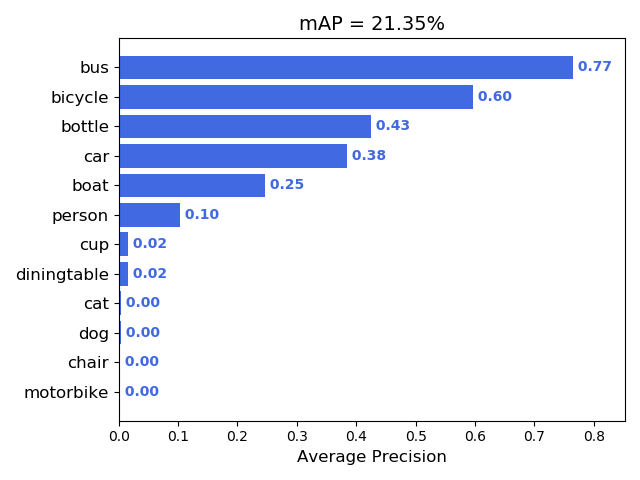

#### We have used some contrast based image enhancement techniques to preprocess our data and calculated our results as mentioned above

#### mAP with Exposure based Image enhancement technique

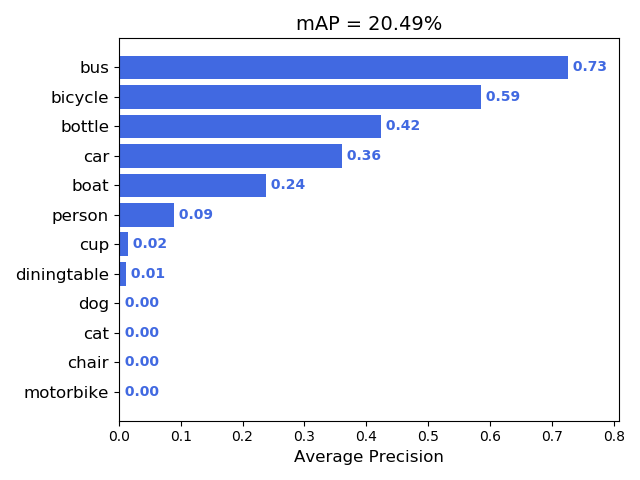

#### Histogram Equalization image enhancement technique - mAP
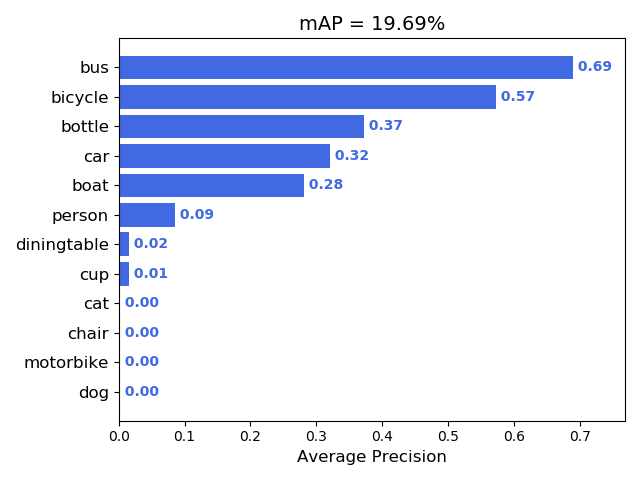

#### Dynamic Histogram Equalization - mAP
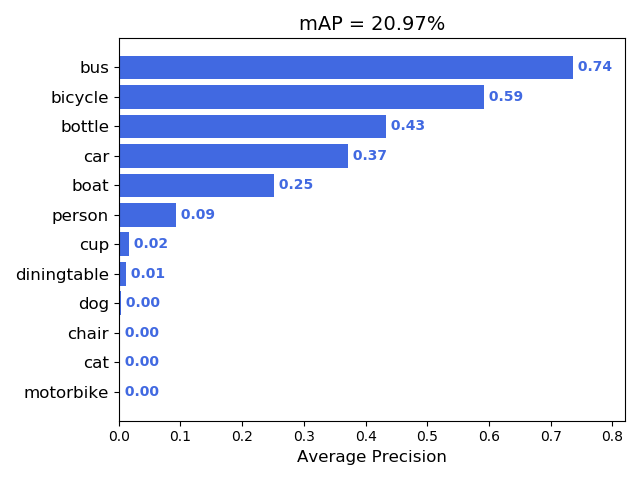

### Training custom model using Ex_dark dataset using Transfer Learning

For building a custom YOLOv3 model on the ExDark data with 12 classes which are a subset of MS COCO dataset classes<br>

The below training code is referred from [1] which explains training of a model from scratch<br>

We used it to build the model architecture for hidden layers, while we customized the last layers for training the ExDark dataset. <br>

- we have applied transfer learning by loading yolov3 weights that was trained on coco dataser rather than using random initialization.

- We loaded the subset of weights, biases which outputs classes in ExDark dataset from pretrained model that was trained on COCO dataset

- We have frozen all the hidden layers and reduced trainable parameters from approximately 60 million to 91,545

- Loss curves can be monitored on running !tensorboard --logdir ./data/log_demo in http://localhost:6006/#scalars

Important training hyperparameters we used for our custom model training other than the hyperparameters specified YOLOv3 paper
- weights initialization: https://pjreddie.com/media/files/yolov3.weights
- Train Annotations path: "./data/dataset/exdark_train.txt"
- Batch size       = 32
- Input image size = 416 x 416 x 3
- Epochs = 30

In [ ]:
# """change __C.YOLO.CLASSES= "./data/classes/coco.names" to "./data/classes/darkdata.names" in core/config.py"""


trainset = Dataset('train')    ## this will generate training batches using annotations file specified in config.py, __C.TRAIN.ANNOT_PATH = "./data/dataset/exdark_train.txt"
logdir = "./data/log_demo"
steps_per_epoch = len(trainset)
global_steps = tf.Variable(1, trainable=False, dtype=tf.int64)
warmup_steps = cfg.TRAIN.WARMUP_EPOCHS * steps_per_epoch
total_steps = cfg.TRAIN.EPOCHS * steps_per_epoch

input_tensor = tf.keras.layers.Input([416, 416,3])
conv_tensors = YOLOv3(input_tensor)

output_tensors = []
for i, conv_tensor in enumerate(conv_tensors):
    pred_tensor = decode(conv_tensor, i)
    output_tensors.append(conv_tensor)
    output_tensors.append(pred_tensor)

exdark_model = tf.keras.Model(input_tensor, output_tensors)

'''load weights of subset of classes from coco trained yolov3 weights'''
'''contains code to select only required weights from coco trained yolo weights on the last layers'''

num = [0,1,2]
weight_num = []
for i in num:
    tmp=[(85*i),(85*i+1),(85*i+2),(85*i+3),(85*i+4),(85*i+4+2),(85*i+4+9),(85*i+4+40),(85*i+4+6),(85*i+4+3),(85*i+4+16),(85*i+4+57),(85*i+4+42),(85*i+4+17),(85*i+4+4),(85*i+4+1),(85*i+4+61)]
    weight_num.append(tmp)
req_weights = []
for each in weight_num:
    for ea in each:
        req_weights.append(ea)
        
wf = open('./yolov3.weights', 'rb')
major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)
j = 0
layer_bias = []
layer_weights = []
for i in range(75):
    conv_layer_name = 'conv2d_%d' %i if i > 0 else 'conv2d'
    bn_layer_name = 'batch_normalization_%d' %j if j > 0 else 'batch_normalization'

    conv_layer = exdark_model.get_layer(conv_layer_name)
    filters = conv_layer.filters
    k_size = conv_layer.kernel_size[0]
    in_dim = conv_layer.input_shape[-1]
    if i not in [58, 66, 74]:
            # darknet weights: [beta, gamma, mean, variance]
        bn_weights = np.fromfile(wf, dtype=np.float32, count=4 * filters)
            # tf weights: [gamma, beta, mean, variance]
        bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
        bn_layer = exdark_model.get_layer(bn_layer_name)
        j += 1
        
    else:
        conv_bias = np.fromfile(wf, dtype=np.float32, count=255)
        layer_bias.append(conv_bias)
    if i not in [58, 66, 74]:        
        conv_shape = (filters, in_dim, k_size, k_size)
        conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
        conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])
        conv_layer.set_weights([conv_weights])
        bn_layer.set_weights(bn_weights)
    elif i==58:
        conv_shape = (255,1024,1,1)
        conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
        # tf shape (height, width, in_dim, out_dim)
        conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])
        layer_weights.append(conv_weights)
        conv_layer.set_weights([conv_weights[:,:,:,req_weights], conv_bias[req_weights]])
    elif i==66:
        conv_shape = (255,512,1,1)
        conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
        # tf shape (height, width, in_dim, out_dim)
        conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])
        layer_weights.append(conv_weights)
        conv_layer.set_weights([conv_weights[:,:,:,req_weights], conv_bias[req_weights]])
    else:
        conv_shape = (255,256,1,1)
        conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
        # tf shape (height, width, in_dim, out_dim)
        conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])
        layer_weights.append(conv_weights)
        conv_layer.set_weights([conv_weights[:,:,:,req_weights], conv_bias[req_weights]])
#print(len(wf.read()))
assert len(wf.read()) == 0, 'failed to read all data'
wf.close()

''' freezing all layers except output layers to fine tune last layers for dark dataset'''
for layer in exdark_model.layers:
    if layer.name in exdark_model.output_names:
        layer.trainable = True
    else:
        layer.trainable = False
        
'''train the model from here'''
exdark_model.summary()
optimizer = tf.keras.optimizers.Adam()
if os.path.exists(logdir): shutil.rmtree(logdir)
writer = tf.summary.create_file_writer(logdir) ##

def train_step(image_data, target):
    with tf.GradientTape() as tape:
        pred_result = exdark_model(image_data, training=True)
        giou_loss=conf_loss=prob_loss=0

        # optimizing process
        for i in range(3):
            conv, pred = pred_result[i*2], pred_result[i*2+1]
            loss_items = compute_loss(pred, conv, *target[i], i)
            giou_loss += loss_items[0]
            conf_loss += loss_items[1]
            prob_loss += loss_items[2]

        total_loss = giou_loss + conf_loss + prob_loss

        gradients = tape.gradient(total_loss, exdark_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, exdark_model.trainable_variables))
        tf.print("=> STEP %4d   lr: %.6f   giou_loss: %4.2f   conf_loss: %4.2f   "
                 "prob_loss: %4.2f   total_loss: %4.2f" %(global_steps, optimizer.lr.numpy(),
                                                          giou_loss, conf_loss,
                                                          prob_loss, total_loss))
        # update learning rate
        global_steps.assign_add(1)
        if global_steps < warmup_steps:
            lr = global_steps / warmup_steps *cfg.TRAIN.LR_INIT
        else:
            lr = cfg.TRAIN.LR_END + 0.5 * (cfg.TRAIN.LR_INIT - cfg.TRAIN.LR_END) * (
                (1 + tf.cos((global_steps - warmup_steps) / (total_steps - warmup_steps) * np.pi))
            )
        optimizer.lr.assign(lr.numpy())

        # writing summary data to logs to display progress in tensor board
        with writer.as_default():
            tf.summary.scalar("lr", optimizer.lr, step=global_steps)
            tf.summary.scalar("loss/total_loss", total_loss, step=global_steps)
            tf.summary.scalar("loss/giou_loss", giou_loss, step=global_steps)
            tf.summary.scalar("loss/conf_loss", conf_loss, step=global_steps)
            tf.summary.scalar("loss/prob_loss", prob_loss, step=global_steps)
        writer.flush()

for epoch in range(cfg.TRAIN.EPOCHS):
    print("epoch %4d/%4d begins here:"%(epoch+1,cfg.TRAIN.EPOCHS)," steps per epoch: ",steps_per_epoch)
    for image_data, target,unhandled in trainset:
        #print(target)
        train_step(image_data, target)
    exdark_model.save_weights("./yolov3_dark")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 416, 416, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu (TensorFl [(None, 416, 416, 32 0           batch_normalization[0][0]        
______________________________________________________________________________________________

__________________________________________________________________________________________________
tf_op_layer_LeakyRelu_21 (Tenso [(None, 52, 52, 256) 0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
tf_op_layer_add_8 (TensorFlowOp [(None, 52, 52, 256) 0           tf_op_layer_add_7[0][0]          
                                                                 tf_op_layer_LeakyRelu_21[0][0]   
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 52, 52, 128)  32768       tf_op_layer_add_8[0][0]          
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 52, 52, 128)  512         conv2d_22[0][0]                  
__________________________________________________________________________________________________
tf_op_laye

zero_padding2d_4 (ZeroPadding2D (None, 27, 27, 512)  0           tf_op_layer_add_18[0][0]         
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 13, 13, 1024) 4718592     zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, 13, 13, 1024) 4096        conv2d_43[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu_43 (Tenso [(None, 13, 13, 1024 0           batch_normalization_43[0][0]     
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 13, 13, 512)  524288      tf_op_layer_LeakyRelu_43[0][0]   
__________________________________________________________________________________________________
batch_norm

batch_normalization_68 (BatchNo (None, 52, 52, 128)  512         conv2d_70[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu_68 (Tenso [(None, 52, 52, 128) 0           batch_normalization_68[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 52, 52, 256)  294912      tf_op_layer_LeakyRelu_68[0][0]   
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 52, 52, 256)  1024        conv2d_71[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_LeakyRelu_69 (Tenso [(None, 52, 52, 256) 0           batch_normalization_69[0][0]     
__________________________________________________________________________________________________
conv2d_72 

tf_op_layer_Tile_8/multiples (T [(5,)]               0           tf_op_layer_strided_slice_22[0][0
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [None]               0           tf_op_layer_Reshape[0][0]        
__________________________________________________________________________________________________
tf_op_layer_Tile_2 (TensorFlowO [(None, None, None,  0           tf_op_layer_strided_slice_10[0][0
                                                                 tf_op_layer_Tile_2/multiples[0][0
__________________________________________________________________________________________________
tf_op_layer_strided_slice_3 (Te [None]               0           tf_op_layer_Reshape[0][0]        
__________________________________________________________________________________________________
tf_op_layer_strided_slice_13 (T [None]               0           tf_op_layer_Reshape_1[0][0]      
__________

W0817 20:52:22.941712 13352 deprecation.py:323] From C:\Users\navee\Anaconda3\envs\tensorflow2.0\lib\site-packages\tensorflow\python\ops\nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


=> STEP    1   lr: 0.001000   giou_loss: 8.40   conf_loss: 76.07   prob_loss: 20.26   total_loss: 104.74
=> STEP    2   lr: 0.000005   giou_loss: 6.87   conf_loss: 66.99   prob_loss: 16.77   total_loss: 90.63
=> STEP    3   lr: 0.000008   giou_loss: 8.56   conf_loss: 90.02   prob_loss: 25.64   total_loss: 124.22


### Results

We  have observed  that the image enhancement techniques weren’t very constructive in improving the performance of YOLO for object detection.

- Below are the resulting mAP values for datasets we have evaluated YOLOv3's performance
<table> <tr> <th>Dataset </th> <th>mAP value</th> </tr> <tr> <td>Benchmark mAp on COCO dataset</td> <td>57.9%</td> </tr> <tr> <td>Benchmark mAp on Dark dataset</td> <td>21.35%</td> </tr> <tr> <td>mAP with (he) enhancement technique on Dark dataset</td> <td>19.69%</td> </tr><tr> <td>mAP with (dhe) enhancement technique on Dark dataset</td> <td>20.97%</td> </tr><tr> <td>mAP with exposure fusion framework enhancement technique on Dark dataset</td> <td>20.49%</td> </tr></table>

- Model loss when trained from scratch


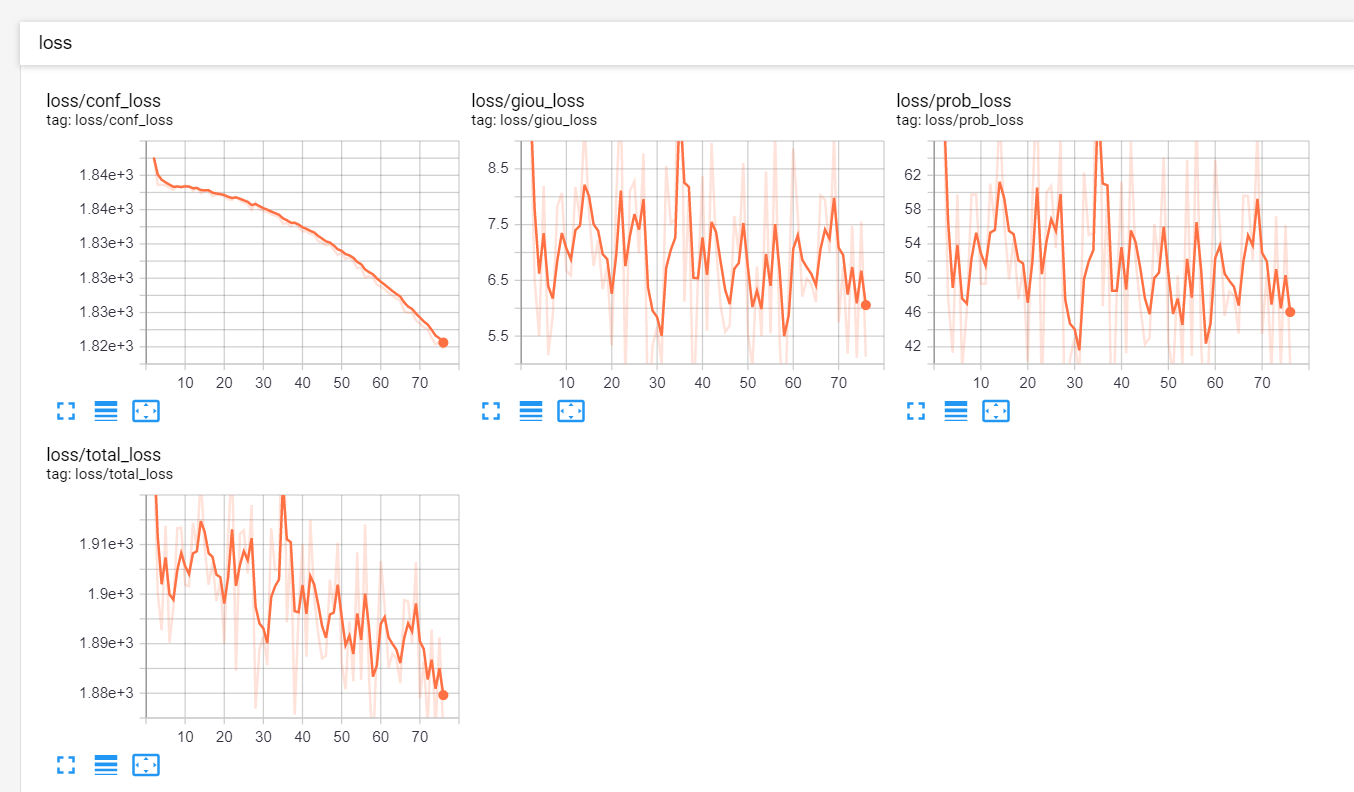


- Model loss on applying transfer learning


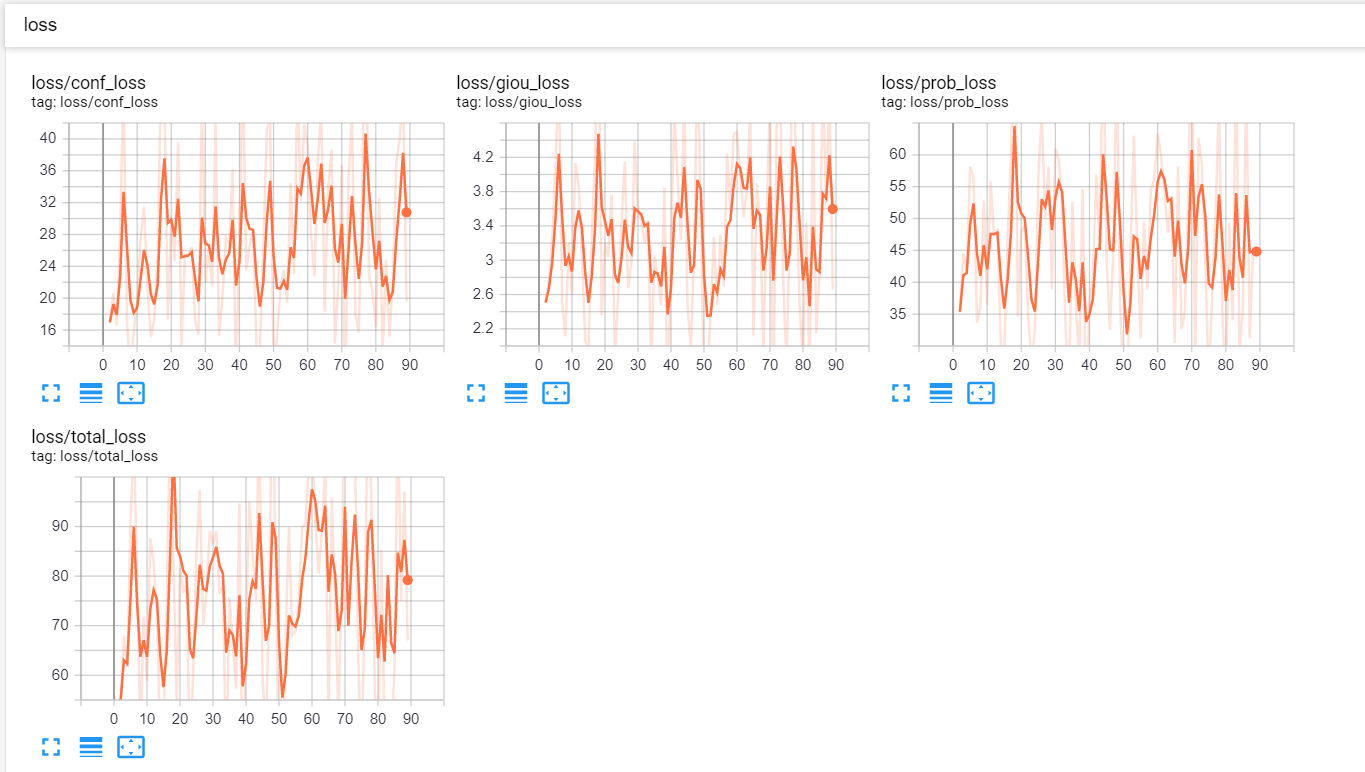

### Conclusions

- With YOLOv3 being one of the fast and powerful object detection systems, it still isn’t efficient in detection of low light images. This can be observed from mAP comparison table (Table 1). <br>
- As presented by the paper YOLOv3: An incremental improvement the mAP score for YOLO trained on COCO dataset is 57.9%. We have considered this mAP score as our Benchmark mAP.But when trained on ExDark dataset it gave us a benchmark of 21.35% (Refer Figure 3). We opted for image contrast enhancement techniques  as a data preprocessing method . The enhancement techniques used were Histogram Equalization (he) , Dynamic Histogram Equalization (dhe) and exposure fusion framework. These enhancement techniques gave a mAP score of mAP(he) = 19.69% (Refer Figure 5) , mAp(dhe) = 20.97% (Refer Figure 7)  and mAP(exposure) = 20.49% (Refer Figure 9) . Hence , we observe that the enhancement techniques didn’t prove useful as the mAP score didn’t improve when compared to the Benchmark mAP score 21.35% on ExDark dataset. <br>
- To sum up, image enhancement methods preprocessing techniques which are contrast based are adding more noise to the original images making the results worsen even(Table 1) though they seem to yield better quality pictures when seeing through a naked eye. In transfer learing approach, as seen in Figure 12,we observed that only fine-tuning last layers is not helping the model to understand more about low light dataset. Hence, in the forthcoming steps we are looking to apply transfer learning on feature detector layers in YOLOv3 architecture i.e, Darknet-53 layers(Figure 2) which seems reasonable to think that might help our model extracting features in low light. <br>
- Also,we would like to explore other image enhancement and denoising techniques as our data preprocessing methods.

### References
[1]	https://github.com/YunYang1994/TensorFlow2.0-Examples/tree/master/4-Object_Detection/YOLOV3 <br>
[2]	https://github.com/AndyHuang1995/Image-Contrast-Enhancement <br>
[3]	https://baidut.github.io/OpenCE/caip2017.html <br>
[4]	https://pjreddie.com/media/files/papers/YOLOv3.pdf <br>
[5]	https://pjreddie.com/media/files/papers/yolo_1.pdf<br>
[6]	@article{yolov3, <br>
  title={YOLOv3: An Incremental Improvement}, <br>
  author={Redmon, Joseph and Farhadi, Ali}, <br>
  journal = {arXiv}, <br>
  year={2018} <br>
} <br>

### MIT License

Copyright (c) 2019 HarshithaGS , Naveen Jami

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

The code in the document by Harshitha G S and Naveen Jami is licensed under the MIT License https://opensource.org/licenses/MIT